In [1]:
import argparse
import os
from typing import Tuple

import matplotlib.pyplot as plt

import gymnasium
import numpy as np
import pandas as pd
import torch
from tianshou.data import Batch, Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager
from tianshou.trainer import offpolicy_trainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net
from torch.utils.tensorboard import SummaryWriter

from env.negotiation import NegotiationEnv
from env.negotiation import Outcome

In [2]:
def get_parser() -> argparse.ArgumentParser:
    parser = argparse.ArgumentParser()
    parser.add_argument("--seed", type=int, default=1626)
    parser.add_argument("--eps-test", type=float, default=0.05)
    parser.add_argument("--eps-train", type=float, default=0.1)
    parser.add_argument("--buffer-size", type=int, default=20000)
    parser.add_argument("--lr", type=float, default=1e-4)
    parser.add_argument(
        "--gamma", type=float, default=0.9, help="a smaller gamma favors earlier win"
    )
    parser.add_argument("--n-step", type=int, default=3)
    parser.add_argument("--target-update-freq", type=int, default=320)
    parser.add_argument("--epoch", type=int, default=20)
    parser.add_argument("--step-per-epoch", type=int, default=1000)
    parser.add_argument("--step-per-collect", type=int, default=10)
    parser.add_argument("--update-per-step", type=float, default=0.1)
    parser.add_argument("--batch-size", type=int, default=64)
    parser.add_argument(
        "--hidden-sizes", type=int, nargs="*", default=[128, 128, 128, 128]
    )
    parser.add_argument("--training-num", type=int, default=10)
    parser.add_argument("--test-num", type=int, default=10)
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--render", type=float, default=0.1)
    parser.add_argument(
        "--win-rate",
        type=float,
        default=0.6,
        help="the expected winning rate: Optimal policy can get 0.7",
    )
    parser.add_argument(
        "--watch",
        default=False,
        action="store_true",
        help="no training, " "watch the play of pre-trained models",
    )
    parser.add_argument(
        "--agent-id",
        type=int,
        default=2,
        help="the learned agent plays as the"
        " agent_id-th player. Choices are 1 and 2.",
    )
    parser.add_argument(
        "--resume-path",
        type=str,
        default="",
        help="the path of agent pth file " "for resuming from a pre-trained agent",
    )
    parser.add_argument(
        "--opponent-path",
        type=str,
        default="",
        help="the path of opponent agent pth file "
        "for resuming from a pre-trained agent",
    )
    parser.add_argument(
        "--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu"
    )
    return parser


def get_args() -> argparse.Namespace:
    parser = get_parser()
    return parser.parse_known_args()[0]


def get_agents(
    args: argparse.Namespace = get_args(),
    stakeholder_vals: np.ndarray | None = None
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = get_env(stakeholder_vals)
    observation_space = (
        env.observation_space["observation"]
        if isinstance(env.observation_space, gymnasium.spaces.Dict)
        else env.observation_space
    )
    args.state_shape = observation_space.shape or observation_space.n
    args.action_shape = env.action_space.shape or env.action_space.n


    agents = []
    for _ in range(env.env.n_agents):
        net = Net(
            args.state_shape,
            args.action_shape,
            hidden_sizes=args.hidden_sizes,
            device=args.device,
        ).to(args.device)
        optim = torch.optim.Adam(net.parameters(), lr=args.lr)

        agents.append(DQNPolicy(net, optim, args.gamma, args.n_step, target_update_freq=args.target_update_freq))
    policy = MultiAgentPolicyManager(agents, env)
    return policy, env.agents


def get_env(data=None, render_mode=None, weights=None):
    return PettingZooEnv(NegotiationEnv(stakeholder_matrix=data, render_mode=render_mode, weights=weights))


def train_agent(
    args: argparse.Namespace = get_args(),
    stakeholder_vals: np.ndarray | None = None,
    weights = None
) -> Tuple[dict, BasePolicy]:
    # ======== environment setup =========
    train_envs = DummyVectorEnv([lambda: get_env(stakeholder_vals, weights=weights) for _ in range(args.training_num)])
    test_envs = DummyVectorEnv([lambda: get_env(stakeholder_vals, weights=weights) for _ in range(args.test_num)])
    # seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    train_envs.seed(args.seed)
    test_envs.seed(args.seed)

    # ======== agent setup =========
    policy, agents = get_agents(args, stakeholder_vals)

    # ======== collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(args.buffer_size, len(train_envs)),
        exploration_noise=True,
    )
    test_collector = Collector(policy, test_envs, exploration_noise=True)
    # policy.set_eps(1)
    train_collector.collect(n_step=args.batch_size * args.training_num)

    # ======== tensorboard logging setup =========
    log_path = os.path.join(args.logdir, "negotiate", "dqn")
    writer = SummaryWriter(log_path)
    writer.add_text("args", str(args))
    logger = TensorboardLogger(writer)

    # ======== callback functions used during training =========
    def save_best_fn(policy):
        if hasattr(args, "model_save_path"):
            model_save_path = args.model_save_path
        else:
            model_save_path = os.path.join(
                args.logdir, "negotiate", "dqn", "policy.pth"
            )
        torch.save(
            policy.policies[agents[args.agent_id - 1]].state_dict(), model_save_path
        )

    def stop_fn(mean_rewards):
        return mean_rewards >= args.win_rate

    def train_fn(epoch, env_step):
        policy.policies[agents[args.agent_id - 1]].set_eps(args.eps_train)

    def test_fn(epoch, env_step):
        policy.policies[agents[args.agent_id - 1]].set_eps(args.eps_test)

    def reward_metric(rews):
        return rews[:, args.agent_id - 1]

    # trainer
    result = offpolicy_trainer(
        policy,
        train_collector,
        test_collector,
        args.epoch,
        args.step_per_epoch,
        args.step_per_collect,
        args.test_num,
        args.batch_size,
        train_fn=train_fn,
        test_fn=test_fn,
        # stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=args.update_per_step,
        logger=logger,
        test_in_train=False,
        reward_metric=reward_metric
    )

    return result, policy.policies

In [4]:
def evaluate_weight_options(data, weight_name, weight_options):
    """Evaluate one set of weight options"""
    def minmax(lst):
        X_std = (lst - np.min(lst)) / (np.max(lst) - np.min(lst))
        X_scaled = X_std * ((np.max(lst) - np.min(lst)) + np.min(lst))
        return X_scaled

    metrics = []
    actions = []

    for weight in weight_options:

        if weight_name == 'direct':
            weights = {weight_name: weight, 'indirect': weight}
        else:
            weights = {weight_name: weight}
        
        args = get_args()
        result, policies = train_agent(args, stakeholder_vals=data, weights=weights)
    
        env = get_env(data)
        obs, info = env.reset()
        done = False
        while not done:
            agent = env.env.agent_selection
            policy = policies[agent]
            action = policy.forward(batch=Batch(obs=[obs], info=[info])).act[0]
        
            recipient = f'agent_{action + 1}'
            # print(f'{agent} targeting {recipient}')
            # print(f'Actions: {env.env.agent_actions[agent]}')
            # print(env.env.observe(None))
            # print()
            
            obs, rew, done, truncated, info = env.step(action)
        metrics.append(env.env.infos['agent_1'])
        actions.append(env.env.agent_actions['agent_1']['actions'])
        print('Final state:')
        print(env.env.observe(None))
        env.close()

    # get metrics 
    primary_steps = [item['metrics'][0] for item in metrics]
    final_prob = [round(item['metrics'][1],4) for item in metrics]

    # calculate metric
    normalized_steps = minmax(primary_steps) + 1
    eval_metric = -(normalized_steps / final_prob)

    # create df of results
    results = pd.DataFrame({"name": weight_name,
              "weight": weight_options,
              "primary_steps": primary_steps, 
              "final_prob": final_prob,
              "primary_actions": actions, 
              "eval_metric": eval_metric})

    return results

def run_evaluation():
    direct = np.arange(0,1.1,0.1)
    w_power = np.arange(1,11,1)
    w_position = np.arange(0,5.5,0.5)
    w_distance = np.arange(0,35,5)
    prob_success_alone = np.arange(0.1,1.1,0.1)
    weight_options = [direct, w_power, w_position, w_distance, prob_success_alone]
    
    # data for each test
    data_coalition = pd.read_csv('data/coalition_weights.csv', header=None).values
    data_power = pd.read_csv('data/power_weights.csv', header=None).values
    data_position = pd.read_csv('data/position_weights.csv', header=None).values
    data_distance = pd.read_csv('data/distance_weights.csv', header=None).values
    data_prob = pd.read_csv('data/prob_success_alone_weight.csv', header=None).values
    datas = [data_coalition, data_power, data_position, data_distance, data_prob]
    
    weight_names = ["direct", "w_power", "w_position", "w_distance", "prob_success_alone"]

    # init results
    results = pd.DataFrame()

    for data, weight_name, weight_option in zip(datas, weight_names, weight_options):
        result_test = evaluate_weight_options(data, weight_name, weight_option)
        results = pd.concat([results, result_test])

    return results

In [5]:
results = run_evaluation()

/Users/katherinehunter/Github/stakeholder-mapping/backend/env/negotiation.py:291: RuntimeWarning: invalid value encountered in scalar power
  standardized_reward = (coalition_reward / self.standardisation_factor) ** 1.2
Epoch #1:   1%| | 10/1000 [00:00<00:29, 33.39it/s, agent_1/loss=0.090, agent_2/l/Users/katherinehunter/Github/stakeholder-mapping/backend/env/negotiation.py:291: RuntimeWarning: invalid value encountered in scalar power
  standardized_reward = (coalition_reward / self.standardisation_factor) ** 1.2
Epoch #1: 1001it [00:00, 1148.16it/s, agent_1/loss=32.535, agent_2/loss=192.614, agent_3/loss=212.156, agent_4/loss=153.541, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1353.900000 ± 86.636828, best_reward: -1229.750000 ± 72.775769 in #0


Epoch #2: 1001it [00:00, 1928.33it/s, agent_1/loss=46.667, agent_2/loss=187.154, agent_3/loss=149.331, agent_4/loss=164.677, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1288.950000 ± 46.370492, best_reward: -1229.750000 ± 72.775769 in #0


Epoch #3: 1001it [00:00, 1926.44it/s, agent_1/loss=15.205, agent_2/loss=156.417, agent_3/loss=61.619, agent_4/loss=120.972, agent_5/loss=0.000, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -374.000000 ± 67.749170, best_reward: -374.000000 ± 67.749170 in #3


Epoch #4: 1001it [00:00, 1923.54it/s, agent_1/loss=22.306, agent_2/loss=105.336, agent_3/loss=48.637, agent_4/loss=83.830, agent_5/loss=0.003, env_step=4000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #4: test_reward: -322.000000 ± 72.919476, best_reward: -322.000000 ± 72.919476 in #4


Epoch #5: 1001it [00:00, 1803.91it/s, agent_1/loss=7.438, agent_2/loss=82.476, agent_3/loss=81.686, agent_4/loss=89.005, agent_5/loss=0.001, env_step=5000, len=501, n/ep=0, n/st=10, rew=-828.65]


Epoch #5: test_reward: -349.350000 ± 65.427842, best_reward: -322.000000 ± 72.919476 in #4


Epoch #6: 1001it [00:00, 1950.92it/s, agent_1/loss=8.160, agent_2/loss=73.924, agent_3/loss=88.900, agent_4/loss=74.060, agent_5/loss=0.001, env_step=6000, len=501, n/ep=0, n/st=10, rew=-828.65]


Epoch #6: test_reward: -386.950000 ± 75.414339, best_reward: -322.000000 ± 72.919476 in #4


Epoch #7: 1001it [00:00, 1949.42it/s, agent_1/loss=9.426, agent_2/loss=123.698, agent_3/loss=67.423, agent_4/loss=51.280, agent_5/loss=0.002, env_step=7000, len=501, n/ep=0, n/st=10, rew=-828.65]


Epoch #7: test_reward: -1229.250000 ± 71.475608, best_reward: -322.000000 ± 72.919476 in #4


Epoch #8: 1001it [00:00, 1938.28it/s, agent_1/loss=4.100, agent_2/loss=84.276, agent_3/loss=40.205, agent_4/loss=79.549, agent_5/loss=0.000, env_step=8000, len=501, n/ep=0, n/st=10, rew=-828.65]


Epoch #8: test_reward: -317.250000 ± 72.658534, best_reward: -317.250000 ± 72.658534 in #8


Epoch #9: 1001it [00:00, 1951.04it/s, agent_1/loss=6.673, agent_2/loss=81.553, agent_3/loss=36.344, agent_4/loss=42.929, agent_5/loss=0.000, env_step=9000, len=501, n/ep=0, n/st=10, rew=-828.65]


Epoch #9: test_reward: -281.100000 ± 73.250870, best_reward: -281.100000 ± 73.250870 in #9


Epoch #10: 1001it [00:00, 1924.89it/s, agent_1/loss=3.164, agent_2/loss=106.480, agent_3/loss=34.547, agent_4/loss=29.869, agent_5/loss=0.002, env_step=10000, len=501, n/ep=0, n/st=10, rew=-359.60]


Epoch #10: test_reward: -1170.050000 ± 63.808875, best_reward: -281.100000 ± 73.250870 in #9


Epoch #11: 1001it [00:00, 1950.65it/s, agent_1/loss=7.357, agent_2/loss=102.957, agent_3/loss=45.688, agent_4/loss=65.814, agent_5/loss=0.002, env_step=11000, len=501, n/ep=0, n/st=10, rew=-359.60]


Epoch #11: test_reward: -371.300000 ± 286.767955, best_reward: -281.100000 ± 73.250870 in #9


Epoch #12: 1001it [00:00, 1806.59it/s, agent_1/loss=2.482, agent_2/loss=101.026, agent_3/loss=58.168, agent_4/loss=58.566, agent_5/loss=0.002, env_step=12000, len=501, n/ep=0, n/st=10, rew=-359.60]


Epoch #12: test_reward: -371.300000 ± 286.767955, best_reward: -281.100000 ± 73.250870 in #9


Epoch #13: 1001it [00:00, 1949.63it/s, agent_1/loss=6.222, agent_2/loss=87.251, agent_3/loss=23.863, agent_4/loss=45.084, agent_5/loss=0.002, env_step=13000, len=501, n/ep=0, n/st=10, rew=-359.60]


Epoch #13: test_reward: -369.300000 ± 287.692648, best_reward: -281.100000 ± 73.250870 in #9


Epoch #14: 1001it [00:00, 1946.52it/s, agent_1/loss=5.190, agent_2/loss=71.757, agent_3/loss=28.636, agent_4/loss=43.500, agent_5/loss=0.001, env_step=14000, len=501, n/ep=0, n/st=10, rew=-359.60]


Epoch #14: test_reward: -285.450000 ± 33.331254, best_reward: -281.100000 ± 73.250870 in #9


Epoch #15: 1001it [00:00, 1930.48it/s, agent_1/loss=2.636, agent_2/loss=81.413, agent_3/loss=28.577, agent_4/loss=30.654, agent_5/loss=0.004, env_step=15000, len=501, n/ep=0, n/st=10, rew=-400.40]


Epoch #15: test_reward: -943.450000 ± 397.367302, best_reward: -281.100000 ± 73.250870 in #9


Epoch #16: 1001it [00:00, 1951.25it/s, agent_1/loss=6.243, agent_2/loss=92.621, agent_3/loss=31.127, agent_4/loss=35.866, agent_5/loss=0.003, env_step=16000, len=501, n/ep=0, n/st=10, rew=-400.40]


Epoch #16: test_reward: -285.450000 ± 33.331254, best_reward: -281.100000 ± 73.250870 in #9


Epoch #17: 1001it [00:00, 1927.17it/s, agent_1/loss=0.769, agent_2/loss=61.188, agent_3/loss=24.677, agent_4/loss=26.295, agent_5/loss=0.003, env_step=17000, len=501, n/ep=0, n/st=10, rew=-400.40]


Epoch #17: test_reward: -285.450000 ± 33.331254, best_reward: -281.100000 ± 73.250870 in #9


Epoch #18: 1001it [00:00, 1949.89it/s, agent_1/loss=4.530, agent_2/loss=91.651, agent_3/loss=24.717, agent_4/loss=38.731, agent_5/loss=0.002, env_step=18000, len=501, n/ep=0, n/st=10, rew=-400.40]


Epoch #18: test_reward: -1136.050000 ± 24.862070, best_reward: -281.100000 ± 73.250870 in #9


Epoch #19: 1001it [00:00, 1951.26it/s, agent_1/loss=5.397, agent_2/loss=66.542, agent_3/loss=27.753, agent_4/loss=29.575, agent_5/loss=0.004, env_step=19000, len=501, n/ep=0, n/st=10, rew=-400.40]


Epoch #19: test_reward: -246.650000 ± 27.696615, best_reward: -246.650000 ± 27.696615 in #19


Epoch #20: 1001it [00:00, 1826.55it/s, agent_1/loss=2.630, agent_2/loss=74.133, agent_3/loss=16.205, agent_4/loss=24.152, agent_5/loss=0.006, env_step=20000, len=501, n/ep=0, n/st=10, rew=-451.45]


Epoch #20: test_reward: -259.350000 ± 35.465511, best_reward: -246.650000 ± 27.696615 in #19
Final state:
[[1 0 1 0 1]
 [0 1 0 1 1]
 [1 0 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1945.94it/s, agent_1/loss=82.852, agent_2/loss=274.491, agent_3/loss=316.834, agent_4/loss=295.033, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1179.425000 ± 105.199991, best_reward: -1179.425000 ± 105.199991 in #1


Epoch #2: 1001it [00:00, 1913.22it/s, agent_1/loss=173.751, agent_2/loss=282.625, agent_3/loss=198.413, agent_4/loss=290.675, agent_5/loss=0.000, env_step=2000, len=191, n/ep=0, n/st=10, rew=-277.50]


Epoch #2: test_reward: -1178.700000 ± 74.529843, best_reward: -1178.700000 ± 74.529843 in #2


Epoch #3: 1001it [00:00, 1871.22it/s, agent_1/loss=213.436, agent_2/loss=213.798, agent_3/loss=138.388, agent_4/loss=122.240, agent_5/loss=0.000, env_step=3000, len=21, n/ep=0, n/st=10, rew=43.25]


Epoch #3: test_reward: -172.850000 ± 199.643438, best_reward: -172.850000 ± 199.643438 in #3


Epoch #4: 1001it [00:00, 1821.87it/s, agent_1/loss=217.811, agent_2/loss=227.781, agent_3/loss=183.466, agent_4/loss=175.683, agent_5/loss=0.005, env_step=4000, len=81, n/ep=0, n/st=10, rew=72.75]


Epoch #4: test_reward: -214.800000 ± 109.571598, best_reward: -172.850000 ± 199.643438 in #3


Epoch #5: 1001it [00:00, 1805.62it/s, agent_1/loss=203.616, agent_2/loss=215.513, agent_3/loss=197.118, agent_4/loss=178.598, agent_5/loss=0.003, env_step=5000, len=196, n/ep=0, n/st=10, rew=-141.25]


Epoch #5: test_reward: -192.075000 ± 179.364575, best_reward: -172.850000 ± 199.643438 in #3


Epoch #6: 1001it [00:00, 1812.57it/s, agent_1/loss=178.153, agent_2/loss=295.696, agent_3/loss=178.947, agent_4/loss=215.947, agent_5/loss=0.003, env_step=6000, len=81, n/ep=0, n/st=10, rew=-0.75]


Epoch #6: test_reward: -808.150000 ± 391.159721, best_reward: -172.850000 ± 199.643438 in #3


Epoch #7: 1001it [00:00, 1838.46it/s, agent_1/loss=139.910, agent_2/loss=339.592, agent_3/loss=143.005, agent_4/loss=232.917, agent_5/loss=0.005, env_step=7000, len=186, n/ep=0, n/st=10, rew=-348.50]


Epoch #7: test_reward: -790.225000 ± 360.823874, best_reward: -172.850000 ± 199.643438 in #3


Epoch #8: 1001it [00:00, 1827.54it/s, agent_1/loss=133.403, agent_2/loss=271.825, agent_3/loss=130.709, agent_4/loss=250.147, agent_5/loss=0.007, env_step=8000, len=231, n/ep=0, n/st=10, rew=-453.75]


Epoch #8: test_reward: 150.900000 ± 67.379633, best_reward: 150.900000 ± 67.379633 in #8


Epoch #9: 1001it [00:00, 1705.80it/s, agent_1/loss=92.108, agent_2/loss=366.875, agent_3/loss=95.949, agent_4/loss=245.072, agent_5/loss=0.006, env_step=9000, len=46, n/ep=0, n/st=10, rew=163.00]


Epoch #9: test_reward: -221.475000 ± 256.999500, best_reward: 150.900000 ± 67.379633 in #8


Epoch #10: 1001it [00:00, 1794.63it/s, agent_1/loss=77.692, agent_2/loss=366.040, agent_3/loss=105.863, agent_4/loss=197.257, agent_5/loss=0.007, env_step=10000, len=136, n/ep=0, n/st=10, rew=236.50]


Epoch #10: test_reward: -207.375000 ± 510.584288, best_reward: 150.900000 ± 67.379633 in #8


Epoch #11: 1001it [00:00, 1769.29it/s, agent_1/loss=83.916, agent_2/loss=352.710, agent_3/loss=78.702, agent_4/loss=183.125, agent_5/loss=0.008, env_step=11000, len=91, n/ep=0, n/st=10, rew=88.75]


Epoch #11: test_reward: -378.750000 ± 472.554494, best_reward: 150.900000 ± 67.379633 in #8


Epoch #12: 1001it [00:00, 1770.98it/s, agent_1/loss=106.136, agent_2/loss=275.177, agent_3/loss=67.255, agent_4/loss=143.086, agent_5/loss=0.011, env_step=12000, len=76, n/ep=0, n/st=10, rew=221.00]


Epoch #12: test_reward: -204.700000 ± 466.922676, best_reward: 150.900000 ± 67.379633 in #8


Epoch #13: 1001it [00:00, 1768.10it/s, agent_1/loss=80.655, agent_2/loss=260.293, agent_3/loss=74.534, agent_4/loss=143.960, agent_5/loss=0.010, env_step=13000, len=36, n/ep=0, n/st=10, rew=224.75]


Epoch #13: test_reward: -107.450000 ± 387.099693, best_reward: 150.900000 ± 67.379633 in #8


Epoch #14: 1001it [00:00, 1774.71it/s, agent_1/loss=79.204, agent_2/loss=377.358, agent_3/loss=78.939, agent_4/loss=136.184, agent_5/loss=0.011, env_step=14000, len=41, n/ep=0, n/st=10, rew=221.50]


Epoch #14: test_reward: -155.825000 ± 324.068165, best_reward: 150.900000 ± 67.379633 in #8


Epoch #15: 1001it [00:00, 1761.03it/s, agent_1/loss=107.462, agent_2/loss=196.040, agent_3/loss=60.450, agent_4/loss=105.874, agent_5/loss=0.013, env_step=15000, len=66, n/ep=0, n/st=10, rew=202.75]


Epoch #15: test_reward: 105.550000 ± 133.265281, best_reward: 150.900000 ± 67.379633 in #8


Epoch #16: 1001it [00:00, 1772.89it/s, agent_1/loss=112.808, agent_2/loss=195.713, agent_3/loss=65.884, agent_4/loss=118.028, agent_5/loss=0.010, env_step=16000, len=41, n/ep=0, n/st=10, rew=221.00]


Epoch #16: test_reward: 152.325000 ± 146.179045, best_reward: 152.325000 ± 146.179045 in #16


Epoch #17: 1001it [00:00, 1637.45it/s, agent_1/loss=122.132, agent_2/loss=270.118, agent_3/loss=85.971, agent_4/loss=103.783, agent_5/loss=0.018, env_step=17000, len=111, n/ep=0, n/st=10, rew=148.50]


Epoch #17: test_reward: 66.050000 ± 190.101775, best_reward: 152.325000 ± 146.179045 in #16


Epoch #18: 1001it [00:00, 1787.47it/s, agent_1/loss=144.584, agent_2/loss=255.990, agent_3/loss=81.276, agent_4/loss=140.770, agent_5/loss=0.015, env_step=18000, len=61, n/ep=0, n/st=10, rew=256.75]


Epoch #18: test_reward: -43.325000 ± 244.474719, best_reward: 152.325000 ± 146.179045 in #16


Epoch #19: 1001it [00:00, 1778.29it/s, agent_1/loss=95.461, agent_2/loss=186.596, agent_3/loss=78.633, agent_4/loss=124.856, agent_5/loss=0.015, env_step=19000, len=86, n/ep=0, n/st=10, rew=208.00]


Epoch #19: test_reward: 81.950000 ± 171.447142, best_reward: 152.325000 ± 146.179045 in #16


Epoch #20: 1001it [00:00, 1769.87it/s, agent_1/loss=87.017, agent_2/loss=197.599, agent_3/loss=72.017, agent_4/loss=130.265, agent_5/loss=0.017, env_step=20000, len=66, n/ep=0, n/st=10, rew=199.75]


Epoch #20: test_reward: 309.825000 ± 91.564393, best_reward: 309.825000 ± 91.564393 in #20
Final state:
[[1 1 1 0 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1924.63it/s, agent_1/loss=218.643, agent_2/loss=510.279, agent_3/loss=347.024, agent_4/loss=405.132, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1062.100000 ± 86.882910, best_reward: -1062.100000 ± 86.882910 in #1


Epoch #2: 1001it [00:00, 1944.17it/s, agent_1/loss=560.620, agent_2/loss=447.668, agent_3/loss=221.460, agent_4/loss=374.193, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1065.450000 ± 91.246219, best_reward: -1062.100000 ± 86.882910 in #1


Epoch #3: 1001it [00:00, 1863.92it/s, agent_1/loss=315.775, agent_2/loss=373.113, agent_3/loss=122.547, agent_4/loss=255.764, agent_5/loss=0.000, env_step=3000, len=31, n/ep=0, n/st=10, rew=140.00]


Epoch #3: test_reward: -94.650000 ± 156.859977, best_reward: -94.650000 ± 156.859977 in #3


Epoch #4: 1001it [00:00, 1773.18it/s, agent_1/loss=372.002, agent_2/loss=480.082, agent_3/loss=229.046, agent_4/loss=185.562, agent_5/loss=0.005, env_step=4000, len=56, n/ep=0, n/st=10, rew=20.00]


Epoch #4: test_reward: -20.600000 ± 230.194353, best_reward: -20.600000 ± 230.194353 in #4


Epoch #5: 1001it [00:00, 1607.33it/s, agent_1/loss=434.284, agent_2/loss=506.243, agent_3/loss=331.744, agent_4/loss=237.474, agent_5/loss=0.003, env_step=5000, len=41, n/ep=0, n/st=10, rew=135.00]


Epoch #5: test_reward: 150.300000 ± 115.643028, best_reward: 150.300000 ± 115.643028 in #5


Epoch #6: 1001it [00:00, 1769.63it/s, agent_1/loss=127.416, agent_2/loss=497.387, agent_3/loss=262.649, agent_4/loss=226.579, agent_5/loss=0.002, env_step=6000, len=36, n/ep=0, n/st=10, rew=278.50]


Epoch #6: test_reward: 212.200000 ± 55.059604, best_reward: 212.200000 ± 55.059604 in #6


Epoch #7: 1001it [00:00, 1743.77it/s, agent_1/loss=210.766, agent_2/loss=423.861, agent_3/loss=368.504, agent_4/loss=268.654, agent_5/loss=0.005, env_step=7000, len=26, n/ep=1, n/st=10, rew=237.50]


Epoch #7: test_reward: 212.200000 ± 55.059604, best_reward: 212.200000 ± 55.059604 in #6


Epoch #8: 1001it [00:00, 1737.44it/s, agent_1/loss=279.932, agent_2/loss=419.349, agent_3/loss=246.998, agent_4/loss=233.002, agent_5/loss=0.008, env_step=8000, len=56, n/ep=1, n/st=10, rew=147.50]


Epoch #8: test_reward: 212.200000 ± 55.059604, best_reward: 212.200000 ± 55.059604 in #6


Epoch #9: 1001it [00:00, 1736.52it/s, agent_1/loss=293.455, agent_2/loss=416.289, agent_3/loss=237.793, agent_4/loss=237.575, agent_5/loss=0.008, env_step=9000, len=31, n/ep=0, n/st=10, rew=222.50]


Epoch #9: test_reward: 271.300000 ± 66.254509, best_reward: 271.300000 ± 66.254509 in #9


Epoch #10: 1001it [00:00, 1772.07it/s, agent_1/loss=245.605, agent_2/loss=603.413, agent_3/loss=267.582, agent_4/loss=219.816, agent_5/loss=0.013, env_step=10000, len=96, n/ep=0, n/st=10, rew=201.50]


Epoch #10: test_reward: 271.300000 ± 66.254509, best_reward: 271.300000 ± 66.254509 in #9


Epoch #11: 1001it [00:00, 1776.47it/s, agent_1/loss=193.613, agent_2/loss=519.145, agent_3/loss=337.719, agent_4/loss=150.308, agent_5/loss=0.014, env_step=11000, len=16, n/ep=0, n/st=10, rew=295.00]


Epoch #11: test_reward: 271.300000 ± 66.254509, best_reward: 271.300000 ± 66.254509 in #9


Epoch #12: 1001it [00:00, 1741.34it/s, agent_1/loss=192.198, agent_2/loss=453.013, agent_3/loss=323.601, agent_4/loss=156.139, agent_5/loss=0.012, env_step=12000, len=21, n/ep=1, n/st=10, rew=281.50]


Epoch #12: test_reward: 252.250000 ± 46.742513, best_reward: 271.300000 ± 66.254509 in #9


Epoch #13: 1001it [00:00, 1630.18it/s, agent_1/loss=170.620, agent_2/loss=492.682, agent_3/loss=380.568, agent_4/loss=172.667, agent_5/loss=0.012, env_step=13000, len=26, n/ep=0, n/st=10, rew=-2.50]


Epoch #13: test_reward: 266.800000 ± 66.866359, best_reward: 271.300000 ± 66.254509 in #9


Epoch #14: 1001it [00:00, 1765.47it/s, agent_1/loss=188.703, agent_2/loss=421.440, agent_3/loss=354.983, agent_4/loss=136.176, agent_5/loss=0.017, env_step=14000, len=36, n/ep=0, n/st=10, rew=219.00]


Epoch #14: test_reward: 269.800000 ± 64.205218, best_reward: 271.300000 ± 66.254509 in #9


Epoch #15: 1001it [00:00, 1765.24it/s, agent_1/loss=147.765, agent_2/loss=387.830, agent_3/loss=350.573, agent_4/loss=124.644, agent_5/loss=0.017, env_step=15000, len=16, n/ep=1, n/st=10, rew=119.50]


Epoch #15: test_reward: 203.650000 ± 138.562269, best_reward: 271.300000 ± 66.254509 in #9


Epoch #16: 1001it [00:00, 1759.90it/s, agent_1/loss=166.035, agent_2/loss=361.743, agent_3/loss=241.268, agent_4/loss=97.700, agent_5/loss=0.020, env_step=16000, len=61, n/ep=0, n/st=10, rew=340.00]


Epoch #16: test_reward: 204.400000 ± 103.514443, best_reward: 271.300000 ± 66.254509 in #9


Epoch #17: 1001it [00:00, 1716.91it/s, agent_1/loss=193.326, agent_2/loss=454.040, agent_3/loss=268.108, agent_4/loss=133.402, agent_5/loss=0.019, env_step=17000, len=81, n/ep=1, n/st=10, rew=238.00]


Epoch #17: test_reward: 343.000000 ± 46.283906, best_reward: 343.000000 ± 46.283906 in #17


Epoch #18: 1001it [00:00, 1717.52it/s, agent_1/loss=158.948, agent_2/loss=384.130, agent_3/loss=288.978, agent_4/loss=123.147, agent_5/loss=0.017, env_step=18000, len=11, n/ep=0, n/st=10, rew=149.50]


Epoch #18: test_reward: 343.000000 ± 46.283906, best_reward: 343.000000 ± 46.283906 in #17


Epoch #19: 1001it [00:00, 1719.16it/s, agent_1/loss=137.427, agent_2/loss=429.556, agent_3/loss=317.985, agent_4/loss=130.201, agent_5/loss=0.021, env_step=19000, len=31, n/ep=1, n/st=10, rew=518.50]


Epoch #19: test_reward: 348.950000 ± 52.272579, best_reward: 348.950000 ± 52.272579 in #19


Epoch #20: 1001it [00:00, 1628.65it/s, agent_1/loss=188.528, agent_2/loss=484.437, agent_3/loss=303.212, agent_4/loss=181.161, agent_5/loss=0.021, env_step=20000, len=71, n/ep=0, n/st=10, rew=263.50]


Epoch #20: test_reward: 356.450000 ± 53.168811, best_reward: 356.450000 ± 53.168811 in #20
Final state:
[[1 0 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1926.30it/s, agent_1/loss=304.256, agent_2/loss=513.827, agent_3/loss=456.649, agent_4/loss=485.525, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1032.400000 ± 121.894893, best_reward: -1020.825000 ± 141.460421 in #0


Epoch #2: 1001it [00:00, 1931.68it/s, agent_1/loss=550.192, agent_2/loss=635.377, agent_3/loss=313.822, agent_4/loss=438.596, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1048.200000 ± 140.033514, best_reward: -1020.825000 ± 141.460421 in #0


Epoch #3: 1001it [00:00, 1906.14it/s, agent_1/loss=459.897, agent_2/loss=591.660, agent_3/loss=176.288, agent_4/loss=366.527, agent_5/loss=0.000, env_step=3000, len=56, n/ep=0, n/st=10, rew=209.50]


Epoch #3: test_reward: 11.100000 ± 172.295067, best_reward: 11.100000 ± 172.295067 in #3


Epoch #4: 1001it [00:00, 1789.50it/s, agent_1/loss=304.872, agent_2/loss=650.140, agent_3/loss=327.950, agent_4/loss=370.688, agent_5/loss=0.005, env_step=4000, len=61, n/ep=0, n/st=10, rew=34.12]


Epoch #4: test_reward: 199.275000 ± 84.800387, best_reward: 199.275000 ± 84.800387 in #4


Epoch #5: 1001it [00:00, 1735.58it/s, agent_1/loss=449.269, agent_2/loss=643.883, agent_3/loss=590.730, agent_4/loss=635.473, agent_5/loss=0.004, env_step=5000, len=31, n/ep=0, n/st=10, rew=473.75]


Epoch #5: test_reward: 429.300000 ± 66.112764, best_reward: 429.300000 ± 66.112764 in #5


Epoch #6: 1001it [00:00, 1550.62it/s, agent_1/loss=334.769, agent_2/loss=1131.545, agent_3/loss=1102.293, agent_4/loss=576.940, agent_5/loss=0.006, env_step=6000, len=21, n/ep=0, n/st=10, rew=300.00]


Epoch #6: test_reward: 309.150000 ± 119.475008, best_reward: 429.300000 ± 66.112764 in #5


Epoch #7: 1001it [00:00, 1720.72it/s, agent_1/loss=254.506, agent_2/loss=1347.434, agent_3/loss=765.426, agent_4/loss=416.853, agent_5/loss=0.010, env_step=7000, len=41, n/ep=3, n/st=10, rew=294.75]


Epoch #7: test_reward: 275.025000 ± 126.529465, best_reward: 429.300000 ± 66.112764 in #5


Epoch #8: 1001it [00:00, 1589.39it/s, agent_1/loss=191.548, agent_2/loss=1175.029, agent_3/loss=531.620, agent_4/loss=412.557, agent_5/loss=0.009, env_step=8000, len=31, n/ep=0, n/st=10, rew=294.00]


Epoch #8: test_reward: 321.475000 ± 55.408534, best_reward: 429.300000 ± 66.112764 in #5


Epoch #9: 1001it [00:00, 1676.09it/s, agent_1/loss=197.156, agent_2/loss=1099.114, agent_3/loss=466.552, agent_4/loss=471.333, agent_5/loss=0.007, env_step=9000, len=26, n/ep=0, n/st=10, rew=275.00]


Epoch #9: test_reward: 308.275000 ± 75.815933, best_reward: 429.300000 ± 66.112764 in #5


Epoch #10: 1001it [00:00, 1699.54it/s, agent_1/loss=198.696, agent_2/loss=1274.177, agent_3/loss=541.191, agent_4/loss=566.670, agent_5/loss=0.012, env_step=10000, len=41, n/ep=1, n/st=10, rew=278.50]


Epoch #10: test_reward: 321.475000 ± 55.408534, best_reward: 429.300000 ± 66.112764 in #5


Epoch #11: 1001it [00:00, 1709.16it/s, agent_1/loss=249.535, agent_2/loss=1299.303, agent_3/loss=693.854, agent_4/loss=637.168, agent_5/loss=0.018, env_step=11000, len=23, n/ep=0, n/st=10, rew=399.12]


Epoch #11: test_reward: 308.275000 ± 75.815933, best_reward: 429.300000 ± 66.112764 in #5


Epoch #12: 1001it [00:00, 1715.22it/s, agent_1/loss=187.880, agent_2/loss=1192.706, agent_3/loss=716.580, agent_4/loss=545.592, agent_5/loss=0.019, env_step=12000, len=96, n/ep=0, n/st=10, rew=424.50]


Epoch #12: test_reward: 396.675000 ± 100.680438, best_reward: 429.300000 ± 66.112764 in #5


Epoch #13: 1001it [00:00, 1695.57it/s, agent_1/loss=96.525, agent_2/loss=1261.479, agent_3/loss=686.899, agent_4/loss=451.971, agent_5/loss=0.016, env_step=13000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #13: test_reward: 398.725000 ± 130.683513, best_reward: 429.300000 ± 66.112764 in #5


Epoch #14: 1001it [00:00, 1630.75it/s, agent_1/loss=89.314, agent_2/loss=1075.434, agent_3/loss=697.824, agent_4/loss=347.382, agent_5/loss=0.013, env_step=14000, len=26, n/ep=0, n/st=10, rew=469.25]


Epoch #14: test_reward: 407.150000 ± 100.559883, best_reward: 429.300000 ± 66.112764 in #5


Epoch #15: 1001it [00:00, 1644.66it/s, agent_1/loss=174.250, agent_2/loss=917.764, agent_3/loss=601.874, agent_4/loss=320.013, agent_5/loss=0.015, env_step=15000, len=21, n/ep=1, n/st=10, rew=469.75]


Epoch #15: test_reward: 411.125000 ± 95.504859, best_reward: 429.300000 ± 66.112764 in #5


Epoch #16: 1001it [00:00, 1665.51it/s, agent_1/loss=150.715, agent_2/loss=932.815, agent_3/loss=527.091, agent_4/loss=285.962, agent_5/loss=0.013, env_step=16000, len=16, n/ep=1, n/st=10, rew=294.25]


Epoch #16: test_reward: 157.200000 ± 136.114373, best_reward: 429.300000 ± 66.112764 in #5


Epoch #17: 1001it [00:00, 1571.82it/s, agent_1/loss=149.367, agent_2/loss=1108.030, agent_3/loss=595.744, agent_4/loss=418.638, agent_5/loss=0.011, env_step=17000, len=16, n/ep=1, n/st=10, rew=339.00]


Epoch #17: test_reward: 408.375000 ± 66.417171, best_reward: 429.300000 ± 66.112764 in #5


Epoch #18: 1001it [00:00, 1635.46it/s, agent_1/loss=125.167, agent_2/loss=990.733, agent_3/loss=568.014, agent_4/loss=411.792, agent_5/loss=0.009, env_step=18000, len=16, n/ep=0, n/st=10, rew=339.00]


Epoch #18: test_reward: 421.000000 ± 60.716658, best_reward: 429.300000 ± 66.112764 in #5


Epoch #19: 1001it [00:00, 1687.41it/s, agent_1/loss=111.422, agent_2/loss=888.778, agent_3/loss=580.622, agent_4/loss=395.158, agent_5/loss=0.013, env_step=19000, len=26, n/ep=0, n/st=10, rew=320.50]


Epoch #19: test_reward: 337.775000 ± 136.689815, best_reward: 429.300000 ± 66.112764 in #5


Epoch #20: 1001it [00:00, 1681.51it/s, agent_1/loss=149.040, agent_2/loss=823.817, agent_3/loss=491.148, agent_4/loss=328.759, agent_5/loss=0.012, env_step=20000, len=31, n/ep=0, n/st=10, rew=242.25]


Epoch #20: test_reward: 436.725000 ± 57.554045, best_reward: 436.725000 ± 57.554045 in #20
Final state:
[[1 0 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1901.27it/s, agent_1/loss=462.403, agent_2/loss=660.225, agent_3/loss=541.750, agent_4/loss=592.579, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -964.700000 ± 164.790958, best_reward: -964.700000 ± 164.790958 in #1


Epoch #2: 1001it [00:00, 1908.02it/s, agent_1/loss=739.413, agent_2/loss=645.308, agent_3/loss=325.676, agent_4/loss=570.027, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1062.850000 ± 146.611570, best_reward: -964.700000 ± 164.790958 in #1


Epoch #3: 1001it [00:00, 1832.93it/s, agent_1/loss=350.444, agent_2/loss=1029.068, agent_3/loss=421.782, agent_4/loss=916.239, agent_5/loss=0.001, env_step=3000, len=76, n/ep=0, n/st=10, rew=163.50]


Epoch #3: test_reward: -870.300000 ± 455.175911, best_reward: -870.300000 ± 455.175911 in #3


Epoch #4: 1001it [00:00, 1790.09it/s, agent_1/loss=1017.525, agent_2/loss=869.550, agent_3/loss=561.270, agent_4/loss=1193.117, agent_5/loss=0.005, env_step=4000, len=66, n/ep=1, n/st=10, rew=238.50]


Epoch #4: test_reward: 172.950000 ± 92.471198, best_reward: 172.950000 ± 92.471198 in #4


Epoch #5: 1001it [00:00, 1723.76it/s, agent_1/loss=684.876, agent_2/loss=1045.863, agent_3/loss=907.497, agent_4/loss=1599.608, agent_5/loss=0.002, env_step=5000, len=43, n/ep=0, n/st=10, rew=188.75]


Epoch #5: test_reward: 161.150000 ± 68.278126, best_reward: 172.950000 ± 92.471198 in #4


Epoch #6: 1001it [00:00, 1618.31it/s, agent_1/loss=409.951, agent_2/loss=1058.335, agent_3/loss=1326.074, agent_4/loss=1479.164, agent_5/loss=0.003, env_step=6000, len=21, n/ep=0, n/st=10, rew=144.50]


Epoch #6: test_reward: 320.500000 ± 131.841192, best_reward: 320.500000 ± 131.841192 in #6


Epoch #7: 1001it [00:00, 1704.22it/s, agent_1/loss=1062.492, agent_2/loss=996.450, agent_3/loss=1523.201, agent_4/loss=1378.874, agent_5/loss=0.008, env_step=7000, len=26, n/ep=0, n/st=10, rew=312.50]


Epoch #7: test_reward: -170.700000 ± 473.443513, best_reward: 320.500000 ± 131.841192 in #6


Epoch #8: 1001it [00:00, 1744.88it/s, agent_1/loss=737.911, agent_2/loss=861.283, agent_3/loss=1189.856, agent_4/loss=1707.216, agent_5/loss=0.006, env_step=8000, len=41, n/ep=0, n/st=10, rew=282.00]


Epoch #8: test_reward: 349.900000 ± 73.042727, best_reward: 349.900000 ± 73.042727 in #8


Epoch #9: 1001it [00:00, 1709.19it/s, agent_1/loss=603.078, agent_2/loss=657.917, agent_3/loss=800.560, agent_4/loss=1521.179, agent_5/loss=0.008, env_step=9000, len=31, n/ep=0, n/st=10, rew=297.50]


Epoch #9: test_reward: 361.800000 ± 79.466408, best_reward: 361.800000 ± 79.466408 in #9


Epoch #10: 1001it [00:00, 1693.19it/s, agent_1/loss=469.267, agent_2/loss=825.068, agent_3/loss=1098.897, agent_4/loss=1851.869, agent_5/loss=0.009, env_step=10000, len=26, n/ep=0, n/st=10, rew=312.50]


Epoch #10: test_reward: 361.800000 ± 79.466408, best_reward: 361.800000 ± 79.466408 in #9


Epoch #11: 1001it [00:00, 1689.05it/s, agent_1/loss=476.774, agent_2/loss=1083.494, agent_3/loss=1128.681, agent_4/loss=1890.623, agent_5/loss=0.010, env_step=11000, len=46, n/ep=0, n/st=10, rew=381.00]


Epoch #11: test_reward: 349.900000 ± 73.042727, best_reward: 361.800000 ± 79.466408 in #9


Epoch #12: 1001it [00:00, 1677.19it/s, agent_1/loss=954.200, agent_2/loss=1139.957, agent_3/loss=961.679, agent_4/loss=1538.203, agent_5/loss=0.012, env_step=12000, len=26, n/ep=1, n/st=10, rew=322.50]


Epoch #12: test_reward: 352.900000 ± 70.635260, best_reward: 361.800000 ± 79.466408 in #9


Epoch #13: 1001it [00:00, 1685.41it/s, agent_1/loss=1180.391, agent_2/loss=1212.260, agent_3/loss=1268.813, agent_4/loss=1437.671, agent_5/loss=0.012, env_step=13000, len=21, n/ep=1, n/st=10, rew=368.00]


Epoch #13: test_reward: 329.300000 ± 67.642147, best_reward: 361.800000 ± 79.466408 in #9


Epoch #14: 1001it [00:00, 1611.61it/s, agent_1/loss=692.634, agent_2/loss=1064.293, agent_3/loss=1035.658, agent_4/loss=1492.503, agent_5/loss=0.009, env_step=14000, len=41, n/ep=0, n/st=10, rew=267.50]


Epoch #14: test_reward: -160.000000 ± 505.265029, best_reward: 361.800000 ± 79.466408 in #9


Epoch #15: 1001it [00:00, 1698.29it/s, agent_1/loss=654.194, agent_2/loss=1119.661, agent_3/loss=1117.831, agent_4/loss=1413.613, agent_5/loss=0.009, env_step=15000, len=26, n/ep=0, n/st=10, rew=228.50]


Epoch #15: test_reward: 71.350000 ± 440.448978, best_reward: 361.800000 ± 79.466408 in #9


Epoch #16: 1001it [00:00, 1703.02it/s, agent_1/loss=615.547, agent_2/loss=837.056, agent_3/loss=1210.421, agent_4/loss=1400.875, agent_5/loss=0.006, env_step=16000, len=21, n/ep=0, n/st=10, rew=432.00]


Epoch #16: test_reward: 256.450000 ± 105.076746, best_reward: 361.800000 ± 79.466408 in #9


Epoch #17: 1001it [00:00, 1692.20it/s, agent_1/loss=593.982, agent_2/loss=853.729, agent_3/loss=1243.670, agent_4/loss=1097.124, agent_5/loss=0.010, env_step=17000, len=26, n/ep=0, n/st=10, rew=367.00]


Epoch #17: test_reward: 377.050000 ± 66.734717, best_reward: 377.050000 ± 66.734717 in #17


Epoch #18: 1001it [00:00, 1671.87it/s, agent_1/loss=466.688, agent_2/loss=692.880, agent_3/loss=1136.536, agent_4/loss=954.818, agent_5/loss=0.010, env_step=18000, len=36, n/ep=0, n/st=10, rew=404.00]


Epoch #18: test_reward: 406.250000 ± 42.804351, best_reward: 406.250000 ± 42.804351 in #18


Epoch #19: 1001it [00:00, 1675.49it/s, agent_1/loss=509.801, agent_2/loss=634.778, agent_3/loss=1066.634, agent_4/loss=992.099, agent_5/loss=0.010, env_step=19000, len=26, n/ep=0, n/st=10, rew=405.00]


Epoch #19: test_reward: 357.900000 ± 134.338528, best_reward: 406.250000 ± 42.804351 in #18


Epoch #20: 1001it [00:00, 1680.05it/s, agent_1/loss=625.766, agent_2/loss=654.669, agent_3/loss=969.201, agent_4/loss=1106.707, agent_5/loss=0.010, env_step=20000, len=16, n/ep=0, n/st=10, rew=516.50]


Epoch #20: test_reward: 471.750000 ± 79.571430, best_reward: 471.750000 ± 79.571430 in #20
Final state:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1925.01it/s, agent_1/loss=585.839, agent_2/loss=981.098, agent_3/loss=811.572, agent_4/loss=620.244, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -863.975000 ± 186.582169, best_reward: -844.825000 ± 180.265882 in #0


Epoch #2: 1001it [00:00, 1820.59it/s, agent_1/loss=877.872, agent_2/loss=1025.256, agent_3/loss=663.838, agent_4/loss=816.166, agent_5/loss=0.001, env_step=2000, len=256, n/ep=0, n/st=10, rew=135.55]


Epoch #2: test_reward: 161.925000 ± 86.600307, best_reward: 161.925000 ± 86.600307 in #2


Epoch #3: 1001it [00:00, 1847.17it/s, agent_1/loss=886.651, agent_2/loss=1184.733, agent_3/loss=712.695, agent_4/loss=870.693, agent_5/loss=0.001, env_step=3000, len=21, n/ep=1, n/st=10, rew=245.25]


Epoch #3: test_reward: 75.175000 ± 302.653123, best_reward: 161.925000 ± 86.600307 in #2


Epoch #4: 1001it [00:00, 1760.80it/s, agent_1/loss=591.382, agent_2/loss=878.460, agent_3/loss=1298.719, agent_4/loss=1083.162, agent_5/loss=0.005, env_step=4000, len=16, n/ep=0, n/st=10, rew=157.50]


Epoch #4: test_reward: 196.425000 ± 114.034153, best_reward: 196.425000 ± 114.034153 in #4


Epoch #5: 1001it [00:00, 1734.90it/s, agent_1/loss=637.844, agent_2/loss=1079.192, agent_3/loss=1997.497, agent_4/loss=2131.939, agent_5/loss=0.003, env_step=5000, len=16, n/ep=1, n/st=10, rew=219.00]


Epoch #5: test_reward: 326.500000 ± 81.409766, best_reward: 326.500000 ± 81.409766 in #5


Epoch #6: 1001it [00:00, 1742.51it/s, agent_1/loss=592.326, agent_2/loss=1430.332, agent_3/loss=1477.500, agent_4/loss=1275.833, agent_5/loss=0.003, env_step=6000, len=36, n/ep=0, n/st=10, rew=352.50]


Epoch #6: test_reward: 402.475000 ± 75.061346, best_reward: 402.475000 ± 75.061346 in #6


Epoch #7: 1001it [00:00, 1734.33it/s, agent_1/loss=474.080, agent_2/loss=1677.158, agent_3/loss=1920.992, agent_4/loss=2038.317, agent_5/loss=0.006, env_step=7000, len=11, n/ep=0, n/st=10, rew=395.00]


Epoch #7: test_reward: -379.650000 ± 590.007640, best_reward: 402.475000 ± 75.061346 in #6


Epoch #8: 1001it [00:00, 1762.98it/s, agent_1/loss=417.685, agent_2/loss=1341.183, agent_3/loss=1906.504, agent_4/loss=2462.029, agent_5/loss=0.005, env_step=8000, len=81, n/ep=0, n/st=10, rew=392.00]


Epoch #8: test_reward: -235.300000 ± 479.385307, best_reward: 402.475000 ± 75.061346 in #6


Epoch #9: 1001it [00:00, 1777.47it/s, agent_1/loss=543.407, agent_2/loss=1281.205, agent_3/loss=1708.392, agent_4/loss=2412.552, agent_5/loss=0.005, env_step=9000, len=31, n/ep=0, n/st=10, rew=548.75]


Epoch #9: test_reward: -407.875000 ± 627.221455, best_reward: 402.475000 ± 75.061346 in #6


Epoch #10: 1001it [00:00, 1789.61it/s, agent_1/loss=484.751, agent_2/loss=1406.139, agent_3/loss=1449.756, agent_4/loss=1868.460, agent_5/loss=0.006, env_step=10000, len=391, n/ep=0, n/st=10, rew=-418.50]


Epoch #10: test_reward: -368.500000 ± 587.677994, best_reward: 402.475000 ± 75.061346 in #6


Epoch #11: 1001it [00:00, 1688.91it/s, agent_1/loss=527.421, agent_2/loss=754.034, agent_3/loss=1389.116, agent_4/loss=1551.409, agent_5/loss=0.006, env_step=11000, len=56, n/ep=0, n/st=10, rew=750.25]


Epoch #11: test_reward: -368.500000 ± 587.677994, best_reward: 402.475000 ± 75.061346 in #6


Epoch #12: 1001it [00:00, 1772.37it/s, agent_1/loss=486.628, agent_2/loss=1024.588, agent_3/loss=1162.775, agent_4/loss=1604.596, agent_5/loss=0.005, env_step=12000, len=96, n/ep=0, n/st=10, rew=443.25]


Epoch #12: test_reward: -368.500000 ± 587.677994, best_reward: 402.475000 ± 75.061346 in #6


Epoch #13: 1001it [00:00, 1768.32it/s, agent_1/loss=435.177, agent_2/loss=857.541, agent_3/loss=1068.285, agent_4/loss=1288.577, agent_5/loss=0.004, env_step=13000, len=44, n/ep=0, n/st=10, rew=329.25]


Epoch #13: test_reward: 444.250000 ± 73.418237, best_reward: 444.250000 ± 73.418237 in #13


Epoch #14: 1001it [00:00, 1760.21it/s, agent_1/loss=298.833, agent_2/loss=945.641, agent_3/loss=846.418, agent_4/loss=1218.886, agent_5/loss=0.002, env_step=14000, len=21, n/ep=1, n/st=10, rew=365.00]


Epoch #14: test_reward: 444.250000 ± 73.418237, best_reward: 444.250000 ± 73.418237 in #13


Epoch #15: 1001it [00:00, 1767.94it/s, agent_1/loss=334.310, agent_2/loss=983.161, agent_3/loss=632.949, agent_4/loss=1427.836, agent_5/loss=0.003, env_step=15000, len=21, n/ep=1, n/st=10, rew=500.25]


Epoch #15: test_reward: 444.250000 ± 73.418237, best_reward: 444.250000 ± 73.418237 in #13


Epoch #16: 1001it [00:00, 1780.82it/s, agent_1/loss=323.365, agent_2/loss=1448.304, agent_3/loss=878.564, agent_4/loss=1329.984, agent_5/loss=0.002, env_step=16000, len=23, n/ep=4, n/st=10, rew=337.94]


Epoch #16: test_reward: 402.425000 ± 89.000706, best_reward: 444.250000 ± 73.418237 in #13


Epoch #17: 1001it [00:00, 1783.83it/s, agent_1/loss=232.599, agent_2/loss=1309.025, agent_3/loss=1062.211, agent_4/loss=986.002, agent_5/loss=0.003, env_step=17000, len=26, n/ep=0, n/st=10, rew=350.00]


Epoch #17: test_reward: 442.750000 ± 74.503272, best_reward: 444.250000 ± 73.418237 in #13


Epoch #18: 1001it [00:00, 1743.67it/s, agent_1/loss=270.888, agent_2/loss=1006.475, agent_3/loss=941.911, agent_4/loss=875.448, agent_5/loss=0.002, env_step=18000, len=16, n/ep=0, n/st=10, rew=391.25]


Epoch #18: test_reward: 444.250000 ± 70.313494, best_reward: 444.250000 ± 73.418237 in #13


Epoch #19: 1001it [00:00, 1622.68it/s, agent_1/loss=183.991, agent_2/loss=965.656, agent_3/loss=859.351, agent_4/loss=865.212, agent_5/loss=0.004, env_step=19000, len=21, n/ep=1, n/st=10, rew=365.00]


Epoch #19: test_reward: 430.825000 ± 74.769400, best_reward: 444.250000 ± 73.418237 in #13


Epoch #20: 1001it [00:00, 1712.75it/s, agent_1/loss=601.203, agent_2/loss=976.111, agent_3/loss=658.955, agent_4/loss=1143.081, agent_5/loss=0.003, env_step=20000, len=21, n/ep=1, n/st=10, rew=365.00]


Epoch #20: test_reward: 416.325000 ± 69.912986, best_reward: 444.250000 ± 73.418237 in #13
Final state:
[[1 0 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1910.27it/s, agent_1/loss=943.872, agent_2/loss=1243.490, agent_3/loss=682.470, agent_4/loss=947.844, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -833.000000 ± 300.384587, best_reward: -786.450000 ± 239.847707 in #0


Epoch #2: 1001it [00:00, 1916.16it/s, agent_1/loss=1063.497, agent_2/loss=1152.456, agent_3/loss=767.056, agent_4/loss=807.546, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -910.200000 ± 259.635533, best_reward: -786.450000 ± 239.847707 in #0


Epoch #3: 1001it [00:00, 1793.81it/s, agent_1/loss=1851.765, agent_2/loss=1048.827, agent_3/loss=547.247, agent_4/loss=1006.468, agent_5/loss=0.001, env_step=3000, len=21, n/ep=1, n/st=10, rew=198.50]


Epoch #3: test_reward: 136.250000 ± 120.771944, best_reward: 136.250000 ± 120.771944 in #3


Epoch #4: 1001it [00:00, 1722.94it/s, agent_1/loss=1962.113, agent_2/loss=1118.588, agent_3/loss=1003.847, agent_4/loss=1854.651, agent_5/loss=0.007, env_step=4000, len=36, n/ep=0, n/st=10, rew=168.00]


Epoch #4: test_reward: 189.050000 ± 77.831051, best_reward: 189.050000 ± 77.831051 in #4


Epoch #5: 1001it [00:00, 1728.81it/s, agent_1/loss=1130.942, agent_2/loss=1477.044, agent_3/loss=2185.627, agent_4/loss=2299.822, agent_5/loss=0.004, env_step=5000, len=21, n/ep=0, n/st=10, rew=155.00]


Epoch #5: test_reward: -64.150000 ± 444.282571, best_reward: 189.050000 ± 77.831051 in #4


Epoch #6: 1001it [00:00, 1728.79it/s, agent_1/loss=2008.974, agent_2/loss=1787.691, agent_3/loss=2239.562, agent_4/loss=2007.507, agent_5/loss=0.005, env_step=6000, len=36, n/ep=0, n/st=10, rew=110.00]


Epoch #6: test_reward: -163.400000 ± 504.874727, best_reward: 189.050000 ± 77.831051 in #4


Epoch #7: 1001it [00:00, 1627.52it/s, agent_1/loss=1777.835, agent_2/loss=1546.253, agent_3/loss=1994.047, agent_4/loss=2112.362, agent_5/loss=0.007, env_step=7000, len=16, n/ep=0, n/st=10, rew=223.50]


Epoch #7: test_reward: 211.900000 ± 91.881119, best_reward: 211.900000 ± 91.881119 in #7


Epoch #8: 1001it [00:00, 1541.27it/s, agent_1/loss=1389.137, agent_2/loss=1090.629, agent_3/loss=1655.128, agent_4/loss=2085.510, agent_5/loss=0.008, env_step=8000, len=21, n/ep=1, n/st=10, rew=385.00]


Epoch #8: test_reward: 523.250000 ± 104.748807, best_reward: 523.250000 ± 104.748807 in #8


Epoch #9: 1001it [00:00, 1685.95it/s, agent_1/loss=1688.323, agent_2/loss=1934.817, agent_3/loss=1527.094, agent_4/loss=1945.627, agent_5/loss=0.008, env_step=9000, len=21, n/ep=0, n/st=10, rew=354.25]


Epoch #9: test_reward: 488.750000 ± 114.969398, best_reward: 523.250000 ± 104.748807 in #8


Epoch #10: 1001it [00:00, 1704.18it/s, agent_1/loss=2068.650, agent_2/loss=1767.979, agent_3/loss=1960.763, agent_4/loss=2552.456, agent_5/loss=0.006, env_step=10000, len=16, n/ep=1, n/st=10, rew=400.00]


Epoch #10: test_reward: 461.500000 ± 114.281670, best_reward: 523.250000 ± 104.748807 in #8


Epoch #11: 1001it [00:00, 1698.21it/s, agent_1/loss=1393.211, agent_2/loss=1988.402, agent_3/loss=1959.411, agent_4/loss=2644.373, agent_5/loss=0.004, env_step=11000, len=16, n/ep=0, n/st=10, rew=736.00]


Epoch #11: test_reward: 111.250000 ± 50.883322, best_reward: 523.250000 ± 104.748807 in #8


Epoch #12: 1001it [00:00, 1664.93it/s, agent_1/loss=1056.319, agent_2/loss=1885.471, agent_3/loss=1381.485, agent_4/loss=2232.733, agent_5/loss=0.006, env_step=12000, len=26, n/ep=1, n/st=10, rew=248.00]


Epoch #12: test_reward: 128.650000 ± 49.010229, best_reward: 523.250000 ± 104.748807 in #8


Epoch #13: 1001it [00:00, 1679.05it/s, agent_1/loss=943.919, agent_2/loss=1310.557, agent_3/loss=1481.486, agent_4/loss=2471.799, agent_5/loss=0.006, env_step=13000, len=26, n/ep=0, n/st=10, rew=248.00]


Epoch #13: test_reward: 128.650000 ± 49.010229, best_reward: 523.250000 ± 104.748807 in #8


Epoch #14: 1001it [00:00, 1687.03it/s, agent_1/loss=935.648, agent_2/loss=1216.586, agent_3/loss=1598.317, agent_4/loss=2579.022, agent_5/loss=0.004, env_step=14000, len=16, n/ep=1, n/st=10, rew=364.00]


Epoch #14: test_reward: 401.650000 ± 98.661555, best_reward: 523.250000 ± 104.748807 in #8


Epoch #15: 1001it [00:00, 1653.90it/s, agent_1/loss=823.134, agent_2/loss=1384.983, agent_3/loss=1482.095, agent_4/loss=2712.987, agent_5/loss=0.004, env_step=15000, len=26, n/ep=0, n/st=10, rew=552.50]


Epoch #15: test_reward: 460.800000 ± 87.824883, best_reward: 523.250000 ± 104.748807 in #8


Epoch #16: 1001it [00:00, 1609.41it/s, agent_1/loss=754.574, agent_2/loss=1603.038, agent_3/loss=1339.887, agent_4/loss=2629.195, agent_5/loss=0.005, env_step=16000, len=21, n/ep=0, n/st=10, rew=671.50]


Epoch #16: test_reward: 460.800000 ± 87.824883, best_reward: 523.250000 ± 104.748807 in #8


Epoch #17: 1001it [00:00, 1680.62it/s, agent_1/loss=903.431, agent_2/loss=1370.856, agent_3/loss=1395.537, agent_4/loss=2117.253, agent_5/loss=0.006, env_step=17000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #17: test_reward: 401.650000 ± 98.661555, best_reward: 523.250000 ± 104.748807 in #8


Epoch #18: 1001it [00:00, 1681.70it/s, agent_1/loss=767.297, agent_2/loss=1358.906, agent_3/loss=1303.260, agent_4/loss=1800.872, agent_5/loss=0.005, env_step=18000, len=31, n/ep=1, n/st=10, rew=532.00]


Epoch #18: test_reward: 447.600000 ± 94.036642, best_reward: 523.250000 ± 104.748807 in #8


Epoch #19: 1001it [00:00, 1693.01it/s, agent_1/loss=664.884, agent_2/loss=1093.056, agent_3/loss=1235.924, agent_4/loss=1953.566, agent_5/loss=0.006, env_step=19000, len=21, n/ep=1, n/st=10, rew=671.50]


Epoch #19: test_reward: 487.600000 ± 143.175906, best_reward: 523.250000 ± 104.748807 in #8


Epoch #20: 1001it [00:00, 1695.05it/s, agent_1/loss=626.691, agent_2/loss=1383.269, agent_3/loss=1032.456, agent_4/loss=2402.723, agent_5/loss=0.006, env_step=20000, len=23, n/ep=0, n/st=10, rew=478.25]


Epoch #20: test_reward: 509.800000 ± 112.532706, best_reward: 523.250000 ± 104.748807 in #8
Final state:
[[1 0 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1910.51it/s, agent_1/loss=1560.764, agent_2/loss=1134.100, agent_3/loss=1042.829, agent_4/loss=884.322, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -621.325000 ± 271.382595, best_reward: -621.325000 ± 271.382595 in #1


Epoch #2: 1001it [00:00, 1917.73it/s, agent_1/loss=1593.539, agent_2/loss=1411.040, agent_3/loss=973.379, agent_4/loss=1205.094, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -811.175000 ± 310.205417, best_reward: -621.325000 ± 271.382595 in #1


Epoch #3: 1001it [00:00, 1820.24it/s, agent_1/loss=1822.827, agent_2/loss=1830.571, agent_3/loss=868.610, agent_4/loss=1306.945, agent_5/loss=0.001, env_step=3000, len=31, n/ep=1, n/st=10, rew=152.00]


Epoch #3: test_reward: 207.825000 ± 74.923966, best_reward: 207.825000 ± 74.923966 in #3


Epoch #4: 1001it [00:00, 1644.93it/s, agent_1/loss=1257.041, agent_2/loss=2061.759, agent_3/loss=2050.136, agent_4/loss=2572.240, agent_5/loss=0.006, env_step=4000, len=31, n/ep=0, n/st=10, rew=152.00]


Epoch #4: test_reward: -465.525000 ± 584.768175, best_reward: 207.825000 ± 74.923966 in #3


Epoch #5: 1001it [00:00, 1755.96it/s, agent_1/loss=1258.314, agent_2/loss=1719.594, agent_3/loss=1657.058, agent_4/loss=2205.910, agent_5/loss=0.004, env_step=5000, len=81, n/ep=0, n/st=10, rew=355.25]


Epoch #5: test_reward: -81.550000 ± 497.939665, best_reward: 207.825000 ± 74.923966 in #3


Epoch #6: 1001it [00:00, 1740.93it/s, agent_1/loss=621.321, agent_2/loss=1427.817, agent_3/loss=988.447, agent_4/loss=1882.987, agent_5/loss=0.002, env_step=6000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #6: test_reward: 246.150000 ± 96.435743, best_reward: 246.150000 ± 96.435743 in #6


Epoch #7: 1001it [00:00, 1684.95it/s, agent_1/loss=572.245, agent_2/loss=1656.007, agent_3/loss=1222.157, agent_4/loss=1452.093, agent_5/loss=0.004, env_step=7000, len=46, n/ep=2, n/st=10, rew=357.38]


Epoch #7: test_reward: 317.925000 ± 131.810520, best_reward: 317.925000 ± 131.810520 in #7


Epoch #8: 1001it [00:00, 1711.63it/s, agent_1/loss=682.584, agent_2/loss=1165.388, agent_3/loss=1125.542, agent_4/loss=1605.607, agent_5/loss=0.004, env_step=8000, len=21, n/ep=1, n/st=10, rew=500.00]


Epoch #8: test_reward: 493.000000 ± 83.352190, best_reward: 493.000000 ± 83.352190 in #8


Epoch #9: 1001it [00:00, 1542.72it/s, agent_1/loss=1450.582, agent_2/loss=1327.658, agent_3/loss=1560.858, agent_4/loss=1641.604, agent_5/loss=0.005, env_step=9000, len=23, n/ep=0, n/st=10, rew=439.75]


Epoch #9: test_reward: 526.450000 ± 120.750197, best_reward: 526.450000 ± 120.750197 in #9


Epoch #10: 1001it [00:00, 1707.52it/s, agent_1/loss=1657.075, agent_2/loss=2154.759, agent_3/loss=1781.268, agent_4/loss=2178.309, agent_5/loss=0.007, env_step=10000, len=16, n/ep=0, n/st=10, rew=455.00]


Epoch #10: test_reward: 546.100000 ± 115.878395, best_reward: 546.100000 ± 115.878395 in #10


Epoch #11: 1001it [00:00, 1696.27it/s, agent_1/loss=959.602, agent_2/loss=1662.794, agent_3/loss=1069.369, agent_4/loss=2209.733, agent_5/loss=0.006, env_step=11000, len=26, n/ep=1, n/st=10, rew=425.00]


Epoch #11: test_reward: 526.450000 ± 120.750197, best_reward: 546.100000 ± 115.878395 in #10


Epoch #12: 1001it [00:00, 1611.06it/s, agent_1/loss=1943.459, agent_2/loss=2555.489, agent_3/loss=1655.826, agent_4/loss=1554.296, agent_5/loss=0.005, env_step=12000, len=21, n/ep=1, n/st=10, rew=440.00]


Epoch #12: test_reward: 540.325000 ± 113.554505, best_reward: 546.100000 ± 115.878395 in #10


Epoch #13: 1001it [00:00, 1682.88it/s, agent_1/loss=2067.138, agent_2/loss=2644.985, agent_3/loss=1696.704, agent_4/loss=1508.626, agent_5/loss=0.005, env_step=13000, len=16, n/ep=0, n/st=10, rew=560.50]


Epoch #13: test_reward: -532.625000 ± 425.467041, best_reward: 546.100000 ± 115.878395 in #10


Epoch #14: 1001it [00:00, 1704.22it/s, agent_1/loss=1417.878, agent_2/loss=2192.137, agent_3/loss=1190.585, agent_4/loss=1170.117, agent_5/loss=0.006, env_step=14000, len=31, n/ep=1, n/st=10, rew=410.00]


Epoch #14: test_reward: 499.775000 ± 111.224348, best_reward: 546.100000 ± 115.878395 in #10


Epoch #15: 1001it [00:00, 1649.43it/s, agent_1/loss=1190.700, agent_2/loss=1294.187, agent_3/loss=986.703, agent_4/loss=738.481, agent_5/loss=0.005, env_step=15000, len=16, n/ep=2, n/st=10, rew=470.13]


Epoch #15: test_reward: 354.250000 ± 140.471883, best_reward: 546.100000 ± 115.878395 in #10


Epoch #16: 1001it [00:00, 1696.12it/s, agent_1/loss=962.178, agent_2/loss=1728.050, agent_3/loss=953.373, agent_4/loss=948.382, agent_5/loss=0.007, env_step=16000, len=16, n/ep=1, n/st=10, rew=425.25]


Epoch #16: test_reward: 388.900000 ± 140.708262, best_reward: 546.100000 ± 115.878395 in #10


Epoch #17: 1001it [00:00, 1680.62it/s, agent_1/loss=1142.593, agent_2/loss=2025.049, agent_3/loss=576.885, agent_4/loss=541.009, agent_5/loss=0.010, env_step=17000, len=26, n/ep=0, n/st=10, rew=439.50]


Epoch #17: test_reward: 543.350000 ± 105.993821, best_reward: 546.100000 ± 115.878395 in #10


Epoch #18: 1001it [00:00, 1693.64it/s, agent_1/loss=983.186, agent_2/loss=1517.367, agent_3/loss=442.737, agent_4/loss=580.461, agent_5/loss=0.012, env_step=18000, len=21, n/ep=0, n/st=10, rew=440.00]


Epoch #18: test_reward: 540.325000 ± 113.554505, best_reward: 546.100000 ± 115.878395 in #10


Epoch #19: 1001it [00:00, 1688.40it/s, agent_1/loss=929.617, agent_2/loss=1316.588, agent_3/loss=500.836, agent_4/loss=657.925, agent_5/loss=0.011, env_step=19000, len=21, n/ep=0, n/st=10, rew=420.25]


Epoch #19: test_reward: 498.025000 ± 107.995454, best_reward: 546.100000 ± 115.878395 in #10


Epoch #20: 1001it [00:00, 1677.60it/s, agent_1/loss=1081.158, agent_2/loss=1509.487, agent_3/loss=503.253, agent_4/loss=793.991, agent_5/loss=0.006, env_step=20000, len=16, n/ep=0, n/st=10, rew=507.75]


Epoch #20: test_reward: 519.850000 ± 107.668484, best_reward: 546.100000 ± 115.878395 in #10
Final state:
[[1 0 1 1 1]
 [0 1 0 1 1]
 [1 0 1 1 0]
 [1 1 1 1 1]
 [1 1 0 1 1]]


Epoch #1: 1001it [00:00, 1770.04it/s, agent_1/loss=1496.640, agent_2/loss=1251.538, agent_3/loss=1496.160, agent_4/loss=987.426, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -733.650000 ± 312.052323, best_reward: -695.000000 ± 199.181199 in #0


Epoch #2: 1001it [00:00, 1904.11it/s, agent_1/loss=1422.328, agent_2/loss=1487.200, agent_3/loss=1242.366, agent_4/loss=1298.721, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -636.250000 ± 292.850154, best_reward: -636.250000 ± 292.850154 in #2


Epoch #3: 1001it [00:00, 1804.12it/s, agent_1/loss=1897.204, agent_2/loss=1511.636, agent_3/loss=711.755, agent_4/loss=1106.295, agent_5/loss=0.001, env_step=3000, len=16, n/ep=0, n/st=10, rew=84.50]


Epoch #3: test_reward: 127.900000 ± 94.016967, best_reward: 127.900000 ± 94.016967 in #3


Epoch #4: 1001it [00:00, 1704.79it/s, agent_1/loss=2046.820, agent_2/loss=947.969, agent_3/loss=2388.910, agent_4/loss=1390.981, agent_5/loss=0.005, env_step=4000, len=8, n/ep=0, n/st=10, rew=42.25]


Epoch #4: test_reward: 115.150000 ± 63.653771, best_reward: 127.900000 ± 94.016967 in #3


Epoch #5: 1001it [00:00, 1698.52it/s, agent_1/loss=1801.727, agent_2/loss=740.600, agent_3/loss=1368.135, agent_4/loss=2295.472, agent_5/loss=0.005, env_step=5000, len=11, n/ep=0, n/st=10, rew=85.00]


Epoch #5: test_reward: 71.500000 ± 52.852625, best_reward: 127.900000 ± 94.016967 in #3


Epoch #6: 1001it [00:00, 1691.71it/s, agent_1/loss=1736.622, agent_2/loss=619.133, agent_3/loss=839.524, agent_4/loss=1426.987, agent_5/loss=0.003, env_step=6000, len=16, n/ep=1, n/st=10, rew=99.00]


Epoch #6: test_reward: 62.950000 ± 56.541777, best_reward: 127.900000 ± 94.016967 in #3


Epoch #7: 1001it [00:00, 1671.59it/s, agent_1/loss=1289.428, agent_2/loss=460.680, agent_3/loss=1121.140, agent_4/loss=1586.533, agent_5/loss=0.007, env_step=7000, len=16, n/ep=0, n/st=10, rew=318.00]


Epoch #7: test_reward: 271.700000 ± 109.100000, best_reward: 271.700000 ± 109.100000 in #7


Epoch #8: 1001it [00:00, 1672.19it/s, agent_1/loss=842.158, agent_2/loss=732.275, agent_3/loss=1188.148, agent_4/loss=1686.234, agent_5/loss=0.008, env_step=8000, len=16, n/ep=1, n/st=10, rew=250.00]


Epoch #8: test_reward: 285.650000 ± 125.156912, best_reward: 285.650000 ± 125.156912 in #8


Epoch #9: 1001it [00:00, 1604.95it/s, agent_1/loss=733.548, agent_2/loss=1379.014, agent_3/loss=1457.630, agent_4/loss=1540.032, agent_5/loss=0.009, env_step=9000, len=16, n/ep=0, n/st=10, rew=-1.50]


Epoch #9: test_reward: 294.200000 ± 72.672966, best_reward: 294.200000 ± 72.672966 in #9


Epoch #10: 1001it [00:00, 1679.39it/s, agent_1/loss=1428.498, agent_2/loss=1818.232, agent_3/loss=1677.361, agent_4/loss=1743.908, agent_5/loss=0.011, env_step=10000, len=26, n/ep=0, n/st=10, rew=-60.50]


Epoch #10: test_reward: -393.300000 ± 578.751164, best_reward: 294.200000 ± 72.672966 in #9


Epoch #11: 1001it [00:00, 1757.69it/s, agent_1/loss=1767.081, agent_2/loss=1947.039, agent_3/loss=1293.732, agent_4/loss=2699.512, agent_5/loss=0.017, env_step=11000, len=136, n/ep=1, n/st=10, rew=262.50]


Epoch #11: test_reward: -7.100000 ± 558.307657, best_reward: 294.200000 ± 72.672966 in #9


Epoch #12: 1001it [00:00, 1700.49it/s, agent_1/loss=1811.732, agent_2/loss=1641.372, agent_3/loss=1176.424, agent_4/loss=2189.962, agent_5/loss=0.014, env_step=12000, len=26, n/ep=0, n/st=10, rew=263.50]


Epoch #12: test_reward: 315.450000 ± 224.429995, best_reward: 315.450000 ± 224.429995 in #12


Epoch #13: 1001it [00:00, 1424.60it/s, agent_1/loss=1749.439, agent_2/loss=1408.743, agent_3/loss=1912.262, agent_4/loss=1804.564, agent_5/loss=0.013, env_step=13000, len=21, n/ep=0, n/st=10, rew=859.00]


Epoch #13: test_reward: 280.250000 ± 189.712315, best_reward: 315.450000 ± 224.429995 in #12


Epoch #14: 1001it [00:00, 1491.19it/s, agent_1/loss=1506.600, agent_2/loss=1349.009, agent_3/loss=2160.739, agent_4/loss=1829.802, agent_5/loss=0.013, env_step=14000, len=16, n/ep=0, n/st=10, rew=307.00]


Epoch #14: test_reward: 362.650000 ± 120.098512, best_reward: 362.650000 ± 120.098512 in #14


Epoch #15: 1001it [00:00, 1648.37it/s, agent_1/loss=1357.500, agent_2/loss=1299.553, agent_3/loss=2126.337, agent_4/loss=1541.910, agent_5/loss=0.011, env_step=15000, len=26, n/ep=1, n/st=10, rew=581.50]


Epoch #15: test_reward: 363.950000 ± 119.656059, best_reward: 363.950000 ± 119.656059 in #15


Epoch #16: 1001it [00:00, 1651.24it/s, agent_1/loss=1266.480, agent_2/loss=1248.096, agent_3/loss=2120.671, agent_4/loss=1680.140, agent_5/loss=0.012, env_step=16000, len=23, n/ep=2, n/st=10, rew=391.50]


Epoch #16: test_reward: 454.400000 ± 100.260860, best_reward: 454.400000 ± 100.260860 in #16


Epoch #17: 1001it [00:00, 1648.88it/s, agent_1/loss=1240.224, agent_2/loss=1295.394, agent_3/loss=3129.170, agent_4/loss=2073.357, agent_5/loss=0.014, env_step=17000, len=31, n/ep=0, n/st=10, rew=-3.00]


Epoch #17: test_reward: 437.800000 ± 78.026662, best_reward: 454.400000 ± 100.260860 in #16


Epoch #18: 1001it [00:00, 1579.38it/s, agent_1/loss=1011.969, agent_2/loss=1204.217, agent_3/loss=2512.531, agent_4/loss=1786.869, agent_5/loss=0.012, env_step=18000, len=21, n/ep=0, n/st=10, rew=249.50]


Epoch #18: test_reward: 454.400000 ± 100.260860, best_reward: 454.400000 ± 100.260860 in #16


Epoch #19: 1001it [00:00, 1680.31it/s, agent_1/loss=985.494, agent_2/loss=1273.374, agent_3/loss=2318.637, agent_4/loss=1898.485, agent_5/loss=0.010, env_step=19000, len=16, n/ep=0, n/st=10, rew=250.00]


Epoch #19: test_reward: 405.100000 ± 143.263010, best_reward: 454.400000 ± 100.260860 in #16


Epoch #20: 1001it [00:00, 1661.50it/s, agent_1/loss=1042.202, agent_2/loss=1140.005, agent_3/loss=3095.765, agent_4/loss=1795.504, agent_5/loss=0.013, env_step=20000, len=18, n/ep=0, n/st=10, rew=489.25]


Epoch #20: test_reward: 391.900000 ± 153.536608, best_reward: 454.400000 ± 100.260860 in #16
Final state:
[[1 1 1 1 1]
 [1 1 0 0 0]
 [1 0 1 0 0]
 [1 0 0 1 1]
 [1 0 0 1 1]]


Epoch #1: 1001it [00:00, 1891.83it/s, agent_1/loss=1652.507, agent_2/loss=1637.366, agent_3/loss=1695.377, agent_4/loss=1084.378, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -891.850000 ± 293.837800, best_reward: -409.475000 ± 231.606899 in #0


Epoch #2: 1001it [00:00, 1916.44it/s, agent_1/loss=2191.631, agent_2/loss=1803.396, agent_3/loss=1595.088, agent_4/loss=1241.926, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -580.575000 ± 353.804431, best_reward: -409.475000 ± 231.606899 in #0


Epoch #3: 1001it [00:00, 1819.37it/s, agent_1/loss=1720.264, agent_2/loss=2207.928, agent_3/loss=815.989, agent_4/loss=2083.328, agent_5/loss=0.001, env_step=3000, len=11, n/ep=0, n/st=10, rew=97.50]


Epoch #3: test_reward: 140.075000 ± 96.658164, best_reward: 140.075000 ± 96.658164 in #3


Epoch #4: 1001it [00:00, 1730.74it/s, agent_1/loss=1191.992, agent_2/loss=1439.671, agent_3/loss=1029.856, agent_4/loss=3484.109, agent_5/loss=0.006, env_step=4000, len=12, n/ep=0, n/st=10, rew=121.67]


Epoch #4: test_reward: 129.350000 ± 70.695580, best_reward: 140.075000 ± 96.658164 in #3


Epoch #5: 1001it [00:00, 1695.68it/s, agent_1/loss=2019.687, agent_2/loss=1831.110, agent_3/loss=939.915, agent_4/loss=2304.059, agent_5/loss=0.004, env_step=5000, len=11, n/ep=1, n/st=10, rew=462.50]


Epoch #5: test_reward: 80.250000 ± 58.062143, best_reward: 140.075000 ± 96.658164 in #3


Epoch #6: 1001it [00:00, 1561.68it/s, agent_1/loss=1457.420, agent_2/loss=2129.929, agent_3/loss=806.381, agent_4/loss=1592.829, agent_5/loss=0.005, env_step=6000, len=11, n/ep=0, n/st=10, rew=55.50]


Epoch #6: test_reward: 184.100000 ± 112.717856, best_reward: 184.100000 ± 112.717856 in #6


Epoch #7: 1001it [00:00, 1647.50it/s, agent_1/loss=768.963, agent_2/loss=1308.880, agent_3/loss=709.955, agent_4/loss=2649.967, agent_5/loss=0.006, env_step=7000, len=16, n/ep=1, n/st=10, rew=476.25]


Epoch #7: test_reward: 148.375000 ± 131.946213, best_reward: 184.100000 ± 112.717856 in #6


Epoch #8: 1001it [00:00, 1661.68it/s, agent_1/loss=430.571, agent_2/loss=1294.640, agent_3/loss=903.642, agent_4/loss=2471.612, agent_5/loss=0.004, env_step=8000, len=21, n/ep=0, n/st=10, rew=169.50]


Epoch #8: test_reward: 184.100000 ± 112.717856, best_reward: 184.100000 ± 112.717856 in #6


Epoch #9: 1001it [00:00, 1629.21it/s, agent_1/loss=463.226, agent_2/loss=1324.843, agent_3/loss=1416.569, agent_4/loss=2035.052, agent_5/loss=0.005, env_step=9000, len=11, n/ep=1, n/st=10, rew=162.50]


Epoch #9: test_reward: 184.050000 ± 84.617138, best_reward: 184.100000 ± 112.717856 in #6


Epoch #10: 1001it [00:00, 1641.20it/s, agent_1/loss=357.335, agent_2/loss=1207.636, agent_3/loss=1590.729, agent_4/loss=2014.696, agent_5/loss=0.007, env_step=10000, len=11, n/ep=3, n/st=10, rew=201.75]

Epoch #10: test_reward: 172.150000 ± 64.572363, best_reward: 184.100000 ± 112.717856 in #6



Epoch #11: 1001it [00:00, 1694.87it/s, agent_1/loss=511.725, agent_2/loss=1086.630, agent_3/loss=1843.933, agent_4/loss=2373.208, agent_5/loss=0.007, env_step=11000, len=6, n/ep=0, n/st=10, rew=112.50]


Epoch #11: test_reward: 218.475000 ± 154.843609, best_reward: 218.475000 ± 154.843609 in #11


Epoch #12: 1001it [00:00, 1701.89it/s, agent_1/loss=761.506, agent_2/loss=1782.907, agent_3/loss=1987.185, agent_4/loss=2724.725, agent_5/loss=0.007, env_step=12000, len=11, n/ep=0, n/st=10, rew=290.00]


Epoch #12: test_reward: 230.150000 ± 121.436105, best_reward: 230.150000 ± 121.436105 in #12


Epoch #13: 1001it [00:00, 1703.12it/s, agent_1/loss=532.379, agent_2/loss=1930.705, agent_3/loss=2313.089, agent_4/loss=2221.322, agent_5/loss=0.007, env_step=13000, len=11, n/ep=0, n/st=10, rew=162.50]


Epoch #13: test_reward: 200.300000 ± 40.580599, best_reward: 230.150000 ± 121.436105 in #12


Epoch #14: 1001it [00:00, 1613.99it/s, agent_1/loss=417.582, agent_2/loss=1576.886, agent_3/loss=2456.723, agent_4/loss=2189.045, agent_5/loss=0.008, env_step=14000, len=21, n/ep=1, n/st=10, rew=235.75]


Epoch #14: test_reward: 191.325000 ± 61.978731, best_reward: 230.150000 ± 121.436105 in #12


Epoch #15: 1001it [00:00, 1735.68it/s, agent_1/loss=1162.869, agent_2/loss=1429.561, agent_3/loss=2913.473, agent_4/loss=3078.908, agent_5/loss=0.012, env_step=15000, len=101, n/ep=0, n/st=10, rew=610.75]


Epoch #15: test_reward: 213.625000 ± 120.327171, best_reward: 230.150000 ± 121.436105 in #12


Epoch #16: 1001it [00:00, 1699.30it/s, agent_1/loss=817.915, agent_2/loss=1482.826, agent_3/loss=2259.052, agent_4/loss=2980.132, agent_5/loss=0.008, env_step=16000, len=21, n/ep=1, n/st=10, rew=745.50]


Epoch #16: test_reward: 455.250000 ± 199.654733, best_reward: 455.250000 ± 199.654733 in #16


Epoch #17: 1001it [00:00, 1730.95it/s, agent_1/loss=1465.388, agent_2/loss=2277.266, agent_3/loss=2556.495, agent_4/loss=3800.018, agent_5/loss=0.014, env_step=17000, len=101, n/ep=0, n/st=10, rew=670.75]


Epoch #17: test_reward: 109.275000 ± 493.694927, best_reward: 455.250000 ± 199.654733 in #16


Epoch #18: 1001it [00:00, 1728.91it/s, agent_1/loss=1837.102, agent_2/loss=1806.725, agent_3/loss=2583.538, agent_4/loss=3732.272, agent_5/loss=0.014, env_step=18000, len=66, n/ep=0, n/st=10, rew=583.25]


Epoch #18: test_reward: 328.825000 ± 365.951108, best_reward: 455.250000 ± 199.654733 in #16


Epoch #19: 1001it [00:00, 1691.33it/s, agent_1/loss=1596.061, agent_2/loss=1409.963, agent_3/loss=2154.636, agent_4/loss=3883.162, agent_5/loss=0.016, env_step=19000, len=16, n/ep=1, n/st=10, rew=422.25]


Epoch #19: test_reward: 465.500000 ± 74.192149, best_reward: 465.500000 ± 74.192149 in #19


Epoch #20: 1001it [00:00, 1667.22it/s, agent_1/loss=1511.558, agent_2/loss=1508.263, agent_3/loss=2031.507, agent_4/loss=3673.028, agent_5/loss=0.010, env_step=20000, len=16, n/ep=0, n/st=10, rew=333.50]


Epoch #20: test_reward: 442.350000 ± 99.513328, best_reward: 465.500000 ± 74.192149 in #19
Final state:
[[1 1 1 1 1]
 [1 1 1 0 0]
 [1 1 1 0 1]
 [1 0 0 1 1]
 [1 0 1 1 1]]


Epoch #1: 1001it [00:00, 1903.70it/s, agent_1/loss=2010.007, agent_2/loss=2014.001, agent_3/loss=1227.004, agent_4/loss=1546.114, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -375.700000 ± 246.688792, best_reward: -321.950000 ± 252.293822 in #0


Epoch #2: 1001it [00:00, 1909.18it/s, agent_1/loss=3093.852, agent_2/loss=2309.843, agent_3/loss=1687.953, agent_4/loss=1908.616, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -573.800000 ± 331.994518, best_reward: -321.950000 ± 252.293822 in #0


Epoch #3: 1001it [00:00, 1781.25it/s, agent_1/loss=2054.295, agent_2/loss=2241.153, agent_3/loss=747.031, agent_4/loss=1527.087, agent_5/loss=0.001, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -800.950000 ± 370.712587, best_reward: -321.950000 ± 252.293822 in #0


Epoch #4: 1001it [00:00, 1912.13it/s, agent_1/loss=2277.538, agent_2/loss=1406.745, agent_3/loss=727.205, agent_4/loss=946.145, agent_5/loss=0.002, env_step=4000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #4: test_reward: -638.550000 ± 309.342565, best_reward: -321.950000 ± 252.293822 in #0


Epoch #5: 1001it [00:00, 1823.19it/s, agent_1/loss=659.088, agent_2/loss=1769.981, agent_3/loss=455.130, agent_4/loss=846.634, agent_5/loss=0.000, env_step=5000, len=26, n/ep=1, n/st=10, rew=602.50]


Epoch #5: test_reward: 427.700000 ± 200.811504, best_reward: 427.700000 ± 200.811504 in #5


Epoch #6: 1001it [00:00, 1712.14it/s, agent_1/loss=1799.409, agent_2/loss=2693.034, agent_3/loss=1394.628, agent_4/loss=1715.773, agent_5/loss=0.003, env_step=6000, len=13, n/ep=2, n/st=10, rew=587.25]


Epoch #6: test_reward: 650.450000 ± 299.661430, best_reward: 650.450000 ± 299.661430 in #6


Epoch #7: 1001it [00:00, 1721.36it/s, agent_1/loss=2223.803, agent_2/loss=4613.883, agent_3/loss=1496.261, agent_4/loss=1758.806, agent_5/loss=0.008, env_step=7000, len=21, n/ep=0, n/st=10, rew=632.00]


Epoch #7: test_reward: 544.700000 ± 226.804343, best_reward: 650.450000 ± 299.661430 in #6


Epoch #8: 1001it [00:00, 1697.22it/s, agent_1/loss=1446.236, agent_2/loss=3402.133, agent_3/loss=2196.016, agent_4/loss=2733.177, agent_5/loss=0.006, env_step=8000, len=11, n/ep=0, n/st=10, rew=582.50]


Epoch #8: test_reward: 526.750000 ± 93.934086, best_reward: 650.450000 ± 299.661430 in #6


Epoch #9: 1001it [00:00, 1680.48it/s, agent_1/loss=1076.574, agent_2/loss=2482.266, agent_3/loss=2192.121, agent_4/loss=2765.195, agent_5/loss=0.005, env_step=9000, len=21, n/ep=0, n/st=10, rew=564.75]


Epoch #9: test_reward: 550.500000 ± 92.758019, best_reward: 650.450000 ± 299.661430 in #6


Epoch #10: 1001it [00:00, 1688.57it/s, agent_1/loss=707.294, agent_2/loss=5124.888, agent_3/loss=3943.178, agent_4/loss=2693.157, agent_5/loss=0.004, env_step=10000, len=11, n/ep=1, n/st=10, rew=582.50]


Epoch #10: test_reward: 575.400000 ± 147.928834, best_reward: 650.450000 ± 299.661430 in #6


Epoch #11: 1001it [00:00, 1613.43it/s, agent_1/loss=1472.601, agent_2/loss=4691.737, agent_3/loss=4295.088, agent_4/loss=2756.147, agent_5/loss=0.003, env_step=11000, len=21, n/ep=0, n/st=10, rew=637.50]


Epoch #11: test_reward: 600.750000 ± 77.395817, best_reward: 650.450000 ± 299.661430 in #6


Epoch #12: 1001it [00:00, 1586.64it/s, agent_1/loss=3311.161, agent_2/loss=4368.773, agent_3/loss=3354.263, agent_4/loss=2235.746, agent_5/loss=0.005, env_step=12000, len=46, n/ep=1, n/st=10, rew=535.50]


Epoch #12: test_reward: 669.200000 ± 114.493057, best_reward: 669.200000 ± 114.493057 in #12


Epoch #13: 1001it [00:00, 1680.68it/s, agent_1/loss=2621.338, agent_2/loss=5122.661, agent_3/loss=3001.580, agent_4/loss=2629.639, agent_5/loss=0.006, env_step=13000, len=16, n/ep=0, n/st=10, rew=794.50]


Epoch #13: test_reward: 161.000000 ± 692.694052, best_reward: 669.200000 ± 114.493057 in #12


Epoch #14: 1001it [00:00, 1692.75it/s, agent_1/loss=1627.549, agent_2/loss=5140.556, agent_3/loss=2471.852, agent_4/loss=4002.384, agent_5/loss=0.008, env_step=14000, len=21, n/ep=0, n/st=10, rew=552.50]


Epoch #14: test_reward: 620.400000 ± 134.710579, best_reward: 669.200000 ± 114.493057 in #12


Epoch #15: 1001it [00:00, 1689.45it/s, agent_1/loss=1031.922, agent_2/loss=4706.847, agent_3/loss=2928.819, agent_4/loss=3280.226, agent_5/loss=0.006, env_step=15000, len=16, n/ep=0, n/st=10, rew=632.50]


Epoch #15: test_reward: 580.650000 ± 224.158543, best_reward: 669.200000 ± 114.493057 in #12


Epoch #16: 1001it [00:00, 1695.80it/s, agent_1/loss=702.664, agent_2/loss=3977.142, agent_3/loss=2042.521, agent_4/loss=3033.644, agent_5/loss=0.008, env_step=16000, len=26, n/ep=1, n/st=10, rew=537.50]


Epoch #16: test_reward: 542.400000 ± 218.259227, best_reward: 669.200000 ± 114.493057 in #12


Epoch #17: 1001it [00:00, 1684.30it/s, agent_1/loss=1237.850, agent_2/loss=5698.860, agent_3/loss=2445.942, agent_4/loss=2930.748, agent_5/loss=0.004, env_step=17000, len=23, n/ep=2, n/st=10, rew=545.00]


Epoch #17: test_reward: 580.650000 ± 224.158543, best_reward: 669.200000 ± 114.493057 in #12


Epoch #18: 1001it [00:00, 1672.44it/s, agent_1/loss=812.272, agent_2/loss=5377.835, agent_3/loss=2597.313, agent_4/loss=2316.202, agent_5/loss=0.004, env_step=18000, len=21, n/ep=0, n/st=10, rew=552.50]


Epoch #18: test_reward: 580.650000 ± 224.158543, best_reward: 669.200000 ± 114.493057 in #12


Epoch #19: 1001it [00:00, 1674.03it/s, agent_1/loss=651.918, agent_2/loss=5013.605, agent_3/loss=2507.285, agent_4/loss=3845.092, agent_5/loss=0.004, env_step=19000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #19: test_reward: 576.400000 ± 218.343514, best_reward: 669.200000 ± 114.493057 in #12


Epoch #20: 1001it [00:00, 1583.78it/s, agent_1/loss=920.711, agent_2/loss=4906.991, agent_3/loss=2195.614, agent_4/loss=3638.377, agent_5/loss=0.003, env_step=20000, len=17, n/ep=0, n/st=10, rew=513.33]


Epoch #20: test_reward: 622.250000 ± 109.809437, best_reward: 669.200000 ± 114.493057 in #12
Final state:
[[1 0 1 1 1]
 [0 1 0 1 1]
 [1 0 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1902.31it/s, agent_1/loss=579.114, agent_2/loss=600.572, agent_3/loss=317.272, agent_4/loss=477.736, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1142.825000 ± 132.147836, best_reward: -1091.275000 ± 104.410335 in #0


Epoch #2: 1001it [00:00, 1905.50it/s, agent_1/loss=750.679, agent_2/loss=528.650, agent_3/loss=191.876, agent_4/loss=368.172, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1101.275000 ± 120.021584, best_reward: -1091.275000 ± 104.410335 in #0


Epoch #3: 1001it [00:00, 1754.11it/s, agent_1/loss=469.170, agent_2/loss=526.727, agent_3/loss=107.555, agent_4/loss=255.068, agent_5/loss=0.000, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -225.475000 ± 435.544508, best_reward: -225.475000 ± 435.544508 in #3


Epoch #4: 1001it [00:00, 1825.84it/s, agent_1/loss=389.639, agent_2/loss=289.025, agent_3/loss=118.413, agent_4/loss=244.437, agent_5/loss=0.004, env_step=4000, len=51, n/ep=0, n/st=10, rew=164.50]


Epoch #4: test_reward: 134.100000 ± 143.186076, best_reward: 134.100000 ± 143.186076 in #4


Epoch #5: 1001it [00:00, 1797.04it/s, agent_1/loss=536.388, agent_2/loss=437.189, agent_3/loss=168.935, agent_4/loss=411.269, agent_5/loss=0.001, env_step=5000, len=96, n/ep=0, n/st=10, rew=232.25]


Epoch #5: test_reward: -64.525000 ± 410.649614, best_reward: 134.100000 ± 143.186076 in #4


Epoch #6: 1001it [00:00, 1798.06it/s, agent_1/loss=522.850, agent_2/loss=650.041, agent_3/loss=169.302, agent_4/loss=390.265, agent_5/loss=0.002, env_step=6000, len=43, n/ep=2, n/st=10, rew=450.38]


Epoch #6: test_reward: 345.450000 ± 75.018148, best_reward: 345.450000 ± 75.018148 in #6


Epoch #7: 1001it [00:00, 1709.71it/s, agent_1/loss=678.266, agent_2/loss=492.445, agent_3/loss=217.943, agent_4/loss=427.399, agent_5/loss=0.005, env_step=7000, len=31, n/ep=0, n/st=10, rew=334.25]


Epoch #7: test_reward: 265.600000 ± 135.891280, best_reward: 345.450000 ± 75.018148 in #6


Epoch #8: 1001it [00:00, 1698.09it/s, agent_1/loss=1059.853, agent_2/loss=518.098, agent_3/loss=194.591, agent_4/loss=543.616, agent_5/loss=0.006, env_step=8000, len=61, n/ep=0, n/st=10, rew=373.50]


Epoch #8: test_reward: 361.950000 ± 43.956058, best_reward: 361.950000 ± 43.956058 in #8


Epoch #9: 1001it [00:00, 1741.12it/s, agent_1/loss=970.816, agent_2/loss=667.850, agent_3/loss=223.564, agent_4/loss=497.038, agent_5/loss=0.006, env_step=9000, len=16, n/ep=0, n/st=10, rew=293.25]


Epoch #9: test_reward: 286.050000 ± 150.259351, best_reward: 361.950000 ± 43.956058 in #8


Epoch #10: 1001it [00:00, 1638.23it/s, agent_1/loss=1212.858, agent_2/loss=811.620, agent_3/loss=174.664, agent_4/loss=376.735, agent_5/loss=0.008, env_step=10000, len=41, n/ep=0, n/st=10, rew=473.50]


Epoch #10: test_reward: 312.850000 ± 129.647030, best_reward: 361.950000 ± 43.956058 in #8


Epoch #11: 1001it [00:00, 1705.79it/s, agent_1/loss=828.128, agent_2/loss=745.060, agent_3/loss=154.090, agent_4/loss=353.896, agent_5/loss=0.007, env_step=11000, len=21, n/ep=1, n/st=10, rew=162.00]


Epoch #11: test_reward: 106.775000 ± 118.163258, best_reward: 361.950000 ± 43.956058 in #8


Epoch #12: 1001it [00:00, 1721.19it/s, agent_1/loss=870.695, agent_2/loss=802.169, agent_3/loss=120.721, agent_4/loss=237.944, agent_5/loss=0.007, env_step=12000, len=46, n/ep=0, n/st=10, rew=244.75]


Epoch #12: test_reward: 250.075000 ± 97.703957, best_reward: 361.950000 ± 43.956058 in #8


Epoch #13: 1001it [00:00, 1730.63it/s, agent_1/loss=828.689, agent_2/loss=715.119, agent_3/loss=102.436, agent_4/loss=236.970, agent_5/loss=0.009, env_step=13000, len=16, n/ep=1, n/st=10, rew=84.00]


Epoch #13: test_reward: 106.775000 ± 118.163258, best_reward: 361.950000 ± 43.956058 in #8


Epoch #14: 1001it [00:00, 1705.60it/s, agent_1/loss=877.071, agent_2/loss=808.890, agent_3/loss=78.564, agent_4/loss=210.057, agent_5/loss=0.013, env_step=14000, len=96, n/ep=0, n/st=10, rew=-6.50]


Epoch #14: test_reward: 335.875000 ± 105.408802, best_reward: 361.950000 ± 43.956058 in #8


Epoch #15: 1001it [00:00, 1703.35it/s, agent_1/loss=989.334, agent_2/loss=792.744, agent_3/loss=54.036, agent_4/loss=204.063, agent_5/loss=0.012, env_step=15000, len=61, n/ep=0, n/st=10, rew=284.25]


Epoch #15: test_reward: 346.700000 ± 108.908035, best_reward: 361.950000 ± 43.956058 in #8


Epoch #16: 1001it [00:00, 1708.24it/s, agent_1/loss=1132.946, agent_2/loss=787.212, agent_3/loss=58.397, agent_4/loss=190.549, agent_5/loss=0.012, env_step=16000, len=76, n/ep=0, n/st=10, rew=256.25]


Epoch #16: test_reward: 366.150000 ± 141.803173, best_reward: 366.150000 ± 141.803173 in #16


Epoch #17: 1001it [00:00, 1685.11it/s, agent_1/loss=806.751, agent_2/loss=680.593, agent_3/loss=65.409, agent_4/loss=214.972, agent_5/loss=0.011, env_step=17000, len=31, n/ep=0, n/st=10, rew=381.62]


Epoch #17: test_reward: 335.875000 ± 105.408802, best_reward: 366.150000 ± 141.803173 in #16


Epoch #18: 1001it [00:00, 1613.71it/s, agent_1/loss=690.960, agent_2/loss=552.879, agent_3/loss=57.102, agent_4/loss=184.256, agent_5/loss=0.012, env_step=18000, len=24, n/ep=3, n/st=10, rew=432.25]


Epoch #18: test_reward: 369.675000 ± 88.751834, best_reward: 369.675000 ± 88.751834 in #18


Epoch #19: 1001it [00:00, 1711.51it/s, agent_1/loss=912.101, agent_2/loss=484.102, agent_3/loss=50.696, agent_4/loss=244.496, agent_5/loss=0.015, env_step=19000, len=46, n/ep=1, n/st=10, rew=451.50]


Epoch #19: test_reward: 369.675000 ± 88.751834, best_reward: 369.675000 ± 88.751834 in #18


Epoch #20: 1001it [00:00, 1710.77it/s, agent_1/loss=874.014, agent_2/loss=519.176, agent_3/loss=39.764, agent_4/loss=173.577, agent_5/loss=0.012, env_step=20000, len=76, n/ep=1, n/st=10, rew=294.75]


Epoch #20: test_reward: 319.750000 ± 98.547197, best_reward: 369.675000 ± 88.751834 in #18
Final state:
[[1 0 1 1 1]
 [0 1 0 0 1]
 [1 0 1 1 1]
 [1 0 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1877.57it/s, agent_1/loss=603.326, agent_2/loss=625.245, agent_3/loss=386.697, agent_4/loss=440.929, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1127.575000 ± 108.558167, best_reward: -954.275000 ± 102.422742 in #0


Epoch #2: 1001it [00:00, 1896.88it/s, agent_1/loss=590.557, agent_2/loss=403.861, agent_3/loss=228.329, agent_4/loss=424.313, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1240.825000 ± 77.154962, best_reward: -954.275000 ± 102.422742 in #0


Epoch #3: 1001it [00:00, 1807.77it/s, agent_1/loss=393.378, agent_2/loss=543.871, agent_3/loss=166.911, agent_4/loss=440.583, agent_5/loss=0.000, env_step=3000, len=41, n/ep=0, n/st=10, rew=161.25]


Epoch #3: test_reward: -704.950000 ± 457.115068, best_reward: -704.950000 ± 457.115068 in #3


Epoch #4: 1001it [00:00, 1827.51it/s, agent_1/loss=212.701, agent_2/loss=476.090, agent_3/loss=167.550, agent_4/loss=382.272, agent_5/loss=0.003, env_step=4000, len=21, n/ep=0, n/st=10, rew=353.25]


Epoch #4: test_reward: -162.975000 ± 430.629038, best_reward: -162.975000 ± 430.629038 in #4


Epoch #5: 1001it [00:00, 1763.40it/s, agent_1/loss=436.855, agent_2/loss=577.599, agent_3/loss=152.188, agent_4/loss=446.120, agent_5/loss=0.002, env_step=5000, len=41, n/ep=0, n/st=10, rew=320.25]


Epoch #5: test_reward: 11.675000 ± 476.786680, best_reward: 11.675000 ± 476.786680 in #5


Epoch #6: 1001it [00:00, 1735.62it/s, agent_1/loss=187.641, agent_2/loss=588.682, agent_3/loss=297.967, agent_4/loss=559.453, agent_5/loss=0.003, env_step=6000, len=51, n/ep=1, n/st=10, rew=324.50]


Epoch #6: test_reward: 233.400000 ± 67.014756, best_reward: 233.400000 ± 67.014756 in #6


Epoch #7: 1001it [00:00, 1633.25it/s, agent_1/loss=672.563, agent_2/loss=1084.013, agent_3/loss=304.024, agent_4/loss=703.109, agent_5/loss=0.008, env_step=7000, len=61, n/ep=0, n/st=10, rew=294.50]


Epoch #7: test_reward: 293.175000 ± 87.231449, best_reward: 293.175000 ± 87.231449 in #7


Epoch #8: 1001it [00:00, 1702.40it/s, agent_1/loss=576.023, agent_2/loss=867.739, agent_3/loss=224.892, agent_4/loss=575.965, agent_5/loss=0.007, env_step=8000, len=41, n/ep=0, n/st=10, rew=202.50]


Epoch #8: test_reward: 280.050000 ± 58.122478, best_reward: 293.175000 ± 87.231449 in #7


Epoch #9: 1001it [00:00, 1702.06it/s, agent_1/loss=634.282, agent_2/loss=739.185, agent_3/loss=217.356, agent_4/loss=440.641, agent_5/loss=0.007, env_step=9000, len=36, n/ep=0, n/st=10, rew=-8.00]


Epoch #9: test_reward: 241.375000 ± 42.374558, best_reward: 293.175000 ± 87.231449 in #7


Epoch #10: 1001it [00:00, 1715.60it/s, agent_1/loss=1103.987, agent_2/loss=966.129, agent_3/loss=264.988, agent_4/loss=632.850, agent_5/loss=0.010, env_step=10000, len=16, n/ep=1, n/st=10, rew=355.00]


Epoch #10: test_reward: 283.500000 ± 90.449433, best_reward: 293.175000 ± 87.231449 in #7


Epoch #11: 1001it [00:00, 1703.84it/s, agent_1/loss=1396.663, agent_2/loss=910.618, agent_3/loss=229.635, agent_4/loss=470.084, agent_5/loss=0.012, env_step=11000, len=46, n/ep=0, n/st=10, rew=258.75]


Epoch #11: test_reward: 283.500000 ± 90.449433, best_reward: 293.175000 ± 87.231449 in #7


Epoch #12: 1001it [00:00, 1707.27it/s, agent_1/loss=1276.817, agent_2/loss=837.144, agent_3/loss=168.798, agent_4/loss=292.226, agent_5/loss=0.012, env_step=12000, len=51, n/ep=0, n/st=10, rew=210.00]


Epoch #12: test_reward: 283.500000 ± 90.449433, best_reward: 293.175000 ± 87.231449 in #7


Epoch #13: 1001it [00:00, 1697.99it/s, agent_1/loss=1286.274, agent_2/loss=858.378, agent_3/loss=159.526, agent_4/loss=261.046, agent_5/loss=0.009, env_step=13000, len=21, n/ep=0, n/st=10, rew=192.50]


Epoch #13: test_reward: 283.500000 ± 90.449433, best_reward: 293.175000 ± 87.231449 in #7


Epoch #14: 1001it [00:00, 1694.15it/s, agent_1/loss=973.967, agent_2/loss=764.800, agent_3/loss=150.885, agent_4/loss=285.338, agent_5/loss=0.009, env_step=14000, len=26, n/ep=0, n/st=10, rew=238.50]


Epoch #14: test_reward: 283.500000 ± 90.449433, best_reward: 293.175000 ± 87.231449 in #7


Epoch #15: 1001it [00:00, 1596.93it/s, agent_1/loss=1105.631, agent_2/loss=723.742, agent_3/loss=122.992, agent_4/loss=255.935, agent_5/loss=0.010, env_step=15000, len=31, n/ep=0, n/st=10, rew=242.50]


Epoch #15: test_reward: 226.075000 ± 102.746049, best_reward: 293.175000 ± 87.231449 in #7


Epoch #16: 1001it [00:00, 1535.60it/s, agent_1/loss=1268.971, agent_2/loss=732.207, agent_3/loss=143.407, agent_4/loss=269.639, agent_5/loss=0.012, env_step=16000, len=51, n/ep=0, n/st=10, rew=112.50]


Epoch #16: test_reward: 226.075000 ± 102.746049, best_reward: 293.175000 ± 87.231449 in #7


Epoch #17: 1001it [00:00, 1661.85it/s, agent_1/loss=1286.066, agent_2/loss=703.195, agent_3/loss=89.369, agent_4/loss=229.449, agent_5/loss=0.012, env_step=17000, len=46, n/ep=0, n/st=10, rew=409.25]


Epoch #17: test_reward: 333.425000 ± 103.086556, best_reward: 333.425000 ± 103.086556 in #17


Epoch #18: 1001it [00:00, 1676.98it/s, agent_1/loss=1291.201, agent_2/loss=575.236, agent_3/loss=75.351, agent_4/loss=222.817, agent_5/loss=0.012, env_step=18000, len=31, n/ep=0, n/st=10, rew=307.25]


Epoch #18: test_reward: 362.850000 ± 92.366810, best_reward: 362.850000 ± 92.366810 in #18


Epoch #19: 1001it [00:00, 1620.24it/s, agent_1/loss=1439.345, agent_2/loss=531.206, agent_3/loss=61.316, agent_4/loss=250.662, agent_5/loss=0.011, env_step=19000, len=41, n/ep=0, n/st=10, rew=429.25]


Epoch #19: test_reward: -85.725000 ± 552.437920, best_reward: 362.850000 ± 92.366810 in #18


Epoch #20: 1001it [00:00, 1683.57it/s, agent_1/loss=1333.488, agent_2/loss=658.118, agent_3/loss=88.183, agent_4/loss=259.647, agent_5/loss=0.012, env_step=20000, len=38, n/ep=0, n/st=10, rew=344.25]


Epoch #20: test_reward: 361.725000 ± 91.010539, best_reward: 362.850000 ± 92.366810 in #18
Final state:
[[1 1 1 1 1]
 [1 1 0 1 1]
 [1 0 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1916.19it/s, agent_1/loss=628.566, agent_2/loss=683.816, agent_3/loss=453.872, agent_4/loss=652.109, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1053.225000 ± 165.726448, best_reward: -939.050000 ± 140.136888 in #0


Epoch #2: 1001it [00:00, 1925.86it/s, agent_1/loss=667.646, agent_2/loss=502.156, agent_3/loss=262.065, agent_4/loss=474.899, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1163.825000 ± 105.236582, best_reward: -939.050000 ± 140.136888 in #0


Epoch #3: 1001it [00:00, 1869.43it/s, agent_1/loss=526.765, agent_2/loss=734.846, agent_3/loss=190.122, agent_4/loss=520.906, agent_5/loss=0.001, env_step=3000, len=31, n/ep=1, n/st=10, rew=108.50]


Epoch #3: test_reward: -499.775000 ± 472.132919, best_reward: -499.775000 ± 472.132919 in #3


Epoch #4: 1001it [00:00, 1685.30it/s, agent_1/loss=417.189, agent_2/loss=722.536, agent_3/loss=377.858, agent_4/loss=895.045, agent_5/loss=0.005, env_step=4000, len=46, n/ep=0, n/st=10, rew=352.50]


Epoch #4: test_reward: -527.850000 ± 397.613367, best_reward: -499.775000 ± 472.132919 in #3


Epoch #5: 1001it [00:00, 1804.40it/s, agent_1/loss=546.663, agent_2/loss=668.946, agent_3/loss=273.518, agent_4/loss=832.638, agent_5/loss=0.003, env_step=5000, len=151, n/ep=0, n/st=10, rew=-63.00]


Epoch #5: test_reward: 296.950000 ± 238.107560, best_reward: 296.950000 ± 238.107560 in #5


Epoch #6: 1001it [00:00, 1754.76it/s, agent_1/loss=528.684, agent_2/loss=813.026, agent_3/loss=239.586, agent_4/loss=903.870, agent_5/loss=0.004, env_step=6000, len=31, n/ep=0, n/st=10, rew=399.00]


Epoch #6: test_reward: 378.875000 ± 175.575278, best_reward: 378.875000 ± 175.575278 in #6


Epoch #7: 1001it [00:00, 1726.02it/s, agent_1/loss=580.613, agent_2/loss=781.247, agent_3/loss=254.703, agent_4/loss=850.109, agent_5/loss=0.007, env_step=7000, len=31, n/ep=0, n/st=10, rew=41.50]


Epoch #7: test_reward: 416.775000 ± 152.672339, best_reward: 416.775000 ± 152.672339 in #7


Epoch #8: 1001it [00:00, 1738.54it/s, agent_1/loss=806.229, agent_2/loss=825.906, agent_3/loss=179.329, agent_4/loss=683.430, agent_5/loss=0.008, env_step=8000, len=26, n/ep=0, n/st=10, rew=320.75]


Epoch #8: test_reward: 259.300000 ± 36.435868, best_reward: 416.775000 ± 152.672339 in #7


Epoch #9: 1001it [00:00, 1732.01it/s, agent_1/loss=808.988, agent_2/loss=869.206, agent_3/loss=248.016, agent_4/loss=485.702, agent_5/loss=0.006, env_step=9000, len=36, n/ep=0, n/st=10, rew=416.00]


Epoch #9: test_reward: 318.700000 ± 69.051140, best_reward: 416.775000 ± 152.672339 in #7


Epoch #10: 1001it [00:00, 1729.72it/s, agent_1/loss=750.743, agent_2/loss=1195.056, agent_3/loss=204.135, agent_4/loss=588.159, agent_5/loss=0.008, env_step=10000, len=46, n/ep=0, n/st=10, rew=443.75]


Epoch #10: test_reward: 287.975000 ± 106.597693, best_reward: 416.775000 ± 152.672339 in #7


Epoch #11: 1001it [00:00, 1725.17it/s, agent_1/loss=773.285, agent_2/loss=1027.386, agent_3/loss=176.904, agent_4/loss=417.548, agent_5/loss=0.011, env_step=11000, len=41, n/ep=0, n/st=10, rew=541.25]


Epoch #11: test_reward: 400.225000 ± 167.632539, best_reward: 416.775000 ± 152.672339 in #7


Epoch #12: 1001it [00:00, 1633.15it/s, agent_1/loss=1288.008, agent_2/loss=1094.024, agent_3/loss=166.450, agent_4/loss=422.644, agent_5/loss=0.010, env_step=12000, len=23, n/ep=0, n/st=10, rew=82.50]


Epoch #12: test_reward: 439.675000 ± 143.045450, best_reward: 439.675000 ± 143.045450 in #12


Epoch #13: 1001it [00:00, 1730.27it/s, agent_1/loss=1243.014, agent_2/loss=1160.984, agent_3/loss=130.963, agent_4/loss=324.309, agent_5/loss=0.010, env_step=13000, len=16, n/ep=0, n/st=10, rew=209.00]


Epoch #13: test_reward: 356.875000 ± 162.291530, best_reward: 439.675000 ± 143.045450 in #12


Epoch #14: 1001it [00:00, 1729.78it/s, agent_1/loss=1479.660, agent_2/loss=1088.904, agent_3/loss=101.872, agent_4/loss=280.003, agent_5/loss=0.013, env_step=14000, len=6, n/ep=0, n/st=10, rew=134.00]


Epoch #14: test_reward: 417.900000 ± 97.485717, best_reward: 439.675000 ± 143.045450 in #12


Epoch #15: 1001it [00:00, 1724.38it/s, agent_1/loss=1534.423, agent_2/loss=1067.748, agent_3/loss=104.766, agent_4/loss=320.881, agent_5/loss=0.011, env_step=15000, len=26, n/ep=1, n/st=10, rew=474.25]


Epoch #15: test_reward: 262.375000 ± 186.542597, best_reward: 439.675000 ± 143.045450 in #12


Epoch #16: 1001it [00:00, 1711.44it/s, agent_1/loss=1400.623, agent_2/loss=925.007, agent_3/loss=84.518, agent_4/loss=325.885, agent_5/loss=0.010, env_step=16000, len=26, n/ep=0, n/st=10, rew=474.25]


Epoch #16: test_reward: 280.875000 ± 159.768984, best_reward: 439.675000 ± 143.045450 in #12


Epoch #17: 1001it [00:00, 1670.00it/s, agent_1/loss=1049.289, agent_2/loss=944.979, agent_3/loss=130.311, agent_4/loss=285.709, agent_5/loss=0.009, env_step=17000, len=16, n/ep=0, n/st=10, rew=115.50]


Epoch #17: test_reward: 284.975000 ± 162.266272, best_reward: 439.675000 ± 143.045450 in #12


Epoch #18: 1001it [00:00, 1700.91it/s, agent_1/loss=762.020, agent_2/loss=764.434, agent_3/loss=129.221, agent_4/loss=285.324, agent_5/loss=0.007, env_step=18000, len=16, n/ep=0, n/st=10, rew=-1.50]


Epoch #18: test_reward: 284.975000 ± 162.266272, best_reward: 439.675000 ± 143.045450 in #12


Epoch #19: 1001it [00:00, 1694.36it/s, agent_1/loss=665.175, agent_2/loss=988.612, agent_3/loss=161.626, agent_4/loss=365.082, agent_5/loss=0.011, env_step=19000, len=16, n/ep=0, n/st=10, rew=508.75]


Epoch #19: test_reward: 283.950000 ± 160.311057, best_reward: 439.675000 ± 143.045450 in #12


Epoch #20: 1001it [00:00, 1738.49it/s, agent_1/loss=599.769, agent_2/loss=1204.515, agent_3/loss=169.987, agent_4/loss=331.745, agent_5/loss=0.015, env_step=20000, len=41, n/ep=1, n/st=10, rew=432.00]


Epoch #20: test_reward: 432.650000 ± 151.452806, best_reward: 439.675000 ± 143.045450 in #12
Final state:
[[1 0 1 1 1]
 [0 1 0 0 0]
 [1 0 1 1 1]
 [1 0 1 1 1]
 [1 0 1 1 1]]


Epoch #1: 1001it [00:00, 1657.12it/s, agent_1/loss=789.515, agent_2/loss=878.744, agent_3/loss=523.311, agent_4/loss=563.255, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1049.100000 ± 187.002012, best_reward: -1010.425000 ± 119.096760 in #0


Epoch #2: 1001it [00:00, 1901.43it/s, agent_1/loss=668.186, agent_2/loss=720.147, agent_3/loss=295.066, agent_4/loss=542.631, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1169.100000 ± 99.732404, best_reward: -1010.425000 ± 119.096760 in #0


Epoch #3: 1001it [00:00, 1865.33it/s, agent_1/loss=268.938, agent_2/loss=752.700, agent_3/loss=177.941, agent_4/loss=517.467, agent_5/loss=0.000, env_step=3000, len=26, n/ep=0, n/st=10, rew=154.00]


Epoch #3: test_reward: -586.300000 ± 460.240329, best_reward: -586.300000 ± 460.240329 in #3


Epoch #4: 1001it [00:00, 1780.69it/s, agent_1/loss=493.869, agent_2/loss=877.374, agent_3/loss=263.248, agent_4/loss=652.762, agent_5/loss=0.004, env_step=4000, len=41, n/ep=0, n/st=10, rew=218.00]


Epoch #4: test_reward: -118.275000 ± 388.822396, best_reward: -118.275000 ± 388.822396 in #4


Epoch #5: 1001it [00:00, 1762.82it/s, agent_1/loss=277.014, agent_2/loss=890.389, agent_3/loss=259.854, agent_4/loss=671.503, agent_5/loss=0.003, env_step=5000, len=206, n/ep=0, n/st=10, rew=90.25]


Epoch #5: test_reward: -422.950000 ± 481.237257, best_reward: -118.275000 ± 388.822396 in #4


Epoch #6: 1001it [00:00, 1752.13it/s, agent_1/loss=286.873, agent_2/loss=808.967, agent_3/loss=243.695, agent_4/loss=610.644, agent_5/loss=0.002, env_step=6000, len=16, n/ep=0, n/st=10, rew=-1.50]


Epoch #6: test_reward: -424.975000 ± 485.547171, best_reward: -118.275000 ± 388.822396 in #4


Epoch #7: 1001it [00:00, 1737.74it/s, agent_1/loss=233.470, agent_2/loss=932.316, agent_3/loss=200.132, agent_4/loss=525.621, agent_5/loss=0.004, env_step=7000, len=211, n/ep=0, n/st=10, rew=203.00]


Epoch #7: test_reward: 234.950000 ± 198.314580, best_reward: 234.950000 ± 198.314580 in #7


Epoch #8: 1001it [00:00, 1723.62it/s, agent_1/loss=236.939, agent_2/loss=1063.883, agent_3/loss=184.349, agent_4/loss=361.165, agent_5/loss=0.003, env_step=8000, len=56, n/ep=0, n/st=10, rew=610.75]


Epoch #8: test_reward: 458.800000 ± 102.621623, best_reward: 458.800000 ± 102.621623 in #8


Epoch #9: 1001it [00:00, 1611.75it/s, agent_1/loss=335.692, agent_2/loss=994.571, agent_3/loss=217.375, agent_4/loss=507.480, agent_5/loss=0.004, env_step=9000, len=36, n/ep=0, n/st=10, rew=436.00]


Epoch #9: test_reward: 439.825000 ± 157.560705, best_reward: 458.800000 ± 102.621623 in #8


Epoch #10: 1001it [00:00, 1715.61it/s, agent_1/loss=329.252, agent_2/loss=1273.556, agent_3/loss=232.952, agent_4/loss=544.223, agent_5/loss=0.010, env_step=10000, len=41, n/ep=0, n/st=10, rew=524.75]


Epoch #10: test_reward: 463.750000 ± 174.427277, best_reward: 463.750000 ± 174.427277 in #10


Epoch #11: 1001it [00:00, 1733.42it/s, agent_1/loss=350.233, agent_2/loss=1152.286, agent_3/loss=216.079, agent_4/loss=514.138, agent_5/loss=0.008, env_step=11000, len=46, n/ep=1, n/st=10, rew=390.00]


Epoch #11: test_reward: 437.000000 ± 120.529924, best_reward: 463.750000 ± 174.427277 in #10


Epoch #12: 1001it [00:00, 1722.65it/s, agent_1/loss=186.709, agent_2/loss=1037.148, agent_3/loss=175.323, agent_4/loss=502.789, agent_5/loss=0.005, env_step=12000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #12: test_reward: 350.400000 ± 159.620221, best_reward: 463.750000 ± 174.427277 in #10


Epoch #13: 1001it [00:00, 1697.02it/s, agent_1/loss=191.577, agent_2/loss=994.598, agent_3/loss=196.665, agent_4/loss=708.084, agent_5/loss=0.008, env_step=13000, len=11, n/ep=0, n/st=10, rew=121.00]


Epoch #13: test_reward: 266.200000 ± 110.623167, best_reward: 463.750000 ± 174.427277 in #10


Epoch #14: 1001it [00:00, 1718.73it/s, agent_1/loss=315.498, agent_2/loss=903.240, agent_3/loss=152.122, agent_4/loss=598.211, agent_5/loss=0.008, env_step=14000, len=16, n/ep=1, n/st=10, rew=120.50]


Epoch #14: test_reward: 363.600000 ± 168.867522, best_reward: 463.750000 ± 174.427277 in #10


Epoch #15: 1001it [00:00, 1699.12it/s, agent_1/loss=352.051, agent_2/loss=795.572, agent_3/loss=152.910, agent_4/loss=390.851, agent_5/loss=0.011, env_step=15000, len=26, n/ep=0, n/st=10, rew=449.25]


Epoch #15: test_reward: 512.225000 ± 188.426061, best_reward: 512.225000 ± 188.426061 in #15


Epoch #16: 1001it [00:00, 1707.62it/s, agent_1/loss=330.384, agent_2/loss=819.775, agent_3/loss=154.124, agent_4/loss=495.893, agent_5/loss=0.014, env_step=16000, len=36, n/ep=0, n/st=10, rew=595.75]


Epoch #16: test_reward: 419.800000 ± 161.280144, best_reward: 512.225000 ± 188.426061 in #15


Epoch #17: 1001it [00:00, 1694.04it/s, agent_1/loss=374.426, agent_2/loss=749.168, agent_3/loss=160.265, agent_4/loss=576.706, agent_5/loss=0.015, env_step=17000, len=21, n/ep=0, n/st=10, rew=-2.00]


Epoch #17: test_reward: 419.800000 ± 161.280144, best_reward: 512.225000 ± 188.426061 in #15


Epoch #18: 1001it [00:00, 1604.96it/s, agent_1/loss=446.668, agent_2/loss=625.090, agent_3/loss=118.236, agent_4/loss=514.148, agent_5/loss=0.015, env_step=18000, len=26, n/ep=0, n/st=10, rew=389.50]


Epoch #18: test_reward: 419.800000 ± 161.280144, best_reward: 512.225000 ± 188.426061 in #15


Epoch #19: 1001it [00:00, 1680.33it/s, agent_1/loss=423.691, agent_2/loss=807.176, agent_3/loss=105.085, agent_4/loss=599.037, agent_5/loss=0.015, env_step=19000, len=26, n/ep=0, n/st=10, rew=580.75]


Epoch #19: test_reward: 422.500000 ± 157.821180, best_reward: 512.225000 ± 188.426061 in #15


Epoch #20: 1001it [00:00, 1681.17it/s, agent_1/loss=275.153, agent_2/loss=809.718, agent_3/loss=141.277, agent_4/loss=642.953, agent_5/loss=0.017, env_step=20000, len=31, n/ep=1, n/st=10, rew=784.50]


Epoch #20: test_reward: 421.150000 ± 159.553055, best_reward: 512.225000 ± 188.426061 in #15
Final state:
[[1 0 1 1 1]
 [0 1 0 0 0]
 [1 0 1 1 1]
 [1 0 1 1 1]
 [1 0 1 1 1]]


Epoch #1: 1001it [00:00, 1910.63it/s, agent_1/loss=752.593, agent_2/loss=1034.001, agent_3/loss=543.545, agent_4/loss=612.555, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1120.125000 ± 165.582278, best_reward: -1089.725000 ± 135.746199 in #0


Epoch #2: 1001it [00:00, 1949.13it/s, agent_1/loss=658.820, agent_2/loss=723.444, agent_3/loss=355.337, agent_4/loss=579.134, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1015.625000 ± 149.002318, best_reward: -1015.625000 ± 149.002318 in #2


Epoch #3: 1001it [00:00, 1846.56it/s, agent_1/loss=501.161, agent_2/loss=726.840, agent_3/loss=345.184, agent_4/loss=721.289, agent_5/loss=0.001, env_step=3000, len=53, n/ep=0, n/st=10, rew=101.62]


Epoch #3: test_reward: 139.100000 ± 86.614029, best_reward: 139.100000 ± 86.614029 in #3


Epoch #4: 1001it [00:00, 1760.63it/s, agent_1/loss=566.190, agent_2/loss=902.063, agent_3/loss=676.826, agent_4/loss=958.048, agent_5/loss=0.005, env_step=4000, len=51, n/ep=0, n/st=10, rew=165.00]


Epoch #4: test_reward: 65.725000 ± 192.851771, best_reward: 139.100000 ± 86.614029 in #3


Epoch #5: 1001it [00:00, 1772.81it/s, agent_1/loss=497.164, agent_2/loss=1015.260, agent_3/loss=768.969, agent_4/loss=950.435, agent_5/loss=0.004, env_step=5000, len=131, n/ep=0, n/st=10, rew=259.00]


Epoch #5: test_reward: -640.100000 ± 607.793573, best_reward: 139.100000 ± 86.614029 in #3


Epoch #6: 1001it [00:00, 1683.52it/s, agent_1/loss=495.181, agent_2/loss=959.134, agent_3/loss=772.947, agent_4/loss=843.331, agent_5/loss=0.005, env_step=6000, len=91, n/ep=0, n/st=10, rew=389.00]


Epoch #6: test_reward: 201.350000 ± 177.966753, best_reward: 201.350000 ± 177.966753 in #6


Epoch #7: 1001it [00:00, 1756.90it/s, agent_1/loss=572.289, agent_2/loss=957.758, agent_3/loss=716.966, agent_4/loss=972.322, agent_5/loss=0.007, env_step=7000, len=31, n/ep=0, n/st=10, rew=358.75]


Epoch #7: test_reward: 140.950000 ± 245.197441, best_reward: 201.350000 ± 177.966753 in #6


Epoch #8: 1001it [00:00, 1749.99it/s, agent_1/loss=732.123, agent_2/loss=805.230, agent_3/loss=534.374, agent_4/loss=561.949, agent_5/loss=0.006, env_step=8000, len=53, n/ep=0, n/st=10, rew=193.00]


Epoch #8: test_reward: 292.000000 ± 141.236548, best_reward: 292.000000 ± 141.236548 in #8


Epoch #9: 1001it [00:00, 1716.89it/s, agent_1/loss=1227.481, agent_2/loss=834.419, agent_3/loss=553.555, agent_4/loss=638.757, agent_5/loss=0.008, env_step=9000, len=21, n/ep=0, n/st=10, rew=393.50]


Epoch #9: test_reward: 357.075000 ± 111.987111, best_reward: 357.075000 ± 111.987111 in #9


Epoch #10: 1001it [00:00, 1709.67it/s, agent_1/loss=905.097, agent_2/loss=998.048, agent_3/loss=581.659, agent_4/loss=880.767, agent_5/loss=0.007, env_step=10000, len=16, n/ep=1, n/st=10, rew=482.00]


Epoch #10: test_reward: 290.475000 ± 162.334433, best_reward: 357.075000 ± 111.987111 in #9


Epoch #11: 1001it [00:00, 1616.65it/s, agent_1/loss=345.684, agent_2/loss=1377.866, agent_3/loss=535.920, agent_4/loss=788.424, agent_5/loss=0.006, env_step=11000, len=21, n/ep=0, n/st=10, rew=13.00]


Epoch #11: test_reward: 290.475000 ± 162.334433, best_reward: 357.075000 ± 111.987111 in #9


Epoch #12: 1001it [00:00, 1723.34it/s, agent_1/loss=561.261, agent_2/loss=1018.744, agent_3/loss=522.388, agent_4/loss=654.926, agent_5/loss=0.008, env_step=12000, len=21, n/ep=0, n/st=10, rew=240.50]


Epoch #12: test_reward: 320.750000 ± 139.593786, best_reward: 357.075000 ± 111.987111 in #9


Epoch #13: 1001it [00:00, 1707.37it/s, agent_1/loss=755.919, agent_2/loss=1392.408, agent_3/loss=514.607, agent_4/loss=570.762, agent_5/loss=0.009, env_step=13000, len=46, n/ep=0, n/st=10, rew=213.00]


Epoch #13: test_reward: 289.750000 ± 106.575677, best_reward: 357.075000 ± 111.987111 in #9


Epoch #14: 1001it [00:00, 1725.10it/s, agent_1/loss=978.264, agent_2/loss=1518.703, agent_3/loss=497.534, agent_4/loss=533.827, agent_5/loss=0.013, env_step=14000, len=51, n/ep=0, n/st=10, rew=420.50]


Epoch #14: test_reward: 348.550000 ± 94.475182, best_reward: 357.075000 ± 111.987111 in #9


Epoch #15: 1001it [00:00, 1635.15it/s, agent_1/loss=1077.422, agent_2/loss=1212.155, agent_3/loss=442.449, agent_4/loss=671.565, agent_5/loss=0.014, env_step=15000, len=31, n/ep=1, n/st=10, rew=414.75]


Epoch #15: test_reward: 329.075000 ± 100.127172, best_reward: 357.075000 ± 111.987111 in #9


Epoch #16: 1001it [00:00, 1727.80it/s, agent_1/loss=1200.236, agent_2/loss=1056.311, agent_3/loss=459.904, agent_4/loss=663.289, agent_5/loss=0.019, env_step=16000, len=21, n/ep=0, n/st=10, rew=-2.00]


Epoch #16: test_reward: 330.725000 ± 106.972628, best_reward: 357.075000 ± 111.987111 in #9


Epoch #17: 1001it [00:00, 1744.67it/s, agent_1/loss=1240.871, agent_2/loss=885.547, agent_3/loss=550.598, agent_4/loss=638.579, agent_5/loss=0.018, env_step=17000, len=16, n/ep=0, n/st=10, rew=-1.50]


Epoch #17: test_reward: -175.150000 ± 509.551828, best_reward: 357.075000 ± 111.987111 in #9


Epoch #18: 1001it [00:00, 1738.33it/s, agent_1/loss=1269.943, agent_2/loss=773.372, agent_3/loss=447.150, agent_4/loss=568.646, agent_5/loss=0.019, env_step=18000, len=31, n/ep=0, n/st=10, rew=381.00]


Epoch #18: test_reward: 383.125000 ± 92.581400, best_reward: 383.125000 ± 92.581400 in #18


Epoch #19: 1001it [00:00, 1726.15it/s, agent_1/loss=912.973, agent_2/loss=712.916, agent_3/loss=361.746, agent_4/loss=501.274, agent_5/loss=0.014, env_step=19000, len=18, n/ep=2, n/st=10, rew=308.75]


Epoch #19: test_reward: 366.575000 ± 130.601783, best_reward: 383.125000 ± 92.581400 in #18


Epoch #20: 1001it [00:00, 1727.41it/s, agent_1/loss=770.341, agent_2/loss=793.307, agent_3/loss=367.640, agent_4/loss=634.040, agent_5/loss=0.012, env_step=20000, len=21, n/ep=0, n/st=10, rew=479.63]


Epoch #20: test_reward: 416.625000 ± 140.594730, best_reward: 416.625000 ± 140.594730 in #20
Final state:
[[1 0 0 1 1]
 [0 1 1 1 0]
 [0 1 1 1 1]
 [1 1 1 1 1]
 [1 0 1 1 1]]


Epoch #1: 1001it [00:00, 1912.71it/s, agent_1/loss=898.972, agent_2/loss=1043.931, agent_3/loss=614.652, agent_4/loss=677.657, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -912.850000 ± 207.192881, best_reward: -912.850000 ± 207.192881 in #1


Epoch #2: 1001it [00:00, 1916.43it/s, agent_1/loss=829.577, agent_2/loss=771.572, agent_3/loss=387.806, agent_4/loss=624.939, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -994.750000 ± 209.211317, best_reward: -912.850000 ± 207.192881 in #1


Epoch #3: 1001it [00:00, 1838.98it/s, agent_1/loss=656.846, agent_2/loss=723.511, agent_3/loss=182.253, agent_4/loss=481.939, agent_5/loss=0.001, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -835.450000 ± 176.377465, best_reward: -835.450000 ± 176.377465 in #3


Epoch #4: 1001it [00:00, 1772.84it/s, agent_1/loss=469.932, agent_2/loss=741.698, agent_3/loss=309.143, agent_4/loss=545.944, agent_5/loss=0.004, env_step=4000, len=26, n/ep=1, n/st=10, rew=187.25]


Epoch #4: test_reward: -99.475000 ± 417.378851, best_reward: -99.475000 ± 417.378851 in #4


Epoch #5: 1001it [00:00, 1810.64it/s, agent_1/loss=481.894, agent_2/loss=645.828, agent_3/loss=300.179, agent_4/loss=758.200, agent_5/loss=0.002, env_step=5000, len=26, n/ep=0, n/st=10, rew=227.00]


Epoch #5: test_reward: -70.225000 ± 422.209907, best_reward: -70.225000 ± 422.209907 in #5


Epoch #6: 1001it [00:00, 1764.86it/s, agent_1/loss=440.529, agent_2/loss=714.602, agent_3/loss=203.471, agent_4/loss=641.990, agent_5/loss=0.001, env_step=6000, len=261, n/ep=0, n/st=10, rew=-62.25]


Epoch #6: test_reward: 61.525000 ± 469.890791, best_reward: 61.525000 ± 469.890791 in #6


Epoch #7: 1001it [00:00, 1757.83it/s, agent_1/loss=387.211, agent_2/loss=977.293, agent_3/loss=385.681, agent_4/loss=639.510, agent_5/loss=0.003, env_step=7000, len=31, n/ep=0, n/st=10, rew=656.50]


Epoch #7: test_reward: 263.650000 ± 180.363806, best_reward: 263.650000 ± 180.363806 in #7


Epoch #8: 1001it [00:00, 1726.48it/s, agent_1/loss=307.788, agent_2/loss=1266.350, agent_3/loss=390.247, agent_4/loss=639.332, agent_5/loss=0.004, env_step=8000, len=101, n/ep=0, n/st=10, rew=686.50]


Epoch #8: test_reward: 429.275000 ± 191.755653, best_reward: 429.275000 ± 191.755653 in #8


Epoch #9: 1001it [00:00, 1720.46it/s, agent_1/loss=551.609, agent_2/loss=1392.228, agent_3/loss=327.463, agent_4/loss=721.827, agent_5/loss=0.006, env_step=9000, len=31, n/ep=0, n/st=10, rew=-3.00]


Epoch #9: test_reward: 379.075000 ± 178.661763, best_reward: 429.275000 ± 191.755653 in #8


Epoch #10: 1001it [00:00, 1726.06it/s, agent_1/loss=1162.838, agent_2/loss=1585.268, agent_3/loss=283.373, agent_4/loss=857.147, agent_5/loss=0.010, env_step=10000, len=26, n/ep=0, n/st=10, rew=737.50]


Epoch #10: test_reward: 402.275000 ± 262.835130, best_reward: 429.275000 ± 191.755653 in #8


Epoch #11: 1001it [00:00, 1704.19it/s, agent_1/loss=1271.732, agent_2/loss=1792.360, agent_3/loss=249.114, agent_4/loss=669.933, agent_5/loss=0.008, env_step=11000, len=21, n/ep=0, n/st=10, rew=130.00]


Epoch #11: test_reward: 286.550000 ± 141.235123, best_reward: 429.275000 ± 191.755653 in #8


Epoch #12: 1001it [00:00, 1637.49it/s, agent_1/loss=1612.238, agent_2/loss=1513.768, agent_3/loss=241.648, agent_4/loss=416.426, agent_5/loss=0.009, env_step=12000, len=96, n/ep=0, n/st=10, rew=429.00]


Epoch #12: test_reward: 395.250000 ± 220.092481, best_reward: 429.275000 ± 191.755653 in #8


Epoch #13: 1001it [00:00, 1714.89it/s, agent_1/loss=1978.663, agent_2/loss=1827.840, agent_3/loss=240.524, agent_4/loss=418.831, agent_5/loss=0.011, env_step=13000, len=31, n/ep=0, n/st=10, rew=693.00]


Epoch #13: test_reward: 395.550000 ± 220.074641, best_reward: 429.275000 ± 191.755653 in #8


Epoch #14: 1001it [00:00, 1712.44it/s, agent_1/loss=1489.351, agent_2/loss=1710.424, agent_3/loss=235.501, agent_4/loss=499.897, agent_5/loss=0.012, env_step=14000, len=36, n/ep=1, n/st=10, rew=461.50]


Epoch #14: test_reward: 305.725000 ± 131.876573, best_reward: 429.275000 ± 191.755653 in #8


Epoch #15: 1001it [00:00, 1705.40it/s, agent_1/loss=1567.993, agent_2/loss=1387.062, agent_3/loss=198.684, agent_4/loss=440.302, agent_5/loss=0.013, env_step=15000, len=26, n/ep=0, n/st=10, rew=336.75]


Epoch #15: test_reward: 324.225000 ± 135.256444, best_reward: 429.275000 ± 191.755653 in #8


Epoch #16: 1001it [00:00, 1704.67it/s, agent_1/loss=1574.914, agent_2/loss=1307.543, agent_3/loss=154.650, agent_4/loss=474.848, agent_5/loss=0.016, env_step=16000, len=62, n/ep=0, n/st=10, rew=441.83]


Epoch #16: test_reward: 365.775000 ± 201.313482, best_reward: 429.275000 ± 191.755653 in #8


Epoch #17: 1001it [00:00, 1737.08it/s, agent_1/loss=1357.001, agent_2/loss=1120.382, agent_3/loss=159.448, agent_4/loss=451.406, agent_5/loss=0.015, env_step=17000, len=31, n/ep=0, n/st=10, rew=520.75]


Epoch #17: test_reward: 509.475000 ± 168.870529, best_reward: 509.475000 ± 168.870529 in #17


Epoch #18: 1001it [00:00, 1705.36it/s, agent_1/loss=1145.351, agent_2/loss=1272.159, agent_3/loss=135.235, agent_4/loss=400.666, agent_5/loss=0.016, env_step=18000, len=36, n/ep=0, n/st=10, rew=342.00]


Epoch #18: test_reward: 402.650000 ± 262.869887, best_reward: 509.475000 ± 168.870529 in #17


Epoch #19: 1001it [00:00, 1722.32it/s, agent_1/loss=1320.586, agent_2/loss=1318.223, agent_3/loss=106.716, agent_4/loss=362.300, agent_5/loss=0.016, env_step=19000, len=11, n/ep=0, n/st=10, rew=213.25]


Epoch #19: test_reward: 286.550000 ± 141.235123, best_reward: 509.475000 ± 168.870529 in #17


Epoch #20: 1001it [00:00, 1625.13it/s, agent_1/loss=1127.789, agent_2/loss=1195.053, agent_3/loss=116.864, agent_4/loss=315.982, agent_5/loss=0.015, env_step=20000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #20: test_reward: 348.525000 ± 206.643850, best_reward: 509.475000 ± 168.870529 in #17
Final state:
[[1 0 1 1 1]
 [0 1 0 0 0]
 [1 0 1 1 1]
 [1 0 1 1 1]
 [1 0 1 1 1]]


Epoch #1: 1001it [00:00, 1893.70it/s, agent_1/loss=842.729, agent_2/loss=959.791, agent_3/loss=673.989, agent_4/loss=844.147, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -846.750000 ± 300.787092, best_reward: -846.750000 ± 300.787092 in #1


Epoch #2: 1001it [00:00, 1914.43it/s, agent_1/loss=1014.043, agent_2/loss=800.227, agent_3/loss=471.180, agent_4/loss=730.171, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1072.425000 ± 218.731744, best_reward: -846.750000 ± 300.787092 in #1


Epoch #3: 1001it [00:00, 1886.91it/s, agent_1/loss=508.281, agent_2/loss=789.329, agent_3/loss=251.880, agent_4/loss=500.119, agent_5/loss=0.000, env_step=3000, len=16, n/ep=0, n/st=10, rew=107.25]


Epoch #3: test_reward: 150.475000 ± 110.625859, best_reward: 150.475000 ± 110.625859 in #3


Epoch #4: 1001it [00:00, 1826.71it/s, agent_1/loss=512.361, agent_2/loss=973.360, agent_3/loss=545.862, agent_4/loss=948.687, agent_5/loss=0.004, env_step=4000, len=71, n/ep=0, n/st=10, rew=75.75]


Epoch #4: test_reward: -563.200000 ± 485.907499, best_reward: 150.475000 ± 110.625859 in #3


Epoch #5: 1001it [00:00, 1812.24it/s, agent_1/loss=563.044, agent_2/loss=853.187, agent_3/loss=510.313, agent_4/loss=729.611, agent_5/loss=0.002, env_step=5000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #5: test_reward: -399.275000 ± 458.764175, best_reward: 150.475000 ± 110.625859 in #3


Epoch #6: 1001it [00:00, 1762.61it/s, agent_1/loss=340.229, agent_2/loss=949.641, agent_3/loss=516.952, agent_4/loss=645.245, agent_5/loss=0.001, env_step=6000, len=281, n/ep=0, n/st=10, rew=4.13]


Epoch #6: test_reward: 109.575000 ± 251.269926, best_reward: 150.475000 ± 110.625859 in #3


Epoch #7: 1001it [00:00, 1724.49it/s, agent_1/loss=409.804, agent_2/loss=862.936, agent_3/loss=257.958, agent_4/loss=702.173, agent_5/loss=0.003, env_step=7000, len=326, n/ep=0, n/st=10, rew=135.50]


Epoch #7: test_reward: 96.925000 ± 181.913580, best_reward: 150.475000 ± 110.625859 in #3


Epoch #8: 1001it [00:00, 1734.30it/s, agent_1/loss=403.347, agent_2/loss=936.929, agent_3/loss=234.869, agent_4/loss=641.707, agent_5/loss=0.003, env_step=8000, len=491, n/ep=0, n/st=10, rew=-486.50]


Epoch #8: test_reward: 365.275000 ± 172.260865, best_reward: 365.275000 ± 172.260865 in #8


Epoch #9: 1001it [00:00, 1631.14it/s, agent_1/loss=631.421, agent_2/loss=853.720, agent_3/loss=233.234, agent_4/loss=547.784, agent_5/loss=0.004, env_step=9000, len=46, n/ep=0, n/st=10, rew=514.00]


Epoch #9: test_reward: 318.850000 ± 158.297552, best_reward: 365.275000 ± 172.260865 in #8


Epoch #10: 1001it [00:00, 1711.04it/s, agent_1/loss=1111.463, agent_2/loss=1224.786, agent_3/loss=186.086, agent_4/loss=804.778, agent_5/loss=0.007, env_step=10000, len=31, n/ep=0, n/st=10, rew=343.00]


Epoch #10: test_reward: 318.850000 ± 158.297552, best_reward: 365.275000 ± 172.260865 in #8


Epoch #11: 1001it [00:00, 1698.62it/s, agent_1/loss=1685.892, agent_2/loss=1281.929, agent_3/loss=156.499, agent_4/loss=714.867, agent_5/loss=0.008, env_step=11000, len=46, n/ep=1, n/st=10, rew=438.25]


Epoch #11: test_reward: 318.850000 ± 158.297552, best_reward: 365.275000 ± 172.260865 in #8


Epoch #12: 1001it [00:00, 1705.35it/s, agent_1/loss=1780.295, agent_2/loss=1361.287, agent_3/loss=188.871, agent_4/loss=507.501, agent_5/loss=0.008, env_step=12000, len=36, n/ep=0, n/st=10, rew=164.50]


Epoch #12: test_reward: 325.675000 ± 387.900213, best_reward: 365.275000 ± 172.260865 in #8


Epoch #13: 1001it [00:00, 1700.14it/s, agent_1/loss=1629.443, agent_2/loss=1201.652, agent_3/loss=213.938, agent_4/loss=530.533, agent_5/loss=0.009, env_step=13000, len=51, n/ep=0, n/st=10, rew=365.50]


Epoch #13: test_reward: 471.725000 ± 89.780179, best_reward: 471.725000 ± 89.780179 in #13


Epoch #14: 1001it [00:00, 1700.62it/s, agent_1/loss=1218.067, agent_2/loss=1285.128, agent_3/loss=186.494, agent_4/loss=580.886, agent_5/loss=0.011, env_step=14000, len=36, n/ep=0, n/st=10, rew=400.50]


Epoch #14: test_reward: 471.725000 ± 89.780179, best_reward: 471.725000 ± 89.780179 in #13


Epoch #15: 1001it [00:00, 1710.58it/s, agent_1/loss=1266.621, agent_2/loss=1150.096, agent_3/loss=145.430, agent_4/loss=584.522, agent_5/loss=0.009, env_step=15000, len=86, n/ep=0, n/st=10, rew=747.50]


Epoch #15: test_reward: 434.250000 ± 278.297682, best_reward: 471.725000 ± 89.780179 in #13


Epoch #16: 1001it [00:00, 1649.65it/s, agent_1/loss=1624.311, agent_2/loss=1471.779, agent_3/loss=185.300, agent_4/loss=511.468, agent_5/loss=0.012, env_step=16000, len=21, n/ep=0, n/st=10, rew=-2.00]


Epoch #16: test_reward: 434.250000 ± 278.297682, best_reward: 471.725000 ± 89.780179 in #13


Epoch #17: 1001it [00:00, 1597.56it/s, agent_1/loss=1482.313, agent_2/loss=1727.031, agent_3/loss=196.277, agent_4/loss=638.221, agent_5/loss=0.014, env_step=17000, len=46, n/ep=0, n/st=10, rew=521.50]


Epoch #17: test_reward: 318.850000 ± 158.297552, best_reward: 471.725000 ± 89.780179 in #13


Epoch #18: 1001it [00:00, 1676.19it/s, agent_1/loss=1465.930, agent_2/loss=1644.597, agent_3/loss=139.208, agent_4/loss=657.363, agent_5/loss=0.015, env_step=18000, len=36, n/ep=0, n/st=10, rew=473.50]


Epoch #18: test_reward: 448.550000 ± 293.306001, best_reward: 471.725000 ± 89.780179 in #13


Epoch #19: 1001it [00:00, 1615.33it/s, agent_1/loss=1385.298, agent_2/loss=1505.169, agent_3/loss=136.715, agent_4/loss=555.583, agent_5/loss=0.015, env_step=19000, len=16, n/ep=0, n/st=10, rew=-1.50]


Epoch #19: test_reward: 590.675000 ± 159.676550, best_reward: 590.675000 ± 159.676550 in #19


Epoch #20: 1001it [00:00, 1685.66it/s, agent_1/loss=1587.573, agent_2/loss=1744.368, agent_3/loss=143.179, agent_4/loss=392.309, agent_5/loss=0.013, env_step=20000, len=36, n/ep=0, n/st=10, rew=444.75]


Epoch #20: test_reward: 273.050000 ± 250.501966, best_reward: 590.675000 ± 159.676550 in #19
Final state:
[[1 0 1 1 1]
 [0 1 0 0 0]
 [1 0 1 1 1]
 [1 0 1 1 1]
 [1 0 1 1 1]]


Epoch #1: 1001it [00:00, 1915.59it/s, agent_1/loss=760.882, agent_2/loss=955.901, agent_3/loss=781.783, agent_4/loss=760.227, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -842.175000 ± 213.758656, best_reward: -842.175000 ± 213.758656 in #1


Epoch #2: 1001it [00:00, 1922.44it/s, agent_1/loss=1126.677, agent_2/loss=1126.720, agent_3/loss=379.192, agent_4/loss=781.254, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -798.975000 ± 144.094303, best_reward: -798.975000 ± 144.094303 in #2


Epoch #3: 1001it [00:00, 1813.95it/s, agent_1/loss=704.233, agent_2/loss=940.328, agent_3/loss=230.658, agent_4/loss=614.138, agent_5/loss=0.000, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -854.875000 ± 200.484296, best_reward: -798.975000 ± 144.094303 in #2


Epoch #4: 1001it [00:00, 1874.43it/s, agent_1/loss=529.697, agent_2/loss=979.243, agent_3/loss=357.051, agent_4/loss=500.174, agent_5/loss=0.003, env_step=4000, len=26, n/ep=0, n/st=10, rew=-2.50]


Epoch #4: test_reward: 47.100000 ± 506.543929, best_reward: 47.100000 ± 506.543929 in #4


Epoch #5: 1001it [00:00, 1857.20it/s, agent_1/loss=465.767, agent_2/loss=847.803, agent_3/loss=246.808, agent_4/loss=702.168, agent_5/loss=0.001, env_step=5000, len=151, n/ep=0, n/st=10, rew=376.00]


Epoch #5: test_reward: 258.450000 ± 222.266360, best_reward: 258.450000 ± 222.266360 in #5


Epoch #6: 1001it [00:00, 1773.19it/s, agent_1/loss=567.078, agent_2/loss=1077.474, agent_3/loss=496.066, agent_4/loss=671.199, agent_5/loss=0.002, env_step=6000, len=56, n/ep=1, n/st=10, rew=645.00]


Epoch #6: test_reward: -245.775000 ± 600.560618, best_reward: 258.450000 ± 222.266360 in #5


Epoch #7: 1001it [00:00, 1748.25it/s, agent_1/loss=482.459, agent_2/loss=1165.026, agent_3/loss=409.594, agent_4/loss=832.819, agent_5/loss=0.005, env_step=7000, len=66, n/ep=0, n/st=10, rew=658.50]


Epoch #7: test_reward: 603.150000 ± 148.156682, best_reward: 603.150000 ± 148.156682 in #7


Epoch #8: 1001it [00:00, 1724.84it/s, agent_1/loss=492.051, agent_2/loss=1227.246, agent_3/loss=429.090, agent_4/loss=903.849, agent_5/loss=0.007, env_step=8000, len=16, n/ep=0, n/st=10, rew=271.25]


Epoch #8: test_reward: 339.725000 ± 134.693005, best_reward: 603.150000 ± 148.156682 in #7


Epoch #9: 1001it [00:00, 1736.20it/s, agent_1/loss=563.296, agent_2/loss=1587.388, agent_3/loss=565.281, agent_4/loss=930.695, agent_5/loss=0.007, env_step=9000, len=31, n/ep=0, n/st=10, rew=-3.00]


Epoch #9: test_reward: 308.325000 ± 184.013520, best_reward: 603.150000 ± 148.156682 in #7


Epoch #10: 1001it [00:00, 1736.60it/s, agent_1/loss=847.960, agent_2/loss=1603.812, agent_3/loss=411.430, agent_4/loss=955.566, agent_5/loss=0.010, env_step=10000, len=91, n/ep=0, n/st=10, rew=410.75]


Epoch #10: test_reward: 311.275000 ± 186.721265, best_reward: 603.150000 ± 148.156682 in #7


Epoch #11: 1001it [00:00, 1732.31it/s, agent_1/loss=1544.429, agent_2/loss=1826.573, agent_3/loss=306.197, agent_4/loss=773.054, agent_5/loss=0.012, env_step=11000, len=66, n/ep=0, n/st=10, rew=529.88]


Epoch #11: test_reward: 325.975000 ± 186.444544, best_reward: 603.150000 ± 148.156682 in #7


Epoch #12: 1001it [00:00, 1714.51it/s, agent_1/loss=1475.122, agent_2/loss=1754.502, agent_3/loss=276.070, agent_4/loss=794.066, agent_5/loss=0.009, env_step=12000, len=36, n/ep=0, n/st=10, rew=-3.50]


Epoch #12: test_reward: 268.025000 ± 189.450767, best_reward: 603.150000 ± 148.156682 in #7


Epoch #13: 1001it [00:00, 1746.00it/s, agent_1/loss=1640.470, agent_2/loss=1878.887, agent_3/loss=309.662, agent_4/loss=726.863, agent_5/loss=0.012, env_step=13000, len=51, n/ep=0, n/st=10, rew=502.00]


Epoch #13: test_reward: 268.025000 ± 189.450767, best_reward: 603.150000 ± 148.156682 in #7


Epoch #14: 1001it [00:00, 1644.21it/s, agent_1/loss=1435.407, agent_2/loss=2081.065, agent_3/loss=281.433, agent_4/loss=477.558, agent_5/loss=0.013, env_step=14000, len=66, n/ep=0, n/st=10, rew=268.38]


Epoch #14: test_reward: 325.900000 ± 186.399913, best_reward: 603.150000 ± 148.156682 in #7


Epoch #15: 1001it [00:00, 1738.29it/s, agent_1/loss=1269.726, agent_2/loss=1778.441, agent_3/loss=258.059, agent_4/loss=486.118, agent_5/loss=0.013, env_step=15000, len=67, n/ep=0, n/st=10, rew=86.42]


Epoch #15: test_reward: -330.150000 ± 563.640258, best_reward: 603.150000 ± 148.156682 in #7


Epoch #16: 1001it [00:00, 1757.11it/s, agent_1/loss=1232.085, agent_2/loss=1694.449, agent_3/loss=238.358, agent_4/loss=492.310, agent_5/loss=0.014, env_step=16000, len=51, n/ep=0, n/st=10, rew=516.50]


Epoch #16: test_reward: 339.450000 ± 145.927371, best_reward: 603.150000 ± 148.156682 in #7


Epoch #17: 1001it [00:00, 1739.79it/s, agent_1/loss=1091.651, agent_2/loss=1846.902, agent_3/loss=201.214, agent_4/loss=286.947, agent_5/loss=0.016, env_step=17000, len=31, n/ep=0, n/st=10, rew=444.00]


Epoch #17: test_reward: 294.175000 ± 186.109882, best_reward: 603.150000 ± 148.156682 in #7


Epoch #18: 1001it [00:00, 1724.49it/s, agent_1/loss=1320.097, agent_2/loss=1692.746, agent_3/loss=182.632, agent_4/loss=269.524, agent_5/loss=0.019, env_step=18000, len=41, n/ep=0, n/st=10, rew=257.50]


Epoch #18: test_reward: 342.450000 ± 140.417583, best_reward: 603.150000 ± 148.156682 in #7


Epoch #19: 1001it [00:00, 1716.83it/s, agent_1/loss=1486.948, agent_2/loss=1480.321, agent_3/loss=162.184, agent_4/loss=413.208, agent_5/loss=0.017, env_step=19000, len=26, n/ep=0, n/st=10, rew=335.75]


Epoch #19: test_reward: -367.575000 ± 566.961110, best_reward: 603.150000 ± 148.156682 in #7


Epoch #20: 1001it [00:00, 1730.35it/s, agent_1/loss=1636.370, agent_2/loss=1783.291, agent_3/loss=177.779, agent_4/loss=404.162, agent_5/loss=0.018, env_step=20000, len=126, n/ep=2, n/st=10, rew=242.75]


Epoch #20: test_reward: 379.125000 ± 184.421943, best_reward: 603.150000 ± 148.156682 in #7
Final state:
[[1 1 1 1 1]
 [1 1 0 1 1]
 [1 0 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1909.79it/s, agent_1/loss=815.943, agent_2/loss=993.967, agent_3/loss=852.600, agent_4/loss=794.837, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -723.950000 ± 193.892747, best_reward: -723.950000 ± 193.892747 in #1


Epoch #2: 1001it [00:00, 1909.46it/s, agent_1/loss=1121.305, agent_2/loss=1404.155, agent_3/loss=462.604, agent_4/loss=798.447, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -839.250000 ± 94.449722, best_reward: -723.950000 ± 193.892747 in #1


Epoch #3: 1001it [00:00, 1783.13it/s, agent_1/loss=1014.042, agent_2/loss=1206.249, agent_3/loss=302.876, agent_4/loss=703.346, agent_5/loss=0.000, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -844.825000 ± 187.512368, best_reward: -723.950000 ± 193.892747 in #1


Epoch #4: 1001it [00:00, 1849.00it/s, agent_1/loss=619.856, agent_2/loss=869.867, agent_3/loss=323.041, agent_4/loss=485.894, agent_5/loss=0.003, env_step=4000, len=21, n/ep=0, n/st=10, rew=304.50]


Epoch #4: test_reward: 134.275000 ± 377.081779, best_reward: 134.275000 ± 377.081779 in #4


Epoch #5: 1001it [00:00, 1750.21it/s, agent_1/loss=609.905, agent_2/loss=836.657, agent_3/loss=649.457, agent_4/loss=1222.240, agent_5/loss=0.002, env_step=5000, len=43, n/ep=2, n/st=10, rew=404.25]


Epoch #5: test_reward: 350.700000 ± 298.155513, best_reward: 350.700000 ± 298.155513 in #5


Epoch #6: 1001it [00:00, 1754.35it/s, agent_1/loss=819.205, agent_2/loss=1450.639, agent_3/loss=1055.282, agent_4/loss=1393.302, agent_5/loss=0.003, env_step=6000, len=76, n/ep=0, n/st=10, rew=495.25]


Epoch #6: test_reward: 340.900000 ± 131.149304, best_reward: 350.700000 ± 298.155513 in #5


Epoch #7: 1001it [00:00, 1749.60it/s, agent_1/loss=1488.737, agent_2/loss=1931.931, agent_3/loss=1176.555, agent_4/loss=1321.782, agent_5/loss=0.006, env_step=7000, len=76, n/ep=0, n/st=10, rew=355.25]


Epoch #7: test_reward: 352.025000 ± 186.471058, best_reward: 352.025000 ± 186.471058 in #7


Epoch #8: 1001it [00:00, 1742.09it/s, agent_1/loss=1530.064, agent_2/loss=1603.689, agent_3/loss=814.441, agent_4/loss=1061.074, agent_5/loss=0.006, env_step=8000, len=31, n/ep=0, n/st=10, rew=530.75]


Epoch #8: test_reward: 352.025000 ± 186.471058, best_reward: 352.025000 ± 186.471058 in #7


Epoch #9: 1001it [00:00, 1724.42it/s, agent_1/loss=941.084, agent_2/loss=1421.142, agent_3/loss=681.530, agent_4/loss=903.851, agent_5/loss=0.007, env_step=9000, len=16, n/ep=0, n/st=10, rew=-1.50]


Epoch #9: test_reward: 336.000000 ± 132.173087, best_reward: 352.025000 ± 186.471058 in #7


Epoch #10: 1001it [00:00, 1712.71it/s, agent_1/loss=1834.845, agent_2/loss=1285.531, agent_3/loss=656.705, agent_4/loss=919.954, agent_5/loss=0.010, env_step=10000, len=101, n/ep=0, n/st=10, rew=579.25]


Epoch #10: test_reward: 335.575000 ± 136.782585, best_reward: 352.025000 ± 186.471058 in #7


Epoch #11: 1001it [00:00, 1714.78it/s, agent_1/loss=2564.884, agent_2/loss=1640.149, agent_3/loss=747.687, agent_4/loss=771.401, agent_5/loss=0.010, env_step=11000, len=41, n/ep=1, n/st=10, rew=-4.00]


Epoch #11: test_reward: 352.025000 ± 186.471058, best_reward: 352.025000 ± 186.471058 in #7


Epoch #12: 1001it [00:00, 1619.53it/s, agent_1/loss=2504.049, agent_2/loss=2008.787, agent_3/loss=739.680, agent_4/loss=701.884, agent_5/loss=0.010, env_step=12000, len=26, n/ep=0, n/st=10, rew=304.00]


Epoch #12: test_reward: 322.075000 ± 189.096505, best_reward: 352.025000 ± 186.471058 in #7


Epoch #13: 1001it [00:00, 1713.12it/s, agent_1/loss=2193.266, agent_2/loss=1951.362, agent_3/loss=630.953, agent_4/loss=695.034, agent_5/loss=0.012, env_step=13000, len=26, n/ep=1, n/st=10, rew=775.00]


Epoch #13: test_reward: 352.025000 ± 186.471058, best_reward: 352.025000 ± 186.471058 in #7


Epoch #14: 1001it [00:00, 1718.64it/s, agent_1/loss=1509.820, agent_2/loss=2268.299, agent_3/loss=520.526, agent_4/loss=643.041, agent_5/loss=0.013, env_step=14000, len=58, n/ep=0, n/st=10, rew=308.00]


Epoch #14: test_reward: 352.025000 ± 186.471058, best_reward: 352.025000 ± 186.471058 in #7


Epoch #15: 1001it [00:00, 1707.30it/s, agent_1/loss=1487.093, agent_2/loss=2375.274, agent_3/loss=427.290, agent_4/loss=696.318, agent_5/loss=0.013, env_step=15000, len=36, n/ep=0, n/st=10, rew=337.00]


Epoch #15: test_reward: 352.025000 ± 186.471058, best_reward: 352.025000 ± 186.471058 in #7


Epoch #16: 1001it [00:00, 1712.07it/s, agent_1/loss=1908.174, agent_2/loss=2195.060, agent_3/loss=553.309, agent_4/loss=628.408, agent_5/loss=0.009, env_step=16000, len=16, n/ep=0, n/st=10, rew=-1.50]


Epoch #16: test_reward: 288.050000 ± 208.193714, best_reward: 352.025000 ± 186.471058 in #7


Epoch #17: 1001it [00:00, 1710.90it/s, agent_1/loss=1640.704, agent_2/loss=2201.915, agent_3/loss=665.881, agent_4/loss=554.331, agent_5/loss=0.011, env_step=17000, len=21, n/ep=1, n/st=10, rew=574.25]


Epoch #17: test_reward: 343.100000 ± 191.958433, best_reward: 352.025000 ± 186.471058 in #7


Epoch #18: 1001it [00:00, 1718.81it/s, agent_1/loss=1919.704, agent_2/loss=2164.711, agent_3/loss=707.908, agent_4/loss=486.363, agent_5/loss=0.013, env_step=18000, len=61, n/ep=1, n/st=10, rew=587.00]


Epoch #18: test_reward: 235.950000 ± 220.436408, best_reward: 352.025000 ± 186.471058 in #7


Epoch #19: 1001it [00:00, 1661.33it/s, agent_1/loss=1781.130, agent_2/loss=1961.262, agent_3/loss=411.136, agent_4/loss=589.108, agent_5/loss=0.016, env_step=19000, len=41, n/ep=0, n/st=10, rew=-4.00]


Epoch #19: test_reward: -234.425000 ± 421.927231, best_reward: 352.025000 ± 186.471058 in #7


Epoch #20: 1001it [00:00, 1631.61it/s, agent_1/loss=1611.008, agent_2/loss=1855.274, agent_3/loss=427.477, agent_4/loss=589.122, agent_5/loss=0.014, env_step=20000, len=36, n/ep=1, n/st=10, rew=-3.50]


Epoch #20: test_reward: 263.950000 ± 237.115868, best_reward: 352.025000 ± 186.471058 in #7
Final state:
[[1 0 1 1 1]
 [0 1 0 0 0]
 [1 0 1 1 1]
 [1 0 1 1 1]
 [1 0 1 1 1]]


Epoch #1: 1001it [00:00, 1902.52it/s, agent_1/loss=1063.956, agent_2/loss=1233.681, agent_3/loss=905.923, agent_4/loss=892.258, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -877.550000 ± 307.937835, best_reward: -877.550000 ± 307.937835 in #1


Epoch #2: 1001it [00:00, 1921.81it/s, agent_1/loss=1159.357, agent_2/loss=945.271, agent_3/loss=634.569, agent_4/loss=850.990, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -946.125000 ± 295.443761, best_reward: -877.550000 ± 307.937835 in #1


Epoch #3: 1001it [00:00, 1916.57it/s, agent_1/loss=841.327, agent_2/loss=928.908, agent_3/loss=328.936, agent_4/loss=876.951, agent_5/loss=0.001, env_step=3000, len=361, n/ep=0, n/st=10, rew=-47.04]


Epoch #3: test_reward: 245.850000 ± 190.387703, best_reward: 245.850000 ± 190.387703 in #3


Epoch #4: 1001it [00:00, 1837.03it/s, agent_1/loss=713.803, agent_2/loss=1110.601, agent_3/loss=373.797, agent_4/loss=769.948, agent_5/loss=0.004, env_step=4000, len=101, n/ep=0, n/st=10, rew=324.75]


Epoch #4: test_reward: -16.225000 ± 421.040726, best_reward: 245.850000 ± 190.387703 in #3


Epoch #5: 1001it [00:00, 1788.40it/s, agent_1/loss=662.875, agent_2/loss=1331.798, agent_3/loss=483.732, agent_4/loss=1291.320, agent_5/loss=0.001, env_step=5000, len=191, n/ep=0, n/st=10, rew=207.00]


Epoch #5: test_reward: 113.375000 ± 366.437055, best_reward: 245.850000 ± 190.387703 in #3


Epoch #6: 1001it [00:00, 1737.40it/s, agent_1/loss=673.943, agent_2/loss=1389.070, agent_3/loss=424.389, agent_4/loss=914.599, agent_5/loss=0.001, env_step=6000, len=41, n/ep=0, n/st=10, rew=625.00]


Epoch #6: test_reward: 378.200000 ± 282.057813, best_reward: 378.200000 ± 282.057813 in #6


Epoch #7: 1001it [00:00, 1723.13it/s, agent_1/loss=475.838, agent_2/loss=1713.285, agent_3/loss=573.039, agent_4/loss=1141.577, agent_5/loss=0.004, env_step=7000, len=231, n/ep=0, n/st=10, rew=65.00]


Epoch #7: test_reward: 502.950000 ± 335.303926, best_reward: 502.950000 ± 335.303926 in #7


Epoch #8: 1001it [00:00, 1724.21it/s, agent_1/loss=613.880, agent_2/loss=1655.331, agent_3/loss=653.391, agent_4/loss=1469.497, agent_5/loss=0.004, env_step=8000, len=31, n/ep=1, n/st=10, rew=479.00]


Epoch #8: test_reward: 361.625000 ± 198.554251, best_reward: 502.950000 ± 335.303926 in #7


Epoch #9: 1001it [00:00, 1633.17it/s, agent_1/loss=674.196, agent_2/loss=1422.277, agent_3/loss=713.205, agent_4/loss=1016.475, agent_5/loss=0.005, env_step=9000, len=56, n/ep=1, n/st=10, rew=623.50]


Epoch #9: test_reward: 366.725000 ± 195.496370, best_reward: 502.950000 ± 335.303926 in #7


Epoch #10: 1001it [00:00, 1719.31it/s, agent_1/loss=737.706, agent_2/loss=1513.954, agent_3/loss=494.962, agent_4/loss=1228.900, agent_5/loss=0.008, env_step=10000, len=33, n/ep=0, n/st=10, rew=533.25]


Epoch #10: test_reward: 251.700000 ± 215.676749, best_reward: 502.950000 ± 335.303926 in #7


Epoch #11: 1001it [00:00, 1727.12it/s, agent_1/loss=746.816, agent_2/loss=1768.913, agent_3/loss=407.388, agent_4/loss=1058.221, agent_5/loss=0.008, env_step=11000, len=61, n/ep=1, n/st=10, rew=322.00]


Epoch #11: test_reward: 246.600000 ± 216.099317, best_reward: 502.950000 ± 335.303926 in #7


Epoch #12: 1001it [00:00, 1706.97it/s, agent_1/loss=1127.802, agent_2/loss=1604.062, agent_3/loss=432.954, agent_4/loss=999.869, agent_5/loss=0.013, env_step=12000, len=16, n/ep=0, n/st=10, rew=200.50]


Epoch #12: test_reward: 355.050000 ± 190.232680, best_reward: 502.950000 ± 335.303926 in #7


Epoch #13: 1001it [00:00, 1713.76it/s, agent_1/loss=1486.305, agent_2/loss=2104.811, agent_3/loss=479.332, agent_4/loss=1128.051, agent_5/loss=0.016, env_step=13000, len=56, n/ep=0, n/st=10, rew=852.00]


Epoch #13: test_reward: 275.400000 ± 275.166386, best_reward: 502.950000 ± 335.303926 in #7


Epoch #14: 1001it [00:00, 1716.57it/s, agent_1/loss=1345.016, agent_2/loss=2595.537, agent_3/loss=430.934, agent_4/loss=1310.607, agent_5/loss=0.016, env_step=14000, len=31, n/ep=0, n/st=10, rew=319.50]


Epoch #14: test_reward: -138.900000 ± 435.304997, best_reward: 502.950000 ± 335.303926 in #7


Epoch #15: 1001it [00:00, 1728.73it/s, agent_1/loss=1958.405, agent_2/loss=2302.614, agent_3/loss=385.668, agent_4/loss=1138.261, agent_5/loss=0.014, env_step=15000, len=31, n/ep=0, n/st=10, rew=120.00]


Epoch #15: test_reward: 291.650000 ± 172.968935, best_reward: 502.950000 ± 335.303926 in #7


Epoch #16: 1001it [00:00, 1704.05it/s, agent_1/loss=2073.660, agent_2/loss=2484.935, agent_3/loss=345.387, agent_4/loss=948.253, agent_5/loss=0.015, env_step=16000, len=41, n/ep=0, n/st=10, rew=-4.00]


Epoch #16: test_reward: 352.750000 ± 210.229904, best_reward: 502.950000 ± 335.303926 in #7


Epoch #17: 1001it [00:00, 1718.04it/s, agent_1/loss=1074.316, agent_2/loss=2753.996, agent_3/loss=342.694, agent_4/loss=645.641, agent_5/loss=0.013, env_step=17000, len=41, n/ep=0, n/st=10, rew=713.00]


Epoch #17: test_reward: 528.150000 ± 227.365350, best_reward: 528.150000 ± 227.365350 in #17


Epoch #18: 1001it [00:00, 1728.13it/s, agent_1/loss=1038.665, agent_2/loss=2793.493, agent_3/loss=325.363, agent_4/loss=537.073, agent_5/loss=0.014, env_step=18000, len=21, n/ep=0, n/st=10, rew=-2.00]


Epoch #18: test_reward: 345.475000 ± 280.463065, best_reward: 528.150000 ± 227.365350 in #17


Epoch #19: 1001it [00:00, 1721.71it/s, agent_1/loss=1833.283, agent_2/loss=2424.992, agent_3/loss=317.116, agent_4/loss=560.475, agent_5/loss=0.012, env_step=19000, len=61, n/ep=0, n/st=10, rew=604.00]


Epoch #19: test_reward: 498.600000 ± 299.819929, best_reward: 528.150000 ± 227.365350 in #17


Epoch #20: 1001it [00:00, 1725.89it/s, agent_1/loss=2083.450, agent_2/loss=2410.237, agent_3/loss=334.603, agent_4/loss=558.819, agent_5/loss=0.016, env_step=20000, len=38, n/ep=0, n/st=10, rew=333.75]


Epoch #20: test_reward: 367.400000 ± 155.557875, best_reward: 528.150000 ± 227.365350 in #17
Final state:
[[1 0 1 1 1]
 [0 1 0 0 1]
 [1 0 1 1 1]
 [1 0 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1905.03it/s, agent_1/loss=757.774, agent_2/loss=758.871, agent_3/loss=602.658, agent_4/loss=629.192, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -903.925000 ± 173.591548, best_reward: -858.025000 ± 122.970904 in #0


Epoch #2: 1001it [00:00, 1731.07it/s, agent_1/loss=967.307, agent_2/loss=975.037, agent_3/loss=283.522, agent_4/loss=583.503, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1113.525000 ± 114.515089, best_reward: -858.025000 ± 122.970904 in #0


Epoch #3: 1001it [00:00, 1911.43it/s, agent_1/loss=724.499, agent_2/loss=610.041, agent_3/loss=152.597, agent_4/loss=428.716, agent_5/loss=0.000, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -1091.425000 ± 90.243978, best_reward: -858.025000 ± 122.970904 in #0


Epoch #4: 1001it [00:00, 1884.03it/s, agent_1/loss=453.240, agent_2/loss=472.227, agent_3/loss=169.427, agent_4/loss=280.976, agent_5/loss=0.003, env_step=4000, len=451, n/ep=0, n/st=10, rew=-604.00]


Epoch #4: test_reward: -255.500000 ± 388.602898, best_reward: -255.500000 ± 388.602898 in #4


Epoch #5: 1001it [00:00, 1812.96it/s, agent_1/loss=636.942, agent_2/loss=503.631, agent_3/loss=332.321, agent_4/loss=435.162, agent_5/loss=0.002, env_step=5000, len=116, n/ep=0, n/st=10, rew=-61.00]


Epoch #5: test_reward: -62.850000 ± 180.905058, best_reward: -62.850000 ± 180.905058 in #5


Epoch #6: 1001it [00:00, 1642.00it/s, agent_1/loss=669.081, agent_2/loss=669.272, agent_3/loss=206.751, agent_4/loss=545.945, agent_5/loss=0.002, env_step=6000, len=111, n/ep=0, n/st=10, rew=212.00]


Epoch #6: test_reward: -62.850000 ± 180.905058, best_reward: -62.850000 ± 180.905058 in #5


Epoch #7: 1001it [00:00, 1729.15it/s, agent_1/loss=719.586, agent_2/loss=756.498, agent_3/loss=233.856, agent_4/loss=657.953, agent_5/loss=0.004, env_step=7000, len=66, n/ep=0, n/st=10, rew=275.25]


Epoch #7: test_reward: 128.675000 ± 240.823095, best_reward: 128.675000 ± 240.823095 in #7


Epoch #8: 1001it [00:00, 1726.72it/s, agent_1/loss=748.493, agent_2/loss=774.631, agent_3/loss=237.471, agent_4/loss=600.147, agent_5/loss=0.004, env_step=8000, len=21, n/ep=0, n/st=10, rew=362.50]


Epoch #8: test_reward: 82.600000 ± 235.148336, best_reward: 128.675000 ± 240.823095 in #7


Epoch #9: 1001it [00:00, 1736.89it/s, agent_1/loss=740.597, agent_2/loss=697.592, agent_3/loss=178.638, agent_4/loss=643.565, agent_5/loss=0.005, env_step=9000, len=41, n/ep=0, n/st=10, rew=326.75]


Epoch #9: test_reward: 342.450000 ± 196.907904, best_reward: 342.450000 ± 196.907904 in #9


Epoch #10: 1001it [00:00, 1689.60it/s, agent_1/loss=865.338, agent_2/loss=765.429, agent_3/loss=136.290, agent_4/loss=630.232, agent_5/loss=0.006, env_step=10000, len=21, n/ep=1, n/st=10, rew=400.00]


Epoch #10: test_reward: 370.725000 ± 214.049657, best_reward: 370.725000 ± 214.049657 in #10


Epoch #11: 1001it [00:00, 1702.97it/s, agent_1/loss=1826.531, agent_2/loss=1026.258, agent_3/loss=132.925, agent_4/loss=728.213, agent_5/loss=0.006, env_step=11000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #11: test_reward: 283.225000 ± 58.957342, best_reward: 370.725000 ± 214.049657 in #10


Epoch #12: 1001it [00:00, 1717.71it/s, agent_1/loss=2225.513, agent_2/loss=1073.136, agent_3/loss=107.408, agent_4/loss=674.955, agent_5/loss=0.007, env_step=12000, len=26, n/ep=2, n/st=10, rew=162.00]


Epoch #12: test_reward: 563.325000 ± 85.613379, best_reward: 563.325000 ± 85.613379 in #12


Epoch #13: 1001it [00:00, 1713.49it/s, agent_1/loss=2193.903, agent_2/loss=1124.386, agent_3/loss=148.856, agent_4/loss=640.394, agent_5/loss=0.009, env_step=13000, len=26, n/ep=0, n/st=10, rew=480.00]


Epoch #13: test_reward: 505.325000 ± 155.507839, best_reward: 563.325000 ± 85.613379 in #12


Epoch #14: 1001it [00:00, 1726.28it/s, agent_1/loss=1316.630, agent_2/loss=1017.101, agent_3/loss=123.330, agent_4/loss=475.568, agent_5/loss=0.012, env_step=14000, len=91, n/ep=1, n/st=10, rew=474.00]


Epoch #14: test_reward: 512.675000 ± 116.676157, best_reward: 563.325000 ± 85.613379 in #12


Epoch #15: 1001it [00:00, 1603.96it/s, agent_1/loss=987.771, agent_2/loss=887.487, agent_3/loss=145.237, agent_4/loss=350.846, agent_5/loss=0.011, env_step=15000, len=26, n/ep=0, n/st=10, rew=172.00]


Epoch #15: test_reward: 124.575000 ± 82.287913, best_reward: 563.325000 ± 85.613379 in #12


Epoch #16: 1001it [00:00, 1739.80it/s, agent_1/loss=883.809, agent_2/loss=929.435, agent_3/loss=165.277, agent_4/loss=338.370, agent_5/loss=0.012, env_step=16000, len=38, n/ep=0, n/st=10, rew=236.00]


Epoch #16: test_reward: 150.675000 ± 132.713133, best_reward: 563.325000 ± 85.613379 in #12


Epoch #17: 1001it [00:00, 1718.24it/s, agent_1/loss=936.589, agent_2/loss=728.469, agent_3/loss=166.224, agent_4/loss=396.534, agent_5/loss=0.015, env_step=17000, len=36, n/ep=1, n/st=10, rew=682.00]


Epoch #17: test_reward: 528.675000 ± 124.421564, best_reward: 563.325000 ± 85.613379 in #12


Epoch #18: 1001it [00:00, 1704.50it/s, agent_1/loss=1227.251, agent_2/loss=856.899, agent_3/loss=105.190, agent_4/loss=285.073, agent_5/loss=0.014, env_step=18000, len=16, n/ep=1, n/st=10, rew=410.75]


Epoch #18: test_reward: 512.675000 ± 116.676157, best_reward: 563.325000 ± 85.613379 in #12


Epoch #19: 1001it [00:00, 1714.07it/s, agent_1/loss=1136.207, agent_2/loss=778.631, agent_3/loss=128.955, agent_4/loss=341.536, agent_5/loss=0.013, env_step=19000, len=61, n/ep=0, n/st=10, rew=525.00]


Epoch #19: test_reward: 364.550000 ± 190.888606, best_reward: 563.325000 ± 85.613379 in #12


Epoch #20: 1001it [00:00, 1734.13it/s, agent_1/loss=1050.881, agent_2/loss=842.306, agent_3/loss=125.504, agent_4/loss=300.737, agent_5/loss=0.016, env_step=20000, len=21, n/ep=0, n/st=10, rew=282.00]


Epoch #20: test_reward: 551.825000 ± 220.909344, best_reward: 563.325000 ± 85.613379 in #12
Final state:
[[1 0 1 1 1]
 [0 1 1 1 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 0 1 1 1]]


Epoch #1: 1001it [00:00, 1897.44it/s, agent_1/loss=229.119, agent_2/loss=648.728, agent_3/loss=476.734, agent_4/loss=554.134, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -891.500000 ± 192.635180, best_reward: -891.500000 ± 192.635180 in #1


Epoch #2: 1001it [00:00, 1894.30it/s, agent_1/loss=396.797, agent_2/loss=669.923, agent_3/loss=324.823, agent_4/loss=632.254, agent_5/loss=0.001, env_step=2000, len=261, n/ep=0, n/st=10, rew=-262.75]


Epoch #2: test_reward: -847.975000 ± 324.747391, best_reward: -847.975000 ± 324.747391 in #2


Epoch #3: 1001it [00:00, 1818.49it/s, agent_1/loss=409.428, agent_2/loss=754.771, agent_3/loss=263.204, agent_4/loss=478.947, agent_5/loss=0.001, env_step=3000, len=26, n/ep=0, n/st=10, rew=225.50]


Epoch #3: test_reward: 136.200000 ± 45.300773, best_reward: 136.200000 ± 45.300773 in #3


Epoch #4: 1001it [00:00, 1748.83it/s, agent_1/loss=349.653, agent_2/loss=1005.317, agent_3/loss=652.248, agent_4/loss=879.472, agent_5/loss=0.005, env_step=4000, len=91, n/ep=0, n/st=10, rew=160.25]


Epoch #4: test_reward: -585.300000 ± 444.705574, best_reward: 136.200000 ± 45.300773 in #3


Epoch #5: 1001it [00:00, 1782.82it/s, agent_1/loss=390.036, agent_2/loss=1293.460, agent_3/loss=568.942, agent_4/loss=1126.615, agent_5/loss=0.003, env_step=5000, len=111, n/ep=0, n/st=10, rew=75.50]


Epoch #5: test_reward: -585.300000 ± 444.705574, best_reward: 136.200000 ± 45.300773 in #3


Epoch #6: 1001it [00:00, 1768.64it/s, agent_1/loss=288.701, agent_2/loss=848.754, agent_3/loss=405.462, agent_4/loss=944.429, agent_5/loss=0.003, env_step=6000, len=171, n/ep=0, n/st=10, rew=-201.00]


Epoch #6: test_reward: -556.950000 ± 444.726599, best_reward: 136.200000 ± 45.300773 in #3


Epoch #7: 1001it [00:00, 1767.80it/s, agent_1/loss=313.270, agent_2/loss=870.565, agent_3/loss=272.340, agent_4/loss=870.594, agent_5/loss=0.005, env_step=7000, len=246, n/ep=0, n/st=10, rew=11.25]


Epoch #7: test_reward: -256.575000 ± 587.620392, best_reward: 136.200000 ± 45.300773 in #3


Epoch #8: 1001it [00:00, 1748.59it/s, agent_1/loss=282.962, agent_2/loss=845.018, agent_3/loss=137.432, agent_4/loss=821.854, agent_5/loss=0.005, env_step=8000, len=111, n/ep=0, n/st=10, rew=387.00]


Epoch #8: test_reward: -228.425000 ± 448.205311, best_reward: 136.200000 ± 45.300773 in #3


Epoch #9: 1001it [00:00, 1734.44it/s, agent_1/loss=261.136, agent_2/loss=640.501, agent_3/loss=193.332, agent_4/loss=573.384, agent_5/loss=0.004, env_step=9000, len=83, n/ep=0, n/st=10, rew=363.75]


Epoch #9: test_reward: 361.900000 ± 164.306353, best_reward: 361.900000 ± 164.306353 in #9


Epoch #10: 1001it [00:00, 1708.14it/s, agent_1/loss=251.285, agent_2/loss=829.066, agent_3/loss=283.679, agent_4/loss=712.015, agent_5/loss=0.006, env_step=10000, len=43, n/ep=0, n/st=10, rew=374.50]


Epoch #10: test_reward: 431.025000 ± 50.357776, best_reward: 431.025000 ± 50.357776 in #10


Epoch #11: 1001it [00:00, 1735.95it/s, agent_1/loss=236.817, agent_2/loss=864.662, agent_3/loss=218.687, agent_4/loss=717.859, agent_5/loss=0.008, env_step=11000, len=26, n/ep=0, n/st=10, rew=466.00]


Epoch #11: test_reward: 351.125000 ± 164.812706, best_reward: 431.025000 ± 50.357776 in #10


Epoch #12: 1001it [00:00, 1618.71it/s, agent_1/loss=201.161, agent_2/loss=827.650, agent_3/loss=327.570, agent_4/loss=627.870, agent_5/loss=0.006, env_step=12000, len=26, n/ep=0, n/st=10, rew=-2.50]


Epoch #12: test_reward: 453.125000 ± 52.537992, best_reward: 453.125000 ± 52.537992 in #12


Epoch #13: 1001it [00:00, 1684.87it/s, agent_1/loss=231.398, agent_2/loss=952.993, agent_3/loss=254.289, agent_4/loss=543.115, agent_5/loss=0.007, env_step=13000, len=26, n/ep=0, n/st=10, rew=466.00]


Epoch #13: test_reward: 502.325000 ± 118.461125, best_reward: 502.325000 ± 118.461125 in #13


Epoch #14: 1001it [00:00, 1711.81it/s, agent_1/loss=247.498, agent_2/loss=967.413, agent_3/loss=333.420, agent_4/loss=523.266, agent_5/loss=0.008, env_step=14000, len=27, n/ep=0, n/st=10, rew=462.08]


Epoch #14: test_reward: 464.000000 ± 157.564590, best_reward: 502.325000 ± 118.461125 in #13


Epoch #15: 1001it [00:00, 1700.73it/s, agent_1/loss=328.862, agent_2/loss=864.561, agent_3/loss=339.649, agent_4/loss=535.027, agent_5/loss=0.011, env_step=15000, len=26, n/ep=1, n/st=10, rew=323.50]


Epoch #15: test_reward: 481.225000 ± 170.533444, best_reward: 502.325000 ± 118.461125 in #13


Epoch #16: 1001it [00:00, 1696.30it/s, agent_1/loss=342.213, agent_2/loss=896.307, agent_3/loss=288.917, agent_4/loss=656.812, agent_5/loss=0.010, env_step=16000, len=26, n/ep=1, n/st=10, rew=525.00]


Epoch #16: test_reward: 471.100000 ± 166.013373, best_reward: 502.325000 ± 118.461125 in #13


Epoch #17: 1001it [00:00, 1686.03it/s, agent_1/loss=353.071, agent_2/loss=969.290, agent_3/loss=299.368, agent_4/loss=721.930, agent_5/loss=0.010, env_step=17000, len=21, n/ep=0, n/st=10, rew=483.25]


Epoch #17: test_reward: 541.125000 ± 77.884710, best_reward: 541.125000 ± 77.884710 in #17


Epoch #18: 1001it [00:00, 1678.53it/s, agent_1/loss=368.128, agent_2/loss=722.216, agent_3/loss=274.128, agent_4/loss=898.026, agent_5/loss=0.012, env_step=18000, len=21, n/ep=1, n/st=10, rew=704.25]


Epoch #18: test_reward: 532.875000 ± 112.082015, best_reward: 541.125000 ± 77.884710 in #17


Epoch #19: 1001it [00:00, 1708.85it/s, agent_1/loss=705.457, agent_2/loss=937.700, agent_3/loss=300.425, agent_4/loss=942.257, agent_5/loss=0.014, env_step=19000, len=21, n/ep=0, n/st=10, rew=280.00]


Epoch #19: test_reward: -688.825000 ± 253.815264, best_reward: 541.125000 ± 77.884710 in #17


Epoch #20: 1001it [00:00, 1721.74it/s, agent_1/loss=821.305, agent_2/loss=1108.512, agent_3/loss=301.914, agent_4/loss=862.961, agent_5/loss=0.014, env_step=20000, len=31, n/ep=0, n/st=10, rew=358.50]


Epoch #20: test_reward: 553.750000 ± 120.538065, best_reward: 553.750000 ± 120.538065 in #20
Final state:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1788.57it/s, agent_1/loss=209.595, agent_2/loss=788.348, agent_3/loss=451.197, agent_4/loss=576.948, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -999.025000 ± 160.726532, best_reward: -989.675000 ± 197.909261 in #0


Epoch #2: 1001it [00:00, 1912.40it/s, agent_1/loss=676.231, agent_2/loss=800.330, agent_3/loss=327.159, agent_4/loss=648.506, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -851.825000 ± 173.955959, best_reward: -851.825000 ± 173.955959 in #2


Epoch #3: 1001it [00:00, 1889.47it/s, agent_1/loss=250.853, agent_2/loss=718.971, agent_3/loss=116.458, agent_4/loss=522.145, agent_5/loss=0.000, env_step=3000, len=11, n/ep=0, n/st=10, rew=352.00]


Epoch #3: test_reward: 45.225000 ± 115.928235, best_reward: 45.225000 ± 115.928235 in #3


Epoch #4: 1001it [00:00, 1795.45it/s, agent_1/loss=407.747, agent_2/loss=640.689, agent_3/loss=438.202, agent_4/loss=670.945, agent_5/loss=0.005, env_step=4000, len=36, n/ep=0, n/st=10, rew=306.00]


Epoch #4: test_reward: 111.975000 ± 377.832278, best_reward: 111.975000 ± 377.832278 in #4


Epoch #5: 1001it [00:00, 1745.20it/s, agent_1/loss=470.303, agent_2/loss=871.006, agent_3/loss=348.827, agent_4/loss=796.051, agent_5/loss=0.002, env_step=5000, len=31, n/ep=0, n/st=10, rew=321.00]


Epoch #5: test_reward: 335.975000 ± 81.707669, best_reward: 335.975000 ± 81.707669 in #5


Epoch #6: 1001it [00:00, 1714.23it/s, agent_1/loss=163.591, agent_2/loss=941.573, agent_3/loss=270.510, agent_4/loss=582.713, agent_5/loss=0.002, env_step=6000, len=51, n/ep=0, n/st=10, rew=361.75]


Epoch #6: test_reward: 290.275000 ± 138.829592, best_reward: 335.975000 ± 81.707669 in #5


Epoch #7: 1001it [00:00, 1728.13it/s, agent_1/loss=240.447, agent_2/loss=1164.560, agent_3/loss=372.120, agent_4/loss=961.794, agent_5/loss=0.006, env_step=7000, len=56, n/ep=0, n/st=10, rew=268.75]


Epoch #7: test_reward: -219.550000 ± 510.124419, best_reward: 335.975000 ± 81.707669 in #5


Epoch #8: 1001it [00:00, 1722.97it/s, agent_1/loss=264.866, agent_2/loss=1127.219, agent_3/loss=301.290, agent_4/loss=1065.682, agent_5/loss=0.007, env_step=8000, len=61, n/ep=0, n/st=10, rew=331.75]


Epoch #8: test_reward: -178.775000 ± 467.420855, best_reward: 335.975000 ± 81.707669 in #5


Epoch #9: 1001it [00:00, 1706.02it/s, agent_1/loss=329.075, agent_2/loss=887.832, agent_3/loss=293.983, agent_4/loss=849.972, agent_5/loss=0.007, env_step=9000, len=171, n/ep=0, n/st=10, rew=26.25]


Epoch #9: test_reward: -178.775000 ± 467.420855, best_reward: 335.975000 ± 81.707669 in #5


Epoch #10: 1001it [00:00, 1711.56it/s, agent_1/loss=246.175, agent_2/loss=1151.429, agent_3/loss=199.888, agent_4/loss=971.356, agent_5/loss=0.007, env_step=10000, len=36, n/ep=0, n/st=10, rew=314.25]


Epoch #10: test_reward: -218.075000 ± 507.331069, best_reward: 335.975000 ± 81.707669 in #5


Epoch #11: 1001it [00:00, 1717.84it/s, agent_1/loss=206.597, agent_2/loss=1126.172, agent_3/loss=171.052, agent_4/loss=841.745, agent_5/loss=0.007, env_step=11000, len=16, n/ep=0, n/st=10, rew=384.50]


Epoch #11: test_reward: 25.925000 ± 439.182907, best_reward: 335.975000 ± 81.707669 in #5


Epoch #12: 1001it [00:00, 1720.48it/s, agent_1/loss=154.793, agent_2/loss=926.848, agent_3/loss=199.951, agent_4/loss=661.560, agent_5/loss=0.010, env_step=12000, len=111, n/ep=0, n/st=10, rew=133.00]


Epoch #12: test_reward: 306.625000 ± 82.395483, best_reward: 335.975000 ± 81.707669 in #5


Epoch #13: 1001it [00:00, 1699.68it/s, agent_1/loss=129.566, agent_2/loss=851.588, agent_3/loss=259.111, agent_4/loss=611.102, agent_5/loss=0.006, env_step=13000, len=31, n/ep=0, n/st=10, rew=200.50]


Epoch #13: test_reward: 352.675000 ± 95.838148, best_reward: 352.675000 ± 95.838148 in #13


Epoch #14: 1001it [00:00, 1722.79it/s, agent_1/loss=222.330, agent_2/loss=986.096, agent_3/loss=209.802, agent_4/loss=1113.690, agent_5/loss=0.012, env_step=14000, len=31, n/ep=1, n/st=10, rew=493.50]


Epoch #14: test_reward: 384.475000 ± 145.152095, best_reward: 384.475000 ± 145.152095 in #14


Epoch #15: 1001it [00:00, 1693.60it/s, agent_1/loss=175.193, agent_2/loss=869.336, agent_3/loss=185.487, agent_4/loss=984.665, agent_5/loss=0.016, env_step=15000, len=31, n/ep=0, n/st=10, rew=466.00]


Epoch #15: test_reward: 496.475000 ± 88.285577, best_reward: 496.475000 ± 88.285577 in #15


Epoch #16: 1001it [00:00, 1709.06it/s, agent_1/loss=221.586, agent_2/loss=1117.836, agent_3/loss=188.108, agent_4/loss=905.505, agent_5/loss=0.017, env_step=16000, len=36, n/ep=1, n/st=10, rew=478.50]


Epoch #16: test_reward: 428.725000 ± 164.543932, best_reward: 496.475000 ± 88.285577 in #15


Epoch #17: 1001it [00:00, 1705.38it/s, agent_1/loss=165.479, agent_2/loss=1009.531, agent_3/loss=123.407, agent_4/loss=610.032, agent_5/loss=0.013, env_step=17000, len=46, n/ep=0, n/st=10, rew=531.00]


Epoch #17: test_reward: 501.450000 ± 76.201854, best_reward: 501.450000 ± 76.201854 in #17


Epoch #18: 1001it [00:00, 1591.53it/s, agent_1/loss=139.355, agent_2/loss=893.720, agent_3/loss=126.054, agent_4/loss=499.986, agent_5/loss=0.011, env_step=18000, len=51, n/ep=0, n/st=10, rew=482.25]


Epoch #18: test_reward: 477.925000 ± 103.606591, best_reward: 501.450000 ± 76.201854 in #17


Epoch #19: 1001it [00:00, 1703.13it/s, agent_1/loss=153.074, agent_2/loss=803.583, agent_3/loss=133.914, agent_4/loss=566.904, agent_5/loss=0.012, env_step=19000, len=26, n/ep=0, n/st=10, rew=508.50]


Epoch #19: test_reward: 458.850000 ± 164.626213, best_reward: 501.450000 ± 76.201854 in #17


Epoch #20: 1001it [00:00, 1698.48it/s, agent_1/loss=186.660, agent_2/loss=942.235, agent_3/loss=151.288, agent_4/loss=516.343, agent_5/loss=0.014, env_step=20000, len=21, n/ep=1, n/st=10, rew=614.50]


Epoch #20: test_reward: 477.925000 ± 103.606591, best_reward: 501.450000 ± 76.201854 in #17
Final state:
[[1 0 1 1 1]
 [0 1 0 1 1]
 [1 0 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1902.62it/s, agent_1/loss=223.494, agent_2/loss=853.823, agent_3/loss=434.172, agent_4/loss=554.001, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1007.325000 ± 115.093823, best_reward: -1007.325000 ± 115.093823 in #1


Epoch #2: 1001it [00:00, 1907.67it/s, agent_1/loss=629.644, agent_2/loss=646.192, agent_3/loss=343.911, agent_4/loss=570.682, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -977.400000 ± 165.010954, best_reward: -977.400000 ± 165.010954 in #2


Epoch #3: 1001it [00:00, 1829.07it/s, agent_1/loss=1062.131, agent_2/loss=722.243, agent_3/loss=390.873, agent_4/loss=473.392, agent_5/loss=0.001, env_step=3000, len=91, n/ep=0, n/st=10, rew=266.50]


Epoch #3: test_reward: -82.425000 ± 402.217246, best_reward: -82.425000 ± 402.217246 in #3


Epoch #4: 1001it [00:00, 1785.79it/s, agent_1/loss=802.759, agent_2/loss=837.046, agent_3/loss=547.775, agent_4/loss=687.578, agent_5/loss=0.005, env_step=4000, len=71, n/ep=0, n/st=10, rew=50.00]


Epoch #4: test_reward: -555.150000 ± 475.498425, best_reward: -82.425000 ± 402.217246 in #3


Epoch #5: 1001it [00:00, 1758.24it/s, agent_1/loss=726.428, agent_2/loss=821.376, agent_3/loss=428.844, agent_4/loss=837.640, agent_5/loss=0.002, env_step=5000, len=181, n/ep=0, n/st=10, rew=-284.75]


Epoch #5: test_reward: -609.750000 ± 439.549983, best_reward: -82.425000 ± 402.217246 in #3


Epoch #6: 1001it [00:00, 1727.92it/s, agent_1/loss=629.342, agent_2/loss=784.405, agent_3/loss=334.684, agent_4/loss=991.702, agent_5/loss=0.002, env_step=6000, len=76, n/ep=0, n/st=10, rew=345.00]


Epoch #6: test_reward: -424.625000 ± 531.212778, best_reward: -82.425000 ± 402.217246 in #3


Epoch #7: 1001it [00:00, 1623.25it/s, agent_1/loss=498.941, agent_2/loss=689.288, agent_3/loss=466.333, agent_4/loss=845.428, agent_5/loss=0.004, env_step=7000, len=236, n/ep=0, n/st=10, rew=-199.50]


Epoch #7: test_reward: -682.700000 ± 388.799206, best_reward: -82.425000 ± 402.217246 in #3


Epoch #8: 1001it [00:00, 1767.73it/s, agent_1/loss=544.744, agent_2/loss=698.073, agent_3/loss=292.754, agent_4/loss=583.687, agent_5/loss=0.004, env_step=8000, len=271, n/ep=0, n/st=10, rew=-191.00]


Epoch #8: test_reward: -53.300000 ± 419.973002, best_reward: -53.300000 ± 419.973002 in #8


Epoch #9: 1001it [00:00, 1731.99it/s, agent_1/loss=338.910, agent_2/loss=475.547, agent_3/loss=233.582, agent_4/loss=567.898, agent_5/loss=0.004, env_step=9000, len=451, n/ep=0, n/st=10, rew=-642.00]


Epoch #9: test_reward: 373.400000 ± 198.146070, best_reward: 373.400000 ± 198.146070 in #9


Epoch #10: 1001it [00:00, 1715.72it/s, agent_1/loss=579.566, agent_2/loss=617.645, agent_3/loss=148.867, agent_4/loss=524.710, agent_5/loss=0.004, env_step=10000, len=86, n/ep=0, n/st=10, rew=493.75]


Epoch #10: test_reward: -682.700000 ± 388.799206, best_reward: 373.400000 ± 198.146070 in #9


Epoch #11: 1001it [00:00, 1745.05it/s, agent_1/loss=588.318, agent_2/loss=628.446, agent_3/loss=175.563, agent_4/loss=587.046, agent_5/loss=0.006, env_step=11000, len=68, n/ep=0, n/st=10, rew=445.00]


Epoch #11: test_reward: 234.225000 ± 141.691366, best_reward: 373.400000 ± 198.146070 in #9


Epoch #12: 1001it [00:00, 1743.57it/s, agent_1/loss=555.490, agent_2/loss=509.024, agent_3/loss=213.068, agent_4/loss=614.687, agent_5/loss=0.007, env_step=12000, len=106, n/ep=0, n/st=10, rew=157.13]


Epoch #12: test_reward: -142.475000 ± 473.098040, best_reward: 373.400000 ± 198.146070 in #9


Epoch #13: 1001it [00:00, 1720.43it/s, agent_1/loss=827.740, agent_2/loss=881.920, agent_3/loss=247.452, agent_4/loss=699.469, agent_5/loss=0.008, env_step=13000, len=66, n/ep=0, n/st=10, rew=325.00]


Epoch #13: test_reward: -892.850000 ± 108.203119, best_reward: 373.400000 ± 198.146070 in #9


Epoch #14: 1001it [00:00, 1783.74it/s, agent_1/loss=733.596, agent_2/loss=702.238, agent_3/loss=239.857, agent_4/loss=695.861, agent_5/loss=0.010, env_step=14000, len=46, n/ep=0, n/st=10, rew=284.25]


Epoch #14: test_reward: -1003.075000 ± 90.141351, best_reward: 373.400000 ± 198.146070 in #9


Epoch #15: 1001it [00:00, 1811.83it/s, agent_1/loss=600.508, agent_2/loss=573.720, agent_3/loss=172.642, agent_4/loss=587.603, agent_5/loss=0.011, env_step=15000, len=46, n/ep=0, n/st=10, rew=284.25]


Epoch #15: test_reward: -33.225000 ± 141.063259, best_reward: 373.400000 ± 198.146070 in #9


Epoch #16: 1001it [00:00, 1738.50it/s, agent_1/loss=588.664, agent_2/loss=724.694, agent_3/loss=197.547, agent_4/loss=499.515, agent_5/loss=0.006, env_step=16000, len=81, n/ep=0, n/st=10, rew=405.25]


Epoch #16: test_reward: 479.825000 ± 92.470945, best_reward: 479.825000 ± 92.470945 in #16


Epoch #17: 1001it [00:00, 1723.86it/s, agent_1/loss=1288.975, agent_2/loss=570.603, agent_3/loss=165.263, agent_4/loss=747.885, agent_5/loss=0.012, env_step=17000, len=66, n/ep=0, n/st=10, rew=388.50]


Epoch #17: test_reward: -928.125000 ± 114.821070, best_reward: 479.825000 ± 92.470945 in #16


Epoch #18: 1001it [00:00, 1746.30it/s, agent_1/loss=1093.306, agent_2/loss=501.504, agent_3/loss=183.698, agent_4/loss=676.360, agent_5/loss=0.011, env_step=18000, len=66, n/ep=0, n/st=10, rew=389.50]


Epoch #18: test_reward: -915.800000 ± 123.142133, best_reward: 479.825000 ± 92.470945 in #16


Epoch #19: 1001it [00:00, 1743.64it/s, agent_1/loss=1197.553, agent_2/loss=557.073, agent_3/loss=249.017, agent_4/loss=618.279, agent_5/loss=0.009, env_step=19000, len=101, n/ep=0, n/st=10, rew=197.25]


Epoch #19: test_reward: 497.075000 ± 87.228224, best_reward: 497.075000 ± 87.228224 in #19


Epoch #20: 1001it [00:00, 1749.82it/s, agent_1/loss=1190.130, agent_2/loss=396.228, agent_3/loss=189.019, agent_4/loss=596.393, agent_5/loss=0.010, env_step=20000, len=51, n/ep=1, n/st=10, rew=629.50]


Epoch #20: test_reward: -297.650000 ± 462.547568, best_reward: 497.075000 ± 87.228224 in #19
Final state:
[[1 0 0 0 0]
 [0 1 1 1 1]
 [0 1 1 1 1]
 [0 1 1 1 1]
 [0 1 1 1 1]]


Epoch #1: 1001it [00:00, 1910.30it/s, agent_1/loss=311.870, agent_2/loss=843.760, agent_3/loss=494.984, agent_4/loss=565.967, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1015.750000 ± 140.172572, best_reward: -1015.750000 ± 140.172572 in #1


Epoch #2: 1001it [00:00, 1911.83it/s, agent_1/loss=590.432, agent_2/loss=724.834, agent_3/loss=292.393, agent_4/loss=484.698, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -931.675000 ± 153.342918, best_reward: -931.675000 ± 153.342918 in #2


Epoch #3: 1001it [00:00, 1866.27it/s, agent_1/loss=390.840, agent_2/loss=714.620, agent_3/loss=185.229, agent_4/loss=560.175, agent_5/loss=0.001, env_step=3000, len=36, n/ep=0, n/st=10, rew=-3.50]


Epoch #3: test_reward: -33.575000 ± 197.803755, best_reward: -33.575000 ± 197.803755 in #3


Epoch #4: 1001it [00:00, 1689.14it/s, agent_1/loss=304.430, agent_2/loss=740.794, agent_3/loss=379.741, agent_4/loss=398.216, agent_5/loss=0.005, env_step=4000, len=6, n/ep=1, n/st=10, rew=-0.50]


Epoch #4: test_reward: -9.025000 ± 131.394751, best_reward: -9.025000 ± 131.394751 in #4


Epoch #5: 1001it [00:00, 1757.55it/s, agent_1/loss=320.238, agent_2/loss=637.302, agent_3/loss=262.477, agent_4/loss=546.368, agent_5/loss=0.003, env_step=5000, len=121, n/ep=0, n/st=10, rew=133.50]


Epoch #5: test_reward: 224.150000 ± 107.860628, best_reward: 224.150000 ± 107.860628 in #5


Epoch #6: 1001it [00:00, 1779.77it/s, agent_1/loss=155.126, agent_2/loss=777.647, agent_3/loss=275.905, agent_4/loss=450.826, agent_5/loss=0.002, env_step=6000, len=66, n/ep=0, n/st=10, rew=148.00]


Epoch #6: test_reward: 224.150000 ± 107.860628, best_reward: 224.150000 ± 107.860628 in #5


Epoch #7: 1001it [00:00, 1772.92it/s, agent_1/loss=213.788, agent_2/loss=789.782, agent_3/loss=388.954, agent_4/loss=514.070, agent_5/loss=0.006, env_step=7000, len=81, n/ep=0, n/st=10, rew=222.13]


Epoch #7: test_reward: 292.125000 ± 94.692941, best_reward: 292.125000 ± 94.692941 in #7


Epoch #8: 1001it [00:00, 1769.94it/s, agent_1/loss=265.067, agent_2/loss=679.268, agent_3/loss=214.165, agent_4/loss=553.611, agent_5/loss=0.004, env_step=8000, len=56, n/ep=1, n/st=10, rew=241.50]


Epoch #8: test_reward: 292.125000 ± 94.692941, best_reward: 292.125000 ± 94.692941 in #7


Epoch #9: 1001it [00:00, 1723.77it/s, agent_1/loss=247.699, agent_2/loss=785.704, agent_3/loss=273.920, agent_4/loss=652.084, agent_5/loss=0.009, env_step=9000, len=91, n/ep=0, n/st=10, rew=112.00]


Epoch #9: test_reward: 292.125000 ± 94.692941, best_reward: 292.125000 ± 94.692941 in #7


Epoch #10: 1001it [00:00, 1722.23it/s, agent_1/loss=204.588, agent_2/loss=779.119, agent_3/loss=210.280, agent_4/loss=467.695, agent_5/loss=0.009, env_step=10000, len=31, n/ep=0, n/st=10, rew=421.75]


Epoch #10: test_reward: 224.150000 ± 107.860628, best_reward: 292.125000 ± 94.692941 in #7


Epoch #11: 1001it [00:00, 1715.32it/s, agent_1/loss=166.997, agent_2/loss=644.391, agent_3/loss=274.706, agent_4/loss=451.807, agent_5/loss=0.009, env_step=11000, len=51, n/ep=0, n/st=10, rew=372.50]


Epoch #11: test_reward: 241.525000 ± 84.785571, best_reward: 292.125000 ± 94.692941 in #7


Epoch #12: 1001it [00:00, 1730.97it/s, agent_1/loss=93.665, agent_2/loss=790.416, agent_3/loss=220.439, agent_4/loss=479.235, agent_5/loss=0.010, env_step=12000, len=76, n/ep=0, n/st=10, rew=233.25]


Epoch #12: test_reward: 333.375000 ± 34.342803, best_reward: 333.375000 ± 34.342803 in #12


Epoch #13: 1001it [00:00, 1631.36it/s, agent_1/loss=181.491, agent_2/loss=1009.255, agent_3/loss=263.764, agent_4/loss=526.673, agent_5/loss=0.012, env_step=13000, len=31, n/ep=0, n/st=10, rew=369.75]


Epoch #13: test_reward: 281.925000 ± 122.940689, best_reward: 333.375000 ± 34.342803 in #12


Epoch #14: 1001it [00:00, 1744.66it/s, agent_1/loss=154.789, agent_2/loss=855.111, agent_3/loss=284.028, agent_4/loss=470.707, agent_5/loss=0.012, env_step=14000, len=36, n/ep=1, n/st=10, rew=306.00]


Epoch #14: test_reward: 327.975000 ± 79.099419, best_reward: 333.375000 ± 34.342803 in #12


Epoch #15: 1001it [00:00, 1741.05it/s, agent_1/loss=168.564, agent_2/loss=943.174, agent_3/loss=258.115, agent_4/loss=450.695, agent_5/loss=0.017, env_step=15000, len=101, n/ep=0, n/st=10, rew=43.00]


Epoch #15: test_reward: 250.950000 ± 117.009124, best_reward: 333.375000 ± 34.342803 in #12


Epoch #16: 1001it [00:00, 1725.81it/s, agent_1/loss=160.126, agent_2/loss=577.355, agent_3/loss=205.125, agent_4/loss=530.839, agent_5/loss=0.016, env_step=16000, len=26, n/ep=0, n/st=10, rew=336.00]


Epoch #16: test_reward: 250.950000 ± 104.235958, best_reward: 333.375000 ± 34.342803 in #12


Epoch #17: 1001it [00:00, 1749.52it/s, agent_1/loss=188.381, agent_2/loss=692.950, agent_3/loss=144.116, agent_4/loss=685.396, agent_5/loss=0.022, env_step=17000, len=51, n/ep=0, n/st=10, rew=269.25]


Epoch #17: test_reward: 227.425000 ± 257.102340, best_reward: 333.375000 ± 34.342803 in #12


Epoch #18: 1001it [00:00, 1719.71it/s, agent_1/loss=152.951, agent_2/loss=657.575, agent_3/loss=163.725, agent_4/loss=669.784, agent_5/loss=0.021, env_step=18000, len=31, n/ep=0, n/st=10, rew=292.00]


Epoch #18: test_reward: 309.275000 ± 96.974446, best_reward: 333.375000 ± 34.342803 in #12


Epoch #19: 1001it [00:00, 1732.16it/s, agent_1/loss=190.596, agent_2/loss=593.281, agent_3/loss=179.952, agent_4/loss=660.886, agent_5/loss=0.031, env_step=19000, len=31, n/ep=1, n/st=10, rew=302.00]


Epoch #19: test_reward: 312.200000 ± 62.454163, best_reward: 333.375000 ± 34.342803 in #12


Epoch #20: 1001it [00:00, 1709.06it/s, agent_1/loss=194.577, agent_2/loss=599.122, agent_3/loss=197.946, agent_4/loss=743.541, agent_5/loss=0.026, env_step=20000, len=31, n/ep=1, n/st=10, rew=422.00]


Epoch #20: test_reward: 361.700000 ± 79.279395, best_reward: 361.700000 ± 79.279395 in #20
Final state:
[[1 0 1 1 1]
 [0 1 0 1 1]
 [1 0 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1913.35it/s, agent_1/loss=311.870, agent_2/loss=843.760, agent_3/loss=494.984, agent_4/loss=565.967, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1130.850000 ± 194.704269, best_reward: -1130.850000 ± 194.704269 in #1


Epoch #2: 1001it [00:00, 1796.05it/s, agent_1/loss=590.365, agent_2/loss=615.938, agent_3/loss=292.646, agent_4/loss=503.685, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1049.350000 ± 203.074623, best_reward: -1049.350000 ± 203.074623 in #2


Epoch #3: 1001it [00:00, 1844.52it/s, agent_1/loss=270.358, agent_2/loss=781.266, agent_3/loss=136.298, agent_4/loss=457.143, agent_5/loss=0.001, env_step=3000, len=51, n/ep=0, n/st=10, rew=84.25]


Epoch #3: test_reward: -53.675000 ± 166.650834, best_reward: -53.675000 ± 166.650834 in #3


Epoch #4: 1001it [00:00, 1792.77it/s, agent_1/loss=399.645, agent_2/loss=780.922, agent_3/loss=264.451, agent_4/loss=342.428, agent_5/loss=0.004, env_step=4000, len=66, n/ep=0, n/st=10, rew=-16.00]


Epoch #4: test_reward: -595.825000 ± 392.536671, best_reward: -53.675000 ± 166.650834 in #3


Epoch #5: 1001it [00:00, 1788.02it/s, agent_1/loss=280.969, agent_2/loss=823.236, agent_3/loss=307.055, agent_4/loss=379.775, agent_5/loss=0.003, env_step=5000, len=61, n/ep=0, n/st=10, rew=114.00]


Epoch #5: test_reward: -519.525000 ± 426.439832, best_reward: -53.675000 ± 166.650834 in #3


Epoch #6: 1001it [00:00, 1802.83it/s, agent_1/loss=257.614, agent_2/loss=566.902, agent_3/loss=234.254, agent_4/loss=387.105, agent_5/loss=0.002, env_step=6000, len=136, n/ep=0, n/st=10, rew=-86.25]


Epoch #6: test_reward: -183.425000 ± 558.450424, best_reward: -53.675000 ± 166.650834 in #3


Epoch #7: 1001it [00:00, 1794.83it/s, agent_1/loss=248.664, agent_2/loss=609.810, agent_3/loss=290.869, agent_4/loss=626.077, agent_5/loss=0.004, env_step=7000, len=281, n/ep=0, n/st=10, rew=-167.75]


Epoch #7: test_reward: -143.875000 ± 459.509361, best_reward: -53.675000 ± 166.650834 in #3


Epoch #8: 1001it [00:00, 1787.20it/s, agent_1/loss=277.199, agent_2/loss=550.824, agent_3/loss=169.828, agent_4/loss=663.174, agent_5/loss=0.003, env_step=8000, len=261, n/ep=0, n/st=10, rew=-152.88]


Epoch #8: test_reward: -517.075000 ± 471.320433, best_reward: -53.675000 ± 166.650834 in #3


Epoch #9: 1001it [00:00, 1750.06it/s, agent_1/loss=134.255, agent_2/loss=551.352, agent_3/loss=224.198, agent_4/loss=561.485, agent_5/loss=0.004, env_step=9000, len=103, n/ep=0, n/st=10, rew=305.12]


Epoch #9: test_reward: 221.775000 ± 107.147063, best_reward: 221.775000 ± 107.147063 in #9


Epoch #10: 1001it [00:00, 1638.31it/s, agent_1/loss=178.535, agent_2/loss=599.718, agent_3/loss=182.867, agent_4/loss=711.644, agent_5/loss=0.006, env_step=10000, len=66, n/ep=0, n/st=10, rew=389.25]


Epoch #10: test_reward: -201.050000 ± 489.635551, best_reward: 221.775000 ± 107.147063 in #9


Epoch #11: 1001it [00:00, 1750.35it/s, agent_1/loss=119.784, agent_2/loss=565.944, agent_3/loss=185.592, agent_4/loss=731.100, agent_5/loss=0.006, env_step=11000, len=31, n/ep=0, n/st=10, rew=329.25]


Epoch #11: test_reward: 255.225000 ± 91.534792, best_reward: 255.225000 ± 91.534792 in #11


Epoch #12: 1001it [00:00, 1742.03it/s, agent_1/loss=124.093, agent_2/loss=599.566, agent_3/loss=137.415, agent_4/loss=683.801, agent_5/loss=0.006, env_step=12000, len=31, n/ep=0, n/st=10, rew=-3.00]


Epoch #12: test_reward: 481.250000 ± 104.736574, best_reward: 481.250000 ± 104.736574 in #12


Epoch #13: 1001it [00:00, 1740.47it/s, agent_1/loss=162.217, agent_2/loss=880.740, agent_3/loss=181.659, agent_4/loss=660.117, agent_5/loss=0.008, env_step=13000, len=61, n/ep=1, n/st=10, rew=375.50]


Epoch #13: test_reward: -208.500000 ± 432.448494, best_reward: 481.250000 ± 104.736574 in #12


Epoch #14: 1001it [00:00, 1745.23it/s, agent_1/loss=126.868, agent_2/loss=930.010, agent_3/loss=157.357, agent_4/loss=593.875, agent_5/loss=0.011, env_step=14000, len=51, n/ep=0, n/st=10, rew=602.25]


Epoch #14: test_reward: 460.650000 ± 186.487473, best_reward: 481.250000 ± 104.736574 in #12


Epoch #15: 1001it [00:00, 1730.37it/s, agent_1/loss=97.712, agent_2/loss=845.392, agent_3/loss=206.956, agent_4/loss=723.724, agent_5/loss=0.009, env_step=15000, len=31, n/ep=1, n/st=10, rew=500.50]


Epoch #15: test_reward: 472.325000 ± 111.676041, best_reward: 481.250000 ± 104.736574 in #12


Epoch #16: 1001it [00:00, 1720.49it/s, agent_1/loss=141.384, agent_2/loss=626.600, agent_3/loss=148.293, agent_4/loss=635.998, agent_5/loss=0.012, env_step=16000, len=26, n/ep=0, n/st=10, rew=603.00]


Epoch #16: test_reward: 351.050000 ± 165.358618, best_reward: 481.250000 ± 104.736574 in #12


Epoch #17: 1001it [00:00, 1712.67it/s, agent_1/loss=163.346, agent_2/loss=599.727, agent_3/loss=115.231, agent_4/loss=712.808, agent_5/loss=0.013, env_step=17000, len=21, n/ep=0, n/st=10, rew=559.75]


Epoch #17: test_reward: 430.200000 ± 109.911373, best_reward: 481.250000 ± 104.736574 in #12


Epoch #18: 1001it [00:00, 1704.55it/s, agent_1/loss=144.597, agent_2/loss=527.196, agent_3/loss=114.131, agent_4/loss=713.599, agent_5/loss=0.014, env_step=18000, len=61, n/ep=0, n/st=10, rew=528.50]


Epoch #18: test_reward: 428.550000 ± 112.267415, best_reward: 481.250000 ± 104.736574 in #12


Epoch #19: 1001it [00:00, 1605.96it/s, agent_1/loss=248.202, agent_2/loss=577.217, agent_3/loss=151.086, agent_4/loss=700.304, agent_5/loss=0.013, env_step=19000, len=51, n/ep=0, n/st=10, rew=233.75]


Epoch #19: test_reward: 283.050000 ± 180.408003, best_reward: 481.250000 ± 104.736574 in #12


Epoch #20: 1001it [00:00, 1714.17it/s, agent_1/loss=258.861, agent_2/loss=604.927, agent_3/loss=140.939, agent_4/loss=632.189, agent_5/loss=0.017, env_step=20000, len=51, n/ep=0, n/st=10, rew=542.50]


Epoch #20: test_reward: 386.400000 ± 71.744617, best_reward: 481.250000 ± 104.736574 in #12
Final state:
[[1 0 1 1 1]
 [0 1 1 0 1]
 [1 1 1 1 1]
 [1 0 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1863.56it/s, agent_1/loss=307.397, agent_2/loss=838.987, agent_3/loss=560.827, agent_4/loss=580.782, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1139.450000 ± 196.641228, best_reward: -969.425000 ± 188.791355 in #0


Epoch #2: 1001it [00:00, 1916.34it/s, agent_1/loss=445.344, agent_2/loss=769.475, agent_3/loss=301.769, agent_4/loss=616.289, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -931.225000 ± 140.387609, best_reward: -931.225000 ± 140.387609 in #2


Epoch #3: 1001it [00:00, 1914.71it/s, agent_1/loss=753.161, agent_2/loss=630.860, agent_3/loss=123.959, agent_4/loss=362.995, agent_5/loss=0.001, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -273.125000 ± 449.686227, best_reward: -273.125000 ± 449.686227 in #3


Epoch #4: 1001it [00:00, 1886.19it/s, agent_1/loss=562.263, agent_2/loss=602.330, agent_3/loss=126.758, agent_4/loss=335.227, agent_5/loss=0.003, env_step=4000, len=451, n/ep=0, n/st=10, rew=-507.75]


Epoch #4: test_reward: -390.400000 ± 488.481540, best_reward: -273.125000 ± 449.686227 in #3


Epoch #5: 1001it [00:00, 1896.29it/s, agent_1/loss=479.067, agent_2/loss=740.318, agent_3/loss=154.336, agent_4/loss=479.214, agent_5/loss=0.001, env_step=5000, len=121, n/ep=0, n/st=10, rew=98.25]


Epoch #5: test_reward: -393.150000 ± 487.506861, best_reward: -273.125000 ± 449.686227 in #3


Epoch #6: 1001it [00:00, 1841.31it/s, agent_1/loss=368.610, agent_2/loss=582.357, agent_3/loss=178.404, agent_4/loss=459.252, agent_5/loss=0.002, env_step=6000, len=81, n/ep=0, n/st=10, rew=468.25]


Epoch #6: test_reward: -393.150000 ± 487.506861, best_reward: -273.125000 ± 449.686227 in #3


Epoch #7: 1001it [00:00, 1820.85it/s, agent_1/loss=395.524, agent_2/loss=613.123, agent_3/loss=137.215, agent_4/loss=574.796, agent_5/loss=0.003, env_step=7000, len=291, n/ep=0, n/st=10, rew=-109.50]


Epoch #7: test_reward: -137.975000 ± 374.871636, best_reward: -137.975000 ± 374.871636 in #7


Epoch #8: 1001it [00:00, 1702.57it/s, agent_1/loss=544.358, agent_2/loss=543.207, agent_3/loss=157.372, agent_4/loss=259.425, agent_5/loss=0.003, env_step=8000, len=246, n/ep=0, n/st=10, rew=94.75]


Epoch #8: test_reward: -143.025000 ± 376.568544, best_reward: -137.975000 ± 374.871636 in #7


Epoch #9: 1001it [00:00, 1792.55it/s, agent_1/loss=255.676, agent_2/loss=515.887, agent_3/loss=150.706, agent_4/loss=295.437, agent_5/loss=0.003, env_step=9000, len=166, n/ep=1, n/st=10, rew=123.00]


Epoch #9: test_reward: 202.125000 ± 227.952853, best_reward: 202.125000 ± 227.952853 in #9


Epoch #10: 1001it [00:00, 1787.83it/s, agent_1/loss=458.092, agent_2/loss=541.063, agent_3/loss=124.103, agent_4/loss=369.657, agent_5/loss=0.004, env_step=10000, len=106, n/ep=1, n/st=10, rew=305.25]


Epoch #10: test_reward: -132.525000 ± 372.589779, best_reward: 202.125000 ± 227.952853 in #9


Epoch #11: 1001it [00:00, 1750.76it/s, agent_1/loss=651.735, agent_2/loss=536.845, agent_3/loss=98.613, agent_4/loss=290.635, agent_5/loss=0.005, env_step=11000, len=56, n/ep=0, n/st=10, rew=741.50]


Epoch #11: test_reward: 234.125000 ± 192.166277, best_reward: 234.125000 ± 192.166277 in #11


Epoch #12: 1001it [00:00, 1728.08it/s, agent_1/loss=627.376, agent_2/loss=729.445, agent_3/loss=138.004, agent_4/loss=339.635, agent_5/loss=0.005, env_step=12000, len=106, n/ep=0, n/st=10, rew=399.25]


Epoch #12: test_reward: 200.425000 ± 163.111812, best_reward: 234.125000 ± 192.166277 in #11


Epoch #13: 1001it [00:00, 1748.55it/s, agent_1/loss=598.625, agent_2/loss=634.614, agent_3/loss=161.172, agent_4/loss=343.901, agent_5/loss=0.005, env_step=13000, len=81, n/ep=0, n/st=10, rew=458.75]


Epoch #13: test_reward: 234.125000 ± 192.166277, best_reward: 234.125000 ± 192.166277 in #11


Epoch #14: 1001it [00:00, 1754.03it/s, agent_1/loss=534.440, agent_2/loss=733.960, agent_3/loss=112.689, agent_4/loss=397.347, agent_5/loss=0.007, env_step=14000, len=126, n/ep=0, n/st=10, rew=376.75]


Epoch #14: test_reward: 138.900000 ± 232.604095, best_reward: 234.125000 ± 192.166277 in #11


Epoch #15: 1001it [00:00, 1717.33it/s, agent_1/loss=563.740, agent_2/loss=825.578, agent_3/loss=118.801, agent_4/loss=323.283, agent_5/loss=0.006, env_step=15000, len=51, n/ep=0, n/st=10, rew=86.00]


Epoch #15: test_reward: 456.700000 ± 167.581876, best_reward: 456.700000 ± 167.581876 in #15


Epoch #16: 1001it [00:00, 1684.03it/s, agent_1/loss=447.873, agent_2/loss=963.217, agent_3/loss=116.084, agent_4/loss=289.420, agent_5/loss=0.011, env_step=16000, len=111, n/ep=0, n/st=10, rew=409.38]


Epoch #16: test_reward: 647.650000 ± 70.602957, best_reward: 647.650000 ± 70.602957 in #16


Epoch #17: 1001it [00:00, 1715.87it/s, agent_1/loss=346.976, agent_2/loss=835.493, agent_3/loss=133.504, agent_4/loss=336.760, agent_5/loss=0.011, env_step=17000, len=21, n/ep=1, n/st=10, rew=398.25]


Epoch #17: test_reward: 279.075000 ± 252.894075, best_reward: 647.650000 ± 70.602957 in #16


Epoch #18: 1001it [00:00, 1719.98it/s, agent_1/loss=524.694, agent_2/loss=705.064, agent_3/loss=116.560, agent_4/loss=351.548, agent_5/loss=0.010, env_step=18000, len=71, n/ep=0, n/st=10, rew=486.75]


Epoch #18: test_reward: 543.275000 ± 111.874117, best_reward: 647.650000 ± 70.602957 in #16


Epoch #19: 1001it [00:00, 1753.34it/s, agent_1/loss=602.211, agent_2/loss=662.133, agent_3/loss=91.541, agent_4/loss=351.122, agent_5/loss=0.009, env_step=19000, len=46, n/ep=1, n/st=10, rew=160.00]


Epoch #19: test_reward: 554.525000 ± 115.201750, best_reward: 647.650000 ± 70.602957 in #16


Epoch #20: 1001it [00:00, 1734.23it/s, agent_1/loss=752.556, agent_2/loss=778.732, agent_3/loss=95.373, agent_4/loss=475.987, agent_5/loss=0.009, env_step=20000, len=41, n/ep=0, n/st=10, rew=464.50]


Epoch #20: test_reward: 493.050000 ± 125.343767, best_reward: 647.650000 ± 70.602957 in #16
Final state:
[[1 0 1 0 1]
 [0 1 1 1 1]
 [1 1 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1909.11it/s, agent_1/loss=262.110, agent_2/loss=758.291, agent_3/loss=506.504, agent_4/loss=606.869, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1061.925000 ± 199.512752, best_reward: -994.525000 ± 157.941067 in #0


Epoch #2: 1001it [00:00, 1920.13it/s, agent_1/loss=655.874, agent_2/loss=633.953, agent_3/loss=311.676, agent_4/loss=572.612, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -933.525000 ± 192.831742, best_reward: -933.525000 ± 192.831742 in #2


Epoch #3: 1001it [00:00, 1866.17it/s, agent_1/loss=394.056, agent_2/loss=494.296, agent_3/loss=213.412, agent_4/loss=520.911, agent_5/loss=0.000, env_step=3000, len=46, n/ep=0, n/st=10, rew=160.67]


Epoch #3: test_reward: -80.550000 ± 192.469991, best_reward: -80.550000 ± 192.469991 in #3


Epoch #4: 1001it [00:00, 1702.73it/s, agent_1/loss=332.899, agent_2/loss=857.453, agent_3/loss=495.105, agent_4/loss=634.374, agent_5/loss=0.004, env_step=4000, len=76, n/ep=0, n/st=10, rew=-31.50]


Epoch #4: test_reward: -651.875000 ± 435.598471, best_reward: -80.550000 ± 192.469991 in #3


Epoch #5: 1001it [00:00, 1675.76it/s, agent_1/loss=335.583, agent_2/loss=828.161, agent_3/loss=326.533, agent_4/loss=781.469, agent_5/loss=0.002, env_step=5000, len=181, n/ep=0, n/st=10, rew=11.75]


Epoch #5: test_reward: -562.475000 ± 449.351330, best_reward: -80.550000 ± 192.469991 in #3


Epoch #6: 1001it [00:00, 1764.13it/s, agent_1/loss=389.008, agent_2/loss=500.142, agent_3/loss=265.379, agent_4/loss=677.575, agent_5/loss=0.002, env_step=6000, len=176, n/ep=0, n/st=10, rew=11.25]


Epoch #6: test_reward: 106.975000 ± 188.993566, best_reward: 106.975000 ± 188.993566 in #6


Epoch #7: 1001it [00:00, 1555.71it/s, agent_1/loss=234.938, agent_2/loss=604.815, agent_3/loss=309.291, agent_4/loss=463.931, agent_5/loss=0.006, env_step=7000, len=116, n/ep=0, n/st=10, rew=129.50]


Epoch #7: test_reward: 137.150000 ± 162.577720, best_reward: 137.150000 ± 162.577720 in #7


Epoch #8: 1001it [00:00, 1765.94it/s, agent_1/loss=341.671, agent_2/loss=706.284, agent_3/loss=179.049, agent_4/loss=558.047, agent_5/loss=0.004, env_step=8000, len=126, n/ep=0, n/st=10, rew=229.25]


Epoch #8: test_reward: -87.875000 ± 454.284606, best_reward: 137.150000 ± 162.577720 in #7


Epoch #9: 1001it [00:00, 1738.03it/s, agent_1/loss=303.799, agent_2/loss=579.831, agent_3/loss=134.991, agent_4/loss=621.954, agent_5/loss=0.006, env_step=9000, len=136, n/ep=0, n/st=10, rew=381.75]


Epoch #9: test_reward: -79.775000 ± 419.778609, best_reward: 137.150000 ± 162.577720 in #7


Epoch #10: 1001it [00:00, 1744.45it/s, agent_1/loss=230.374, agent_2/loss=764.337, agent_3/loss=147.708, agent_4/loss=741.542, agent_5/loss=0.006, env_step=10000, len=186, n/ep=0, n/st=10, rew=153.75]


Epoch #10: test_reward: 122.300000 ± 220.534204, best_reward: 137.150000 ± 162.577720 in #7


Epoch #11: 1001it [00:00, 1759.81it/s, agent_1/loss=266.312, agent_2/loss=679.041, agent_3/loss=142.612, agent_4/loss=540.259, agent_5/loss=0.007, env_step=11000, len=151, n/ep=0, n/st=10, rew=-180.00]


Epoch #11: test_reward: 292.825000 ± 64.699986, best_reward: 292.825000 ± 64.699986 in #11


Epoch #12: 1001it [00:00, 1762.75it/s, agent_1/loss=163.512, agent_2/loss=543.292, agent_3/loss=145.162, agent_4/loss=553.717, agent_5/loss=0.004, env_step=12000, len=36, n/ep=0, n/st=10, rew=283.50]


Epoch #12: test_reward: 183.900000 ± 138.395547, best_reward: 292.825000 ± 64.699986 in #11


Epoch #13: 1001it [00:00, 1765.90it/s, agent_1/loss=232.049, agent_2/loss=542.234, agent_3/loss=166.346, agent_4/loss=661.724, agent_5/loss=0.006, env_step=13000, len=51, n/ep=0, n/st=10, rew=269.25]


Epoch #13: test_reward: 241.125000 ± 131.336031, best_reward: 292.825000 ± 64.699986 in #11


Epoch #14: 1001it [00:00, 1609.61it/s, agent_1/loss=296.669, agent_2/loss=447.609, agent_3/loss=104.318, agent_4/loss=706.624, agent_5/loss=0.011, env_step=14000, len=66, n/ep=0, n/st=10, rew=331.25]


Epoch #14: test_reward: 286.950000 ± 95.124313, best_reward: 292.825000 ± 64.699986 in #11


Epoch #15: 1001it [00:00, 1718.47it/s, agent_1/loss=264.324, agent_2/loss=460.161, agent_3/loss=185.741, agent_4/loss=619.470, agent_5/loss=0.010, env_step=15000, len=31, n/ep=0, n/st=10, rew=473.75]


Epoch #15: test_reward: 269.925000 ± 85.439310, best_reward: 292.825000 ± 64.699986 in #11


Epoch #16: 1001it [00:00, 1729.08it/s, agent_1/loss=331.892, agent_2/loss=652.896, agent_3/loss=190.335, agent_4/loss=740.816, agent_5/loss=0.011, env_step=16000, len=121, n/ep=0, n/st=10, rew=135.75]


Epoch #16: test_reward: 254.625000 ± 84.528638, best_reward: 292.825000 ± 64.699986 in #11


Epoch #17: 1001it [00:00, 1721.41it/s, agent_1/loss=342.101, agent_2/loss=667.461, agent_3/loss=170.646, agent_4/loss=1054.193, agent_5/loss=0.012, env_step=17000, len=31, n/ep=0, n/st=10, rew=426.75]


Epoch #17: test_reward: 359.525000 ± 139.632037, best_reward: 359.525000 ± 139.632037 in #17


Epoch #18: 1001it [00:00, 1730.21it/s, agent_1/loss=329.668, agent_2/loss=644.673, agent_3/loss=149.533, agent_4/loss=968.825, agent_5/loss=0.011, env_step=18000, len=71, n/ep=0, n/st=10, rew=147.50]


Epoch #18: test_reward: 268.025000 ± 124.837467, best_reward: 359.525000 ± 139.632037 in #17


Epoch #19: 1001it [00:00, 1724.30it/s, agent_1/loss=432.891, agent_2/loss=787.365, agent_3/loss=132.559, agent_4/loss=968.515, agent_5/loss=0.013, env_step=19000, len=86, n/ep=0, n/st=10, rew=329.50]


Epoch #19: test_reward: 218.475000 ± 112.364388, best_reward: 359.525000 ± 139.632037 in #17


Epoch #20: 1001it [00:00, 1722.85it/s, agent_1/loss=274.633, agent_2/loss=752.223, agent_3/loss=112.653, agent_4/loss=1228.673, agent_5/loss=0.015, env_step=20000, len=56, n/ep=0, n/st=10, rew=337.00]


Epoch #20: test_reward: -789.000000 ± 370.454400, best_reward: 359.525000 ± 139.632037 in #17
Final state:
[[1 1 1 1 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 1 1 1 1]]


Epoch #1: 1001it [00:00, 1905.59it/s, agent_1/loss=276.542, agent_2/loss=592.357, agent_3/loss=419.435, agent_4/loss=573.859, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1085.625000 ± 174.216182, best_reward: -994.525000 ± 157.941067 in #0


Epoch #2: 1001it [00:00, 1901.98it/s, agent_1/loss=341.015, agent_2/loss=689.898, agent_3/loss=218.251, agent_4/loss=584.674, agent_5/loss=0.001, env_step=2000, len=261, n/ep=0, n/st=10, rew=-77.50]


Epoch #2: test_reward: -525.075000 ± 342.632494, best_reward: -525.075000 ± 342.632494 in #2


Epoch #3: 1001it [00:00, 1710.79it/s, agent_1/loss=522.520, agent_2/loss=693.440, agent_3/loss=149.237, agent_4/loss=660.609, agent_5/loss=0.000, env_step=3000, len=36, n/ep=0, n/st=10, rew=74.00]


Epoch #3: test_reward: -3.550000 ± 162.316889, best_reward: -3.550000 ± 162.316889 in #3


Epoch #4: 1001it [00:00, 1769.87it/s, agent_1/loss=362.605, agent_2/loss=683.625, agent_3/loss=225.338, agent_4/loss=481.009, agent_5/loss=0.005, env_step=4000, len=66, n/ep=1, n/st=10, rew=221.50]


Epoch #4: test_reward: 15.675000 ± 274.318110, best_reward: 15.675000 ± 274.318110 in #4


Epoch #5: 1001it [00:00, 1776.83it/s, agent_1/loss=308.017, agent_2/loss=828.299, agent_3/loss=230.437, agent_4/loss=699.329, agent_5/loss=0.004, env_step=5000, len=126, n/ep=0, n/st=10, rew=151.25]


Epoch #5: test_reward: -450.025000 ± 513.097340, best_reward: 15.675000 ± 274.318110 in #4


Epoch #6: 1001it [00:00, 1743.52it/s, agent_1/loss=175.026, agent_2/loss=1037.280, agent_3/loss=258.392, agent_4/loss=704.237, agent_5/loss=0.003, env_step=6000, len=46, n/ep=0, n/st=10, rew=320.50]


Epoch #6: test_reward: -529.150000 ± 400.861341, best_reward: 15.675000 ± 274.318110 in #4


Epoch #7: 1001it [00:00, 1750.85it/s, agent_1/loss=184.336, agent_2/loss=1042.740, agent_3/loss=206.956, agent_4/loss=597.082, agent_5/loss=0.005, env_step=7000, len=141, n/ep=0, n/st=10, rew=27.25]


Epoch #7: test_reward: -369.975000 ± 387.830447, best_reward: 15.675000 ± 274.318110 in #4


Epoch #8: 1001it [00:00, 1739.22it/s, agent_1/loss=164.299, agent_2/loss=799.069, agent_3/loss=253.297, agent_4/loss=601.774, agent_5/loss=0.005, env_step=8000, len=76, n/ep=0, n/st=10, rew=571.25]


Epoch #8: test_reward: -365.300000 ± 369.760662, best_reward: 15.675000 ± 274.318110 in #4


Epoch #9: 1001it [00:00, 1741.80it/s, agent_1/loss=264.798, agent_2/loss=897.627, agent_3/loss=115.668, agent_4/loss=529.397, agent_5/loss=0.004, env_step=9000, len=501, n/ep=0, n/st=10, rew=-521.00]


Epoch #9: test_reward: -285.000000 ± 420.843246, best_reward: 15.675000 ± 274.318110 in #4


Epoch #10: 1001it [00:00, 1738.46it/s, agent_1/loss=93.229, agent_2/loss=830.354, agent_3/loss=130.469, agent_4/loss=552.797, agent_5/loss=0.004, env_step=10000, len=376, n/ep=0, n/st=10, rew=-404.50]


Epoch #10: test_reward: -651.350000 ± 368.967770, best_reward: 15.675000 ± 274.318110 in #4


Epoch #11: 1001it [00:00, 1720.80it/s, agent_1/loss=174.183, agent_2/loss=545.650, agent_3/loss=155.084, agent_4/loss=543.371, agent_5/loss=0.007, env_step=11000, len=86, n/ep=0, n/st=10, rew=526.25]


Epoch #11: test_reward: 402.800000 ± 89.110802, best_reward: 402.800000 ± 89.110802 in #11


Epoch #12: 1001it [00:00, 1614.20it/s, agent_1/loss=121.082, agent_2/loss=710.705, agent_3/loss=220.740, agent_4/loss=411.896, agent_5/loss=0.012, env_step=12000, len=31, n/ep=0, n/st=10, rew=368.25]


Epoch #12: test_reward: 305.275000 ± 123.574949, best_reward: 402.800000 ± 89.110802 in #11


Epoch #13: 1001it [00:00, 1715.63it/s, agent_1/loss=126.395, agent_2/loss=957.283, agent_3/loss=258.944, agent_4/loss=422.237, agent_5/loss=0.012, env_step=13000, len=48, n/ep=0, n/st=10, rew=450.38]


Epoch #13: test_reward: 551.375000 ± 110.970562, best_reward: 551.375000 ± 110.970562 in #13


Epoch #14: 1001it [00:00, 1719.21it/s, agent_1/loss=183.717, agent_2/loss=902.949, agent_3/loss=296.137, agent_4/loss=491.821, agent_5/loss=0.011, env_step=14000, len=71, n/ep=0, n/st=10, rew=503.25]


Epoch #14: test_reward: 267.550000 ± 174.250710, best_reward: 551.375000 ± 110.970562 in #13


Epoch #15: 1001it [00:00, 1717.87it/s, agent_1/loss=151.083, agent_2/loss=835.006, agent_3/loss=253.695, agent_4/loss=466.523, agent_5/loss=0.012, env_step=15000, len=91, n/ep=0, n/st=10, rew=410.00]


Epoch #15: test_reward: 316.500000 ± 100.137530, best_reward: 551.375000 ± 110.970562 in #13


Epoch #16: 1001it [00:00, 1710.41it/s, agent_1/loss=244.965, agent_2/loss=796.262, agent_3/loss=230.964, agent_4/loss=471.063, agent_5/loss=0.011, env_step=16000, len=91, n/ep=1, n/st=10, rew=418.75]


Epoch #16: test_reward: 369.625000 ± 189.868252, best_reward: 551.375000 ± 110.970562 in #13


Epoch #17: 1001it [00:00, 1717.56it/s, agent_1/loss=191.728, agent_2/loss=740.121, agent_3/loss=262.874, agent_4/loss=573.505, agent_5/loss=0.013, env_step=17000, len=36, n/ep=0, n/st=10, rew=493.00]


Epoch #17: test_reward: 242.800000 ± 160.412040, best_reward: 551.375000 ± 110.970562 in #13


Epoch #18: 1001it [00:00, 1717.26it/s, agent_1/loss=147.763, agent_2/loss=658.078, agent_3/loss=171.429, agent_4/loss=602.757, agent_5/loss=0.011, env_step=18000, len=46, n/ep=0, n/st=10, rew=492.00]


Epoch #18: test_reward: 332.975000 ± 186.033648, best_reward: 551.375000 ± 110.970562 in #13


Epoch #19: 1001it [00:00, 1705.38it/s, agent_1/loss=218.044, agent_2/loss=684.265, agent_3/loss=268.817, agent_4/loss=638.693, agent_5/loss=0.012, env_step=19000, len=76, n/ep=1, n/st=10, rew=426.50]


Epoch #19: test_reward: 252.450000 ± 167.134557, best_reward: 551.375000 ± 110.970562 in #13


Epoch #20: 1001it [00:00, 1733.45it/s, agent_1/loss=182.764, agent_2/loss=749.849, agent_3/loss=218.349, agent_4/loss=576.782, agent_5/loss=0.013, env_step=20000, len=48, n/ep=0, n/st=10, rew=538.88]


Epoch #20: test_reward: 467.075000 ± 134.000702, best_reward: 551.375000 ± 110.970562 in #13
Final state:
[[1 0 0 1 1]
 [0 1 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1917.13it/s, agent_1/loss=276.542, agent_2/loss=592.357, agent_3/loss=419.435, agent_4/loss=573.859, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1103.050000 ± 172.935349, best_reward: -1074.675000 ± 151.491132 in #0


Epoch #2: 1001it [00:00, 1913.81it/s, agent_1/loss=360.935, agent_2/loss=688.378, agent_3/loss=203.493, agent_4/loss=548.198, agent_5/loss=0.001, env_step=2000, len=261, n/ep=0, n/st=10, rew=8.75]


Epoch #2: test_reward: -372.125000 ± 452.979335, best_reward: -372.125000 ± 452.979335 in #2


Epoch #3: 1001it [00:00, 1854.17it/s, agent_1/loss=356.184, agent_2/loss=634.562, agent_3/loss=211.155, agent_4/loss=619.551, agent_5/loss=0.000, env_step=3000, len=361, n/ep=0, n/st=10, rew=-352.75]


Epoch #3: test_reward: -44.850000 ± 193.655080, best_reward: -44.850000 ± 193.655080 in #3


Epoch #4: 1001it [00:00, 1824.25it/s, agent_1/loss=257.894, agent_2/loss=587.459, agent_3/loss=288.713, agent_4/loss=470.818, agent_5/loss=0.003, env_step=4000, len=56, n/ep=0, n/st=10, rew=246.00]


Epoch #4: test_reward: -271.950000 ± 523.774436, best_reward: -44.850000 ± 193.655080 in #3


Epoch #5: 1001it [00:00, 1814.71it/s, agent_1/loss=362.468, agent_2/loss=789.835, agent_3/loss=348.201, agent_4/loss=422.055, agent_5/loss=0.002, env_step=5000, len=146, n/ep=0, n/st=10, rew=290.00]


Epoch #5: test_reward: 140.000000 ± 196.976014, best_reward: 140.000000 ± 196.976014 in #5


Epoch #6: 1001it [00:00, 1773.17it/s, agent_1/loss=276.887, agent_2/loss=778.288, agent_3/loss=251.099, agent_4/loss=537.997, agent_5/loss=0.003, env_step=6000, len=191, n/ep=0, n/st=10, rew=145.00]


Epoch #6: test_reward: -474.050000 ± 378.008909, best_reward: 140.000000 ± 196.976014 in #5


Epoch #7: 1001it [00:00, 1774.33it/s, agent_1/loss=274.098, agent_2/loss=1032.464, agent_3/loss=230.497, agent_4/loss=538.414, agent_5/loss=0.005, env_step=7000, len=216, n/ep=0, n/st=10, rew=82.75]


Epoch #7: test_reward: -329.475000 ± 409.892218, best_reward: 140.000000 ± 196.976014 in #5


Epoch #8: 1001it [00:00, 1808.22it/s, agent_1/loss=210.859, agent_2/loss=782.752, agent_3/loss=241.679, agent_4/loss=437.624, agent_5/loss=0.004, env_step=8000, len=271, n/ep=0, n/st=10, rew=154.50]


Epoch #8: test_reward: -292.275000 ± 513.488199, best_reward: 140.000000 ± 196.976014 in #5


Epoch #9: 1001it [00:00, 1701.35it/s, agent_1/loss=104.942, agent_2/loss=890.266, agent_3/loss=314.924, agent_4/loss=448.130, agent_5/loss=0.005, env_step=9000, len=146, n/ep=0, n/st=10, rew=432.25]


Epoch #9: test_reward: -292.275000 ± 513.488199, best_reward: 140.000000 ± 196.976014 in #5


Epoch #10: 1001it [00:00, 1810.51it/s, agent_1/loss=155.436, agent_2/loss=646.636, agent_3/loss=137.016, agent_4/loss=439.266, agent_5/loss=0.005, env_step=10000, len=386, n/ep=0, n/st=10, rew=-282.00]


Epoch #10: test_reward: -292.275000 ± 513.488199, best_reward: 140.000000 ± 196.976014 in #5


Epoch #11: 1001it [00:00, 1779.71it/s, agent_1/loss=120.545, agent_2/loss=716.648, agent_3/loss=266.128, agent_4/loss=513.545, agent_5/loss=0.006, env_step=11000, len=56, n/ep=0, n/st=10, rew=254.25]


Epoch #11: test_reward: 187.925000 ± 193.212158, best_reward: 187.925000 ± 193.212158 in #11


Epoch #12: 1001it [00:00, 1787.32it/s, agent_1/loss=125.703, agent_2/loss=613.337, agent_3/loss=153.290, agent_4/loss=389.099, agent_5/loss=0.007, env_step=12000, len=131, n/ep=0, n/st=10, rew=92.75]


Epoch #12: test_reward: -226.625000 ± 529.503756, best_reward: 187.925000 ± 193.212158 in #11


Epoch #13: 1001it [00:00, 1747.09it/s, agent_1/loss=132.453, agent_2/loss=667.126, agent_3/loss=216.744, agent_4/loss=514.227, agent_5/loss=0.010, env_step=13000, len=51, n/ep=0, n/st=10, rew=283.75]


Epoch #13: test_reward: 356.150000 ± 171.154506, best_reward: 356.150000 ± 171.154506 in #13


Epoch #14: 1001it [00:00, 1721.70it/s, agent_1/loss=181.626, agent_2/loss=533.981, agent_3/loss=246.499, agent_4/loss=452.445, agent_5/loss=0.010, env_step=14000, len=131, n/ep=1, n/st=10, rew=494.75]


Epoch #14: test_reward: 292.675000 ± 248.473918, best_reward: 356.150000 ± 171.154506 in #13


Epoch #15: 1001it [00:00, 1739.18it/s, agent_1/loss=120.615, agent_2/loss=535.390, agent_3/loss=190.003, agent_4/loss=279.697, agent_5/loss=0.009, env_step=15000, len=111, n/ep=0, n/st=10, rew=476.75]


Epoch #15: test_reward: 500.750000 ± 146.743398, best_reward: 500.750000 ± 146.743398 in #15


Epoch #16: 1001it [00:00, 1748.03it/s, agent_1/loss=208.451, agent_2/loss=515.552, agent_3/loss=257.445, agent_4/loss=512.438, agent_5/loss=0.011, env_step=16000, len=88, n/ep=0, n/st=10, rew=553.50]


Epoch #16: test_reward: 330.100000 ± 164.737868, best_reward: 500.750000 ± 146.743398 in #15


Epoch #17: 1001it [00:00, 1732.75it/s, agent_1/loss=157.690, agent_2/loss=687.536, agent_3/loss=246.972, agent_4/loss=717.522, agent_5/loss=0.014, env_step=17000, len=51, n/ep=1, n/st=10, rew=415.25]


Epoch #17: test_reward: 401.075000 ± 105.547149, best_reward: 500.750000 ± 146.743398 in #15


Epoch #18: 1001it [00:00, 1631.86it/s, agent_1/loss=171.430, agent_2/loss=660.708, agent_3/loss=180.850, agent_4/loss=511.333, agent_5/loss=0.012, env_step=18000, len=56, n/ep=0, n/st=10, rew=510.75]


Epoch #18: test_reward: 261.150000 ± 128.201121, best_reward: 500.750000 ± 146.743398 in #15


Epoch #19: 1001it [00:00, 1752.84it/s, agent_1/loss=234.188, agent_2/loss=454.572, agent_3/loss=221.560, agent_4/loss=506.010, agent_5/loss=0.014, env_step=19000, len=26, n/ep=0, n/st=10, rew=667.50]


Epoch #19: test_reward: 314.075000 ± 162.311046, best_reward: 500.750000 ± 146.743398 in #15


Epoch #20: 1001it [00:00, 1724.81it/s, agent_1/loss=254.991, agent_2/loss=549.879, agent_3/loss=224.627, agent_4/loss=624.253, agent_5/loss=0.011, env_step=20000, len=51, n/ep=2, n/st=10, rew=578.62]


Epoch #20: test_reward: 430.000000 ± 151.721085, best_reward: 500.750000 ± 146.743398 in #15
Final state:
[[1 0 1 1 1]
 [0 1 1 0 1]
 [1 1 1 1 1]
 [1 0 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1897.09it/s, agent_1/loss=226.333, agent_2/loss=804.838, agent_3/loss=444.856, agent_4/loss=541.816, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1063.025000 ± 210.955577, best_reward: -1038.125000 ± 160.417005 in #0


Epoch #2: 1001it [00:00, 1914.16it/s, agent_1/loss=534.262, agent_2/loss=654.824, agent_3/loss=255.425, agent_4/loss=617.447, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -871.525000 ± 80.830258, best_reward: -871.525000 ± 80.830258 in #2


Epoch #3: 1001it [00:00, 1874.98it/s, agent_1/loss=592.038, agent_2/loss=581.008, agent_3/loss=150.887, agent_4/loss=450.462, agent_5/loss=0.001, env_step=3000, len=341, n/ep=0, n/st=10, rew=-228.75]


Epoch #3: test_reward: -625.975000 ± 452.904397, best_reward: -625.975000 ± 452.904397 in #3


Epoch #4: 1001it [00:00, 1862.26it/s, agent_1/loss=426.176, agent_2/loss=461.512, agent_3/loss=272.788, agent_4/loss=503.123, agent_5/loss=0.004, env_step=4000, len=123, n/ep=0, n/st=10, rew=-127.75]


Epoch #4: test_reward: -59.675000 ± 132.267865, best_reward: -59.675000 ± 132.267865 in #4


Epoch #5: 1001it [00:00, 1834.71it/s, agent_1/loss=447.680, agent_2/loss=540.916, agent_3/loss=213.712, agent_4/loss=753.710, agent_5/loss=0.001, env_step=5000, len=61, n/ep=0, n/st=10, rew=268.25]


Epoch #5: test_reward: -453.200000 ± 470.949225, best_reward: -59.675000 ± 132.267865 in #4


Epoch #6: 1001it [00:00, 1816.72it/s, agent_1/loss=272.258, agent_2/loss=554.447, agent_3/loss=314.111, agent_4/loss=582.144, agent_5/loss=0.001, env_step=6000, len=196, n/ep=0, n/st=10, rew=103.00]


Epoch #6: test_reward: -711.825000 ± 254.388238, best_reward: -59.675000 ± 132.267865 in #4


Epoch #7: 1001it [00:00, 1703.53it/s, agent_1/loss=145.315, agent_2/loss=612.005, agent_3/loss=264.292, agent_4/loss=606.044, agent_5/loss=0.004, env_step=7000, len=201, n/ep=0, n/st=10, rew=-57.75]


Epoch #7: test_reward: -441.975000 ± 535.575000, best_reward: -59.675000 ± 132.267865 in #4


Epoch #8: 1001it [00:00, 1779.97it/s, agent_1/loss=184.540, agent_2/loss=504.118, agent_3/loss=237.968, agent_4/loss=515.887, agent_5/loss=0.001, env_step=8000, len=56, n/ep=0, n/st=10, rew=288.75]


Epoch #8: test_reward: 72.325000 ± 284.378732, best_reward: 72.325000 ± 284.378732 in #8


Epoch #9: 1001it [00:00, 1754.04it/s, agent_1/loss=337.157, agent_2/loss=589.321, agent_3/loss=158.621, agent_4/loss=560.222, agent_5/loss=0.004, env_step=9000, len=46, n/ep=0, n/st=10, rew=551.25]


Epoch #9: test_reward: 146.550000 ± 184.356984, best_reward: 146.550000 ± 184.356984 in #9


Epoch #10: 1001it [00:00, 1755.62it/s, agent_1/loss=246.362, agent_2/loss=562.265, agent_3/loss=109.073, agent_4/loss=479.936, agent_5/loss=0.004, env_step=10000, len=86, n/ep=0, n/st=10, rew=314.75]


Epoch #10: test_reward: 297.575000 ± 159.488128, best_reward: 297.575000 ± 159.488128 in #10


Epoch #11: 1001it [00:00, 1716.76it/s, agent_1/loss=333.979, agent_2/loss=497.376, agent_3/loss=204.682, agent_4/loss=504.569, agent_5/loss=0.006, env_step=11000, len=96, n/ep=0, n/st=10, rew=158.75]


Epoch #11: test_reward: 335.175000 ± 137.164183, best_reward: 335.175000 ± 137.164183 in #11


Epoch #12: 1001it [00:00, 1724.16it/s, agent_1/loss=293.993, agent_2/loss=562.677, agent_3/loss=195.316, agent_4/loss=553.106, agent_5/loss=0.006, env_step=12000, len=26, n/ep=0, n/st=10, rew=344.25]


Epoch #12: test_reward: 341.250000 ± 132.017376, best_reward: 341.250000 ± 132.017376 in #12


Epoch #13: 1001it [00:00, 1744.15it/s, agent_1/loss=315.568, agent_2/loss=482.932, agent_3/loss=218.820, agent_4/loss=545.652, agent_5/loss=0.008, env_step=13000, len=46, n/ep=0, n/st=10, rew=352.50]


Epoch #13: test_reward: 64.300000 ± 200.985907, best_reward: 341.250000 ± 132.017376 in #12


Epoch #14: 1001it [00:00, 1752.55it/s, agent_1/loss=420.375, agent_2/loss=787.937, agent_3/loss=209.336, agent_4/loss=639.293, agent_5/loss=0.012, env_step=14000, len=136, n/ep=0, n/st=10, rew=492.50]


Epoch #14: test_reward: 193.000000 ± 251.297707, best_reward: 341.250000 ± 132.017376 in #12


Epoch #15: 1001it [00:00, 1746.16it/s, agent_1/loss=477.618, agent_2/loss=800.341, agent_3/loss=230.225, agent_4/loss=536.374, agent_5/loss=0.012, env_step=15000, len=46, n/ep=0, n/st=10, rew=353.50]


Epoch #15: test_reward: 277.475000 ± 105.449244, best_reward: 341.250000 ± 132.017376 in #12


Epoch #16: 1001it [00:00, 1626.37it/s, agent_1/loss=317.637, agent_2/loss=570.992, agent_3/loss=230.279, agent_4/loss=528.444, agent_5/loss=0.011, env_step=16000, len=66, n/ep=0, n/st=10, rew=263.25]


Epoch #16: test_reward: 305.100000 ± 116.590426, best_reward: 341.250000 ± 132.017376 in #12


Epoch #17: 1001it [00:00, 1722.29it/s, agent_1/loss=308.155, agent_2/loss=661.611, agent_3/loss=224.546, agent_4/loss=808.953, agent_5/loss=0.012, env_step=17000, len=51, n/ep=0, n/st=10, rew=-5.00]


Epoch #17: test_reward: 289.000000 ± 163.308565, best_reward: 341.250000 ± 132.017376 in #12


Epoch #18: 1001it [00:00, 1718.20it/s, agent_1/loss=221.505, agent_2/loss=614.218, agent_3/loss=224.964, agent_4/loss=716.660, agent_5/loss=0.010, env_step=18000, len=71, n/ep=0, n/st=10, rew=374.50]


Epoch #18: test_reward: 237.600000 ± 49.299366, best_reward: 341.250000 ± 132.017376 in #12


Epoch #19: 1001it [00:00, 1720.39it/s, agent_1/loss=258.939, agent_2/loss=643.361, agent_3/loss=201.866, agent_4/loss=672.536, agent_5/loss=0.010, env_step=19000, len=56, n/ep=0, n/st=10, rew=562.75]


Epoch #19: test_reward: 378.825000 ± 154.164362, best_reward: 378.825000 ± 154.164362 in #19


Epoch #20: 1001it [00:00, 1705.91it/s, agent_1/loss=285.682, agent_2/loss=672.979, agent_3/loss=206.041, agent_4/loss=606.023, agent_5/loss=0.012, env_step=20000, len=31, n/ep=0, n/st=10, rew=522.50]


Epoch #20: test_reward: 408.300000 ± 153.925136, best_reward: 408.300000 ± 153.925136 in #20
Final state:
[[1 1 1 1 1]
 [1 1 1 0 1]
 [1 1 1 1 1]
 [1 0 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1913.00it/s, agent_1/loss=729.106, agent_2/loss=734.228, agent_3/loss=433.036, agent_4/loss=613.935, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1139.975000 ± 129.346407, best_reward: -983.100000 ± 143.842501 in #0


Epoch #2: 1001it [00:00, 1921.94it/s, agent_1/loss=517.931, agent_2/loss=665.647, agent_3/loss=274.143, agent_4/loss=424.435, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1281.975000 ± 99.784358, best_reward: -983.100000 ± 143.842501 in #0


Epoch #3: 1001it [00:00, 1826.39it/s, agent_1/loss=320.129, agent_2/loss=447.334, agent_3/loss=447.835, agent_4/loss=328.520, agent_5/loss=0.001, env_step=3000, len=11, n/ep=0, n/st=10, rew=30.50]


Epoch #3: test_reward: 42.750000 ± 35.766080, best_reward: 42.750000 ± 35.766080 in #3


Epoch #4: 1001it [00:00, 1630.62it/s, agent_1/loss=163.955, agent_2/loss=960.587, agent_3/loss=554.597, agent_4/loss=381.898, agent_5/loss=0.007, env_step=4000, len=11, n/ep=1, n/st=10, rew=147.00]


Epoch #4: test_reward: 29.300000 ± 46.120603, best_reward: 42.750000 ± 35.766080 in #3


Epoch #5: 1001it [00:00, 1671.62it/s, agent_1/loss=116.641, agent_2/loss=485.206, agent_3/loss=504.586, agent_4/loss=539.194, agent_5/loss=0.004, env_step=5000, len=3, n/ep=2, n/st=10, rew=-0.25]


Epoch #5: test_reward: 27.800000 ± 44.348168, best_reward: 42.750000 ± 35.766080 in #3


Epoch #6: 1001it [00:00, 1681.15it/s, agent_1/loss=59.775, agent_2/loss=350.769, agent_3/loss=781.018, agent_4/loss=503.909, agent_5/loss=0.004, env_step=6000, len=8, n/ep=2, n/st=10, rew=59.25]


Epoch #6: test_reward: 62.875000 ± 64.545841, best_reward: 62.875000 ± 64.545841 in #6


Epoch #7: 1001it [00:00, 1695.07it/s, agent_1/loss=59.198, agent_2/loss=340.997, agent_3/loss=632.944, agent_4/loss=691.268, agent_5/loss=0.004, env_step=7000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #7: test_reward: 29.300000 ± 46.120603, best_reward: 62.875000 ± 64.545841 in #6


Epoch #8: 1001it [00:00, 1696.47it/s, agent_1/loss=50.066, agent_2/loss=825.362, agent_3/loss=479.086, agent_4/loss=527.815, agent_5/loss=0.006, env_step=8000, len=11, n/ep=0, n/st=10, rew=-1.00]


Epoch #8: test_reward: 95.700000 ± 115.328650, best_reward: 95.700000 ± 115.328650 in #8


Epoch #9: 1001it [00:00, 1701.18it/s, agent_1/loss=78.591, agent_2/loss=334.094, agent_3/loss=618.472, agent_4/loss=614.757, agent_5/loss=0.008, env_step=9000, len=6, n/ep=1, n/st=10, rew=-0.50]


Epoch #9: test_reward: 95.700000 ± 115.328650, best_reward: 95.700000 ± 115.328650 in #8


Epoch #10: 1001it [00:00, 1695.18it/s, agent_1/loss=41.130, agent_2/loss=697.797, agent_3/loss=773.160, agent_4/loss=646.969, agent_5/loss=0.011, env_step=10000, len=1, n/ep=1, n/st=10, rew=0.00]


Epoch #10: test_reward: 83.450000 ± 100.921925, best_reward: 95.700000 ± 115.328650 in #8


Epoch #11: 1001it [00:00, 1636.14it/s, agent_1/loss=16.075, agent_2/loss=484.014, agent_3/loss=1076.575, agent_4/loss=614.710, agent_5/loss=0.009, env_step=11000, len=13, n/ep=2, n/st=10, rew=42.25]

Epoch #11: test_reward: 71.075000 ± 74.105672, best_reward: 95.700000 ± 115.328650 in #8



Epoch #12: 1001it [00:00, 1675.03it/s, agent_1/loss=35.865, agent_2/loss=331.055, agent_3/loss=657.414, agent_4/loss=643.354, agent_5/loss=0.009, env_step=12000, len=4, n/ep=3, n/st=10, rew=96.33]


Epoch #12: test_reward: 71.075000 ± 74.105672, best_reward: 95.700000 ± 115.328650 in #8


Epoch #13: 1001it [00:00, 1593.33it/s, agent_1/loss=36.483, agent_2/loss=568.397, agent_3/loss=735.479, agent_4/loss=698.970, agent_5/loss=0.009, env_step=13000, len=16, n/ep=0, n/st=10, rew=-1.50]


Epoch #13: test_reward: 71.075000 ± 74.105672, best_reward: 95.700000 ± 115.328650 in #8


Epoch #14: 1001it [00:00, 1670.76it/s, agent_1/loss=15.095, agent_2/loss=382.239, agent_3/loss=779.096, agent_4/loss=622.971, agent_5/loss=0.014, env_step=14000, len=8, n/ep=2, n/st=10, rew=-0.75]


Epoch #14: test_reward: 68.800000 ± 90.330490, best_reward: 95.700000 ± 115.328650 in #8


Epoch #15: 1001it [00:00, 1685.52it/s, agent_1/loss=13.759, agent_2/loss=566.457, agent_3/loss=710.479, agent_4/loss=650.544, agent_5/loss=0.015, env_step=15000, len=6, n/ep=3, n/st=10, rew=-0.50]


Epoch #15: test_reward: 82.100000 ± 97.607646, best_reward: 95.700000 ± 115.328650 in #8


Epoch #16: 1001it [00:00, 1691.09it/s, agent_1/loss=19.603, agent_2/loss=753.647, agent_3/loss=765.156, agent_4/loss=597.623, agent_5/loss=0.011, env_step=16000, len=16, n/ep=0, n/st=10, rew=188.62]


Epoch #16: test_reward: 53.475000 ± 95.406397, best_reward: 95.700000 ± 115.328650 in #8


Epoch #17: 1001it [00:00, 1703.58it/s, agent_1/loss=23.842, agent_2/loss=938.410, agent_3/loss=679.878, agent_4/loss=725.885, agent_5/loss=0.012, env_step=17000, len=8, n/ep=0, n/st=10, rew=-0.75]


Epoch #17: test_reward: 79.650000 ± 119.234443, best_reward: 95.700000 ± 115.328650 in #8


Epoch #18: 1001it [00:00, 1703.53it/s, agent_1/loss=24.094, agent_2/loss=535.990, agent_3/loss=577.881, agent_4/loss=706.555, agent_5/loss=0.011, env_step=18000, len=11, n/ep=0, n/st=10, rew=-1.00]


Epoch #18: test_reward: 102.150000 ± 114.243556, best_reward: 102.150000 ± 114.243556 in #18


Epoch #19: 1001it [00:00, 1700.91it/s, agent_1/loss=31.696, agent_2/loss=633.132, agent_3/loss=607.813, agent_4/loss=723.664, agent_5/loss=0.013, env_step=19000, len=11, n/ep=1, n/st=10, rew=-1.00]


Epoch #19: test_reward: 55.925000 ± 93.168936, best_reward: 102.150000 ± 114.243556 in #18


Epoch #20: 1001it [00:00, 1686.55it/s, agent_1/loss=34.801, agent_2/loss=1329.819, agent_3/loss=560.389, agent_4/loss=900.039, agent_5/loss=0.013, env_step=20000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #20: test_reward: 53.475000 ± 95.406397, best_reward: 102.150000 ± 114.243556 in #18
Final state:
[[1 0 1 1 1]
 [0 1 0 0 0]
 [1 0 1 0 0]
 [1 0 0 1 1]
 [1 0 0 1 1]]


Epoch #1: 1001it [00:00, 1909.80it/s, agent_1/loss=766.379, agent_2/loss=783.719, agent_3/loss=434.840, agent_4/loss=618.777, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1139.975000 ± 129.346407, best_reward: -941.900000 ± 145.020654 in #0


Epoch #2: 1001it [00:00, 1778.49it/s, agent_1/loss=622.777, agent_2/loss=714.307, agent_3/loss=306.934, agent_4/loss=353.038, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1181.975000 ± 94.605064, best_reward: -941.900000 ± 145.020654 in #0


Epoch #3: 1001it [00:00, 1808.93it/s, agent_1/loss=443.821, agent_2/loss=394.915, agent_3/loss=419.739, agent_4/loss=344.139, agent_5/loss=0.000, env_step=3000, len=11, n/ep=0, n/st=10, rew=119.00]


Epoch #3: test_reward: 102.975000 ± 115.435667, best_reward: 102.975000 ± 115.435667 in #3


Epoch #4: 1001it [00:00, 1693.72it/s, agent_1/loss=293.844, agent_2/loss=873.401, agent_3/loss=426.574, agent_4/loss=574.799, agent_5/loss=0.004, env_step=4000, len=11, n/ep=0, n/st=10, rew=34.17]


Epoch #4: test_reward: 39.800000 ± 49.844859, best_reward: 102.975000 ± 115.435667 in #3


Epoch #5: 1001it [00:00, 1634.89it/s, agent_1/loss=348.054, agent_2/loss=724.679, agent_3/loss=722.875, agent_4/loss=519.577, agent_5/loss=0.005, env_step=5000, len=21, n/ep=0, n/st=10, rew=-2.00]


Epoch #5: test_reward: 30.750000 ± 49.659969, best_reward: 102.975000 ± 115.435667 in #3


Epoch #6: 1001it [00:00, 1695.99it/s, agent_1/loss=168.582, agent_2/loss=714.909, agent_3/loss=312.759, agent_4/loss=390.678, agent_5/loss=0.005, env_step=6000, len=13, n/ep=2, n/st=10, rew=37.00]


Epoch #6: test_reward: 29.250000 ± 48.529501, best_reward: 102.975000 ± 115.435667 in #3


Epoch #7: 1001it [00:00, 1710.68it/s, agent_1/loss=312.303, agent_2/loss=642.854, agent_3/loss=433.046, agent_4/loss=590.121, agent_5/loss=0.007, env_step=7000, len=16, n/ep=0, n/st=10, rew=104.00]


Epoch #7: test_reward: 30.750000 ± 49.659969, best_reward: 102.975000 ± 115.435667 in #3


Epoch #8: 1001it [00:00, 1685.64it/s, agent_1/loss=184.169, agent_2/loss=672.755, agent_3/loss=271.448, agent_4/loss=461.308, agent_5/loss=0.006, env_step=8000, len=16, n/ep=2, n/st=10, rew=44.00]


Epoch #8: test_reward: 46.525000 ± 59.301607, best_reward: 102.975000 ± 115.435667 in #3


Epoch #9: 1001it [00:00, 1724.97it/s, agent_1/loss=188.360, agent_2/loss=455.934, agent_3/loss=392.275, agent_4/loss=595.571, agent_5/loss=0.010, env_step=9000, len=16, n/ep=0, n/st=10, rew=38.50]


Epoch #9: test_reward: 69.350000 ± 98.188289, best_reward: 102.975000 ± 115.435667 in #3


Epoch #10: 1001it [00:00, 1691.88it/s, agent_1/loss=315.215, agent_2/loss=730.393, agent_3/loss=545.758, agent_4/loss=438.654, agent_5/loss=0.009, env_step=10000, len=11, n/ep=2, n/st=10, rew=59.00]


Epoch #10: test_reward: 65.325000 ± 94.975000, best_reward: 102.975000 ± 115.435667 in #3


Epoch #11: 1001it [00:00, 1587.61it/s, agent_1/loss=217.114, agent_2/loss=545.082, agent_3/loss=401.117, agent_4/loss=155.015, agent_5/loss=0.007, env_step=11000, len=11, n/ep=0, n/st=10, rew=-1.00]


Epoch #11: test_reward: 87.575000 ± 125.906615, best_reward: 102.975000 ± 115.435667 in #3


Epoch #12: 1001it [00:00, 1707.29it/s, agent_1/loss=359.096, agent_2/loss=432.696, agent_3/loss=448.990, agent_4/loss=435.810, agent_5/loss=0.012, env_step=12000, len=31, n/ep=0, n/st=10, rew=285.25]


Epoch #12: test_reward: 323.450000 ± 22.845350, best_reward: 323.450000 ± 22.845350 in #12


Epoch #13: 1001it [00:00, 1678.28it/s, agent_1/loss=527.815, agent_2/loss=486.451, agent_3/loss=400.765, agent_4/loss=350.025, agent_5/loss=0.015, env_step=13000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #13: test_reward: 323.450000 ± 22.845350, best_reward: 323.450000 ± 22.845350 in #12


Epoch #14: 1001it [00:00, 1695.84it/s, agent_1/loss=362.898, agent_2/loss=600.534, agent_3/loss=362.346, agent_4/loss=324.842, agent_5/loss=0.015, env_step=14000, len=13, n/ep=2, n/st=10, rew=136.12]


Epoch #14: test_reward: 63.825000 ± 91.300195, best_reward: 323.450000 ± 22.845350 in #12


Epoch #15: 1001it [00:00, 1684.44it/s, agent_1/loss=375.233, agent_2/loss=561.308, agent_3/loss=337.324, agent_4/loss=240.168, agent_5/loss=0.011, env_step=15000, len=21, n/ep=0, n/st=10, rew=-2.00]


Epoch #15: test_reward: 65.325000 ± 94.975000, best_reward: 323.450000 ± 22.845350 in #12


Epoch #16: 1001it [00:00, 1688.01it/s, agent_1/loss=303.988, agent_2/loss=559.986, agent_3/loss=250.065, agent_4/loss=365.575, agent_5/loss=0.011, env_step=16000, len=26, n/ep=1, n/st=10, rew=157.75]


Epoch #16: test_reward: 73.350000 ± 116.125805, best_reward: 323.450000 ± 22.845350 in #12


Epoch #17: 1001it [00:00, 1701.02it/s, agent_1/loss=271.196, agent_2/loss=465.620, agent_3/loss=238.845, agent_4/loss=314.257, agent_5/loss=0.014, env_step=17000, len=8, n/ep=0, n/st=10, rew=150.62]


Epoch #17: test_reward: 65.325000 ± 94.975000, best_reward: 323.450000 ± 22.845350 in #12


Epoch #18: 1001it [00:00, 1688.49it/s, agent_1/loss=222.699, agent_2/loss=307.744, agent_3/loss=196.746, agent_4/loss=307.678, agent_5/loss=0.009, env_step=18000, len=9, n/ep=0, n/st=10, rew=39.17]


Epoch #18: test_reward: 65.325000 ± 94.975000, best_reward: 323.450000 ± 22.845350 in #12


Epoch #19: 1001it [00:00, 1695.44it/s, agent_1/loss=199.730, agent_2/loss=429.381, agent_3/loss=289.387, agent_4/loss=392.279, agent_5/loss=0.015, env_step=19000, len=11, n/ep=1, n/st=10, rew=-1.00]


Epoch #19: test_reward: 35.100000 ± 55.144719, best_reward: 323.450000 ± 22.845350 in #12


Epoch #20: 1001it [00:00, 1592.72it/s, agent_1/loss=200.990, agent_2/loss=716.369, agent_3/loss=362.146, agent_4/loss=402.017, agent_5/loss=0.020, env_step=20000, len=21, n/ep=0, n/st=10, rew=-2.00]


Epoch #20: test_reward: 22.350000 ± 35.669350, best_reward: 323.450000 ± 22.845350 in #12
Final state:
[[1 0 1 1 1]
 [0 1 0 0 0]
 [1 0 1 0 0]
 [1 0 0 1 0]
 [1 0 0 0 1]]


Epoch #1: 1001it [00:00, 1917.20it/s, agent_1/loss=914.076, agent_2/loss=746.889, agent_3/loss=421.798, agent_4/loss=585.178, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1076.300000 ± 131.616241, best_reward: -943.950000 ± 165.852600 in #0


Epoch #2: 1001it [00:00, 1932.43it/s, agent_1/loss=811.364, agent_2/loss=633.989, agent_3/loss=281.332, agent_4/loss=399.033, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1337.550000 ± 71.741097, best_reward: -943.950000 ± 165.852600 in #0


Epoch #3: 1001it [00:00, 1888.51it/s, agent_1/loss=402.839, agent_2/loss=541.531, agent_3/loss=230.088, agent_4/loss=298.472, agent_5/loss=0.000, env_step=3000, len=6, n/ep=0, n/st=10, rew=77.00]


Epoch #3: test_reward: 47.250000 ± 65.074284, best_reward: 47.250000 ± 65.074284 in #3


Epoch #4: 1001it [00:00, 1720.69it/s, agent_1/loss=445.419, agent_2/loss=838.116, agent_3/loss=253.233, agent_4/loss=875.233, agent_5/loss=0.006, env_step=4000, len=6, n/ep=2, n/st=10, rew=-0.50]


Epoch #4: test_reward: 50.400000 ± 67.661954, best_reward: 50.400000 ± 67.661954 in #4


Epoch #5: 1001it [00:00, 1713.66it/s, agent_1/loss=228.544, agent_2/loss=604.660, agent_3/loss=663.352, agent_4/loss=723.604, agent_5/loss=0.007, env_step=5000, len=1, n/ep=0, n/st=10, rew=0.00]


Epoch #5: test_reward: 68.600000 ± 75.179718, best_reward: 68.600000 ± 75.179718 in #5


Epoch #6: 1001it [00:00, 1672.95it/s, agent_1/loss=89.937, agent_2/loss=462.293, agent_3/loss=680.294, agent_4/loss=988.336, agent_5/loss=0.005, env_step=6000, len=16, n/ep=3, n/st=10, rew=167.33]


Epoch #6: test_reward: 118.600000 ± 150.980264, best_reward: 118.600000 ± 150.980264 in #6


Epoch #7: 1001it [00:00, 1678.51it/s, agent_1/loss=164.562, agent_2/loss=381.394, agent_3/loss=672.834, agent_4/loss=927.724, agent_5/loss=0.006, env_step=7000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #7: test_reward: 99.750000 ± 115.804631, best_reward: 118.600000 ± 150.980264 in #6


Epoch #8: 1001it [00:00, 1379.00it/s, agent_1/loss=80.134, agent_2/loss=581.032, agent_3/loss=423.183, agent_4/loss=809.911, agent_5/loss=0.007, env_step=8000, len=8, n/ep=2, n/st=10, rew=59.25]


Epoch #8: test_reward: 98.250000 ± 118.474523, best_reward: 118.600000 ± 150.980264 in #6


Epoch #9: 1001it [00:00, 1338.36it/s, agent_1/loss=88.051, agent_2/loss=709.662, agent_3/loss=387.664, agent_4/loss=622.207, agent_5/loss=0.006, env_step=9000, len=12, n/ep=0, n/st=10, rew=28.88]


Epoch #9: test_reward: 63.125000 ± 64.748287, best_reward: 118.600000 ± 150.980264 in #6


Epoch #10: 1001it [00:00, 1616.21it/s, agent_1/loss=100.330, agent_2/loss=925.679, agent_3/loss=448.481, agent_4/loss=1042.661, agent_5/loss=0.009, env_step=10000, len=6, n/ep=3, n/st=10, rew=79.50]


Epoch #10: test_reward: 103.550000 ± 138.185645, best_reward: 118.600000 ± 150.980264 in #6


Epoch #11: 1001it [00:00, 1662.21it/s, agent_1/loss=87.544, agent_2/loss=671.432, agent_3/loss=397.873, agent_4/loss=1149.328, agent_5/loss=0.009, env_step=11000, len=8, n/ep=0, n/st=10, rew=71.75]


Epoch #11: test_reward: 137.500000 ± 153.854964, best_reward: 137.500000 ± 153.854964 in #11


Epoch #12: 1001it [00:00, 1654.36it/s, agent_1/loss=58.694, agent_2/loss=640.435, agent_3/loss=455.750, agent_4/loss=1591.335, agent_5/loss=0.010, env_step=12000, len=16, n/ep=1, n/st=10, rew=210.50]


Epoch #12: test_reward: 118.125000 ± 132.608788, best_reward: 137.500000 ± 153.854964 in #11


Epoch #13: 1001it [00:00, 1521.52it/s, agent_1/loss=71.972, agent_2/loss=731.493, agent_3/loss=492.412, agent_4/loss=1266.681, agent_5/loss=0.013, env_step=13000, len=13, n/ep=0, n/st=10, rew=-1.25]


Epoch #13: test_reward: 96.650000 ± 129.378717, best_reward: 137.500000 ± 153.854964 in #11


Epoch #14: 1001it [00:00, 1603.31it/s, agent_1/loss=50.727, agent_2/loss=1060.368, agent_3/loss=615.914, agent_4/loss=1161.457, agent_5/loss=0.014, env_step=14000, len=11, n/ep=0, n/st=10, rew=119.00]


Epoch #14: test_reward: 122.700000 ± 135.048547, best_reward: 137.500000 ± 153.854964 in #11


Epoch #15: 1001it [00:00, 1598.03it/s, agent_1/loss=53.900, agent_2/loss=1096.419, agent_3/loss=591.778, agent_4/loss=867.529, agent_5/loss=0.013, env_step=15000, len=11, n/ep=0, n/st=10, rew=-1.00]


Epoch #15: test_reward: 119.150000 ± 140.351710, best_reward: 137.500000 ± 153.854964 in #11


Epoch #16: 1001it [00:00, 1661.01it/s, agent_1/loss=52.778, agent_2/loss=1283.422, agent_3/loss=574.605, agent_4/loss=879.765, agent_5/loss=0.014, env_step=16000, len=11, n/ep=1, n/st=10, rew=-1.00]


Epoch #16: test_reward: 122.700000 ± 135.048547, best_reward: 137.500000 ± 153.854964 in #11


Epoch #17: 1001it [00:00, 1574.64it/s, agent_1/loss=30.437, agent_2/loss=1122.114, agent_3/loss=468.467, agent_4/loss=956.873, agent_5/loss=0.010, env_step=17000, len=13, n/ep=0, n/st=10, rew=155.75]


Epoch #17: test_reward: 137.500000 ± 153.854964, best_reward: 137.500000 ± 153.854964 in #11


Epoch #18: 1001it [00:00, 1669.99it/s, agent_1/loss=27.238, agent_2/loss=1043.973, agent_3/loss=457.535, agent_4/loss=770.113, agent_5/loss=0.009, env_step=18000, len=9, n/ep=3, n/st=10, rew=69.83]


Epoch #18: test_reward: 138.100000 ± 154.070081, best_reward: 138.100000 ± 154.070081 in #18


Epoch #19: 1001it [00:00, 1683.62it/s, agent_1/loss=26.486, agent_2/loss=1050.579, agent_3/loss=472.073, agent_4/loss=1066.195, agent_5/loss=0.013, env_step=19000, len=11, n/ep=1, n/st=10, rew=-1.00]


Epoch #19: test_reward: 89.375000 ± 100.349592, best_reward: 138.100000 ± 154.070081 in #18


Epoch #20: 1001it [00:00, 1676.98it/s, agent_1/loss=34.325, agent_2/loss=1041.743, agent_3/loss=238.085, agent_4/loss=1205.546, agent_5/loss=0.013, env_step=20000, len=3, n/ep=2, n/st=10, rew=-0.25]


Epoch #20: test_reward: 89.375000 ± 100.349592, best_reward: 138.100000 ± 154.070081 in #18
Final state:
[[1 0 1 1 1]
 [0 1 0 0 0]
 [1 0 1 1 0]
 [1 0 1 1 0]
 [1 0 0 0 1]]


Epoch #1: 1001it [00:00, 1515.35it/s, agent_1/loss=1030.582, agent_2/loss=783.499, agent_3/loss=424.452, agent_4/loss=588.937, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1076.300000 ± 131.616241, best_reward: -943.950000 ± 165.852600 in #0


Epoch #2: 1001it [00:00, 1700.75it/s, agent_1/loss=1131.739, agent_2/loss=682.093, agent_3/loss=319.682, agent_4/loss=420.645, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1181.550000 ± 102.376010, best_reward: -943.950000 ± 165.852600 in #0


Epoch #3: 1001it [00:00, 1786.63it/s, agent_1/loss=496.305, agent_2/loss=574.584, agent_3/loss=232.330, agent_4/loss=322.557, agent_5/loss=0.000, env_step=3000, len=16, n/ep=0, n/st=10, rew=19.50]


Epoch #3: test_reward: 27.175000 ± 42.386326, best_reward: 27.175000 ± 42.386326 in #3


Epoch #4: 1001it [00:00, 1709.47it/s, agent_1/loss=434.966, agent_2/loss=870.371, agent_3/loss=528.590, agent_4/loss=717.595, agent_5/loss=0.005, env_step=4000, len=6, n/ep=1, n/st=10, rew=-5.00]


Epoch #4: test_reward: 43.000000 ± 58.694548, best_reward: 43.000000 ± 58.694548 in #4


Epoch #5: 1001it [00:00, 1579.53it/s, agent_1/loss=441.511, agent_2/loss=604.504, agent_3/loss=377.466, agent_4/loss=830.481, agent_5/loss=0.005, env_step=5000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #5: test_reward: 43.000000 ± 58.694548, best_reward: 43.000000 ± 58.694548 in #4


Epoch #6: 1001it [00:00, 1670.68it/s, agent_1/loss=205.905, agent_2/loss=831.422, agent_3/loss=292.081, agent_4/loss=550.647, agent_5/loss=0.005, env_step=6000, len=11, n/ep=0, n/st=10, rew=-1.00]


Epoch #6: test_reward: 43.000000 ± 58.694548, best_reward: 43.000000 ± 58.694548 in #4


Epoch #7: 1001it [00:00, 1586.77it/s, agent_1/loss=206.299, agent_2/loss=630.146, agent_3/loss=258.134, agent_4/loss=388.211, agent_5/loss=0.008, env_step=7000, len=11, n/ep=0, n/st=10, rew=-1.00]


Epoch #7: test_reward: 48.950000 ± 66.487010, best_reward: 48.950000 ± 66.487010 in #7


Epoch #8: 1001it [00:00, 1667.41it/s, agent_1/loss=64.314, agent_2/loss=826.393, agent_3/loss=150.582, agent_4/loss=204.854, agent_5/loss=0.009, env_step=8000, len=11, n/ep=0, n/st=10, rew=-1.00]


Epoch #8: test_reward: 124.100000 ± 136.620972, best_reward: 124.100000 ± 136.620972 in #8


Epoch #9: 1001it [00:00, 1694.02it/s, agent_1/loss=77.557, agent_2/loss=558.781, agent_3/loss=140.672, agent_4/loss=370.848, agent_5/loss=0.011, env_step=9000, len=8, n/ep=2, n/st=10, rew=83.75]


Epoch #9: test_reward: 124.100000 ± 136.620972, best_reward: 124.100000 ± 136.620972 in #8


Epoch #10: 1001it [00:00, 1683.07it/s, agent_1/loss=76.095, agent_2/loss=656.924, agent_3/loss=171.359, agent_4/loss=616.732, agent_5/loss=0.020, env_step=10000, len=3, n/ep=2, n/st=10, rew=-0.25]


Epoch #10: test_reward: 122.500000 ± 134.691685, best_reward: 124.100000 ± 136.620972 in #8


Epoch #11: 1001it [00:00, 1678.11it/s, agent_1/loss=60.321, agent_2/loss=968.828, agent_3/loss=90.726, agent_4/loss=735.717, agent_5/loss=0.024, env_step=11000, len=1, n/ep=0, n/st=10, rew=0.00]


Epoch #11: test_reward: 101.200000 ± 115.939467, best_reward: 124.100000 ± 136.620972 in #8


Epoch #12: 1001it [00:00, 1699.71it/s, agent_1/loss=82.058, agent_2/loss=756.590, agent_3/loss=148.554, agent_4/loss=584.570, agent_5/loss=0.020, env_step=12000, len=13, n/ep=0, n/st=10, rew=-1.25]


Epoch #12: test_reward: 68.250000 ± 98.842109, best_reward: 124.100000 ± 136.620972 in #8


Epoch #13: 1001it [00:00, 1701.41it/s, agent_1/loss=69.238, agent_2/loss=549.153, agent_3/loss=113.431, agent_4/loss=612.187, agent_5/loss=0.019, env_step=13000, len=18, n/ep=2, n/st=10, rew=42.62]


Epoch #13: test_reward: 61.200000 ± 64.180585, best_reward: 124.100000 ± 136.620972 in #8


Epoch #14: 1001it [00:00, 1578.62it/s, agent_1/loss=57.714, agent_2/loss=529.607, agent_3/loss=174.631, agent_4/loss=640.850, agent_5/loss=0.019, env_step=14000, len=11, n/ep=1, n/st=10, rew=104.50]


Epoch #14: test_reward: 58.850000 ± 87.322119, best_reward: 124.100000 ± 136.620972 in #8


Epoch #15: 1001it [00:00, 1702.36it/s, agent_1/loss=55.144, agent_2/loss=457.722, agent_3/loss=189.925, agent_4/loss=594.508, agent_5/loss=0.017, env_step=15000, len=31, n/ep=1, n/st=10, rew=-3.00]


Epoch #15: test_reward: 152.100000 ± 153.668442, best_reward: 152.100000 ± 153.668442 in #15


Epoch #16: 1001it [00:00, 1690.80it/s, agent_1/loss=108.470, agent_2/loss=564.519, agent_3/loss=210.294, agent_4/loss=843.920, agent_5/loss=0.021, env_step=16000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #16: test_reward: 152.100000 ± 153.668442, best_reward: 152.100000 ± 153.668442 in #15


Epoch #17: 1001it [00:00, 1698.74it/s, agent_1/loss=296.659, agent_2/loss=582.584, agent_3/loss=268.422, agent_4/loss=844.593, agent_5/loss=0.025, env_step=17000, len=26, n/ep=0, n/st=10, rew=309.00]


Epoch #17: test_reward: -759.125000 ± 224.468073, best_reward: 152.100000 ± 153.668442 in #15


Epoch #18: 1001it [00:00, 1708.70it/s, agent_1/loss=370.556, agent_2/loss=750.582, agent_3/loss=234.594, agent_4/loss=813.016, agent_5/loss=0.033, env_step=18000, len=31, n/ep=1, n/st=10, rew=450.00]


Epoch #18: test_reward: 273.125000 ± 106.858975, best_reward: 273.125000 ± 106.858975 in #18


Epoch #19: 1001it [00:00, 1580.00it/s, agent_1/loss=304.439, agent_2/loss=628.033, agent_3/loss=229.120, agent_4/loss=641.686, agent_5/loss=0.030, env_step=19000, len=36, n/ep=0, n/st=10, rew=-3.50]


Epoch #19: test_reward: 203.475000 ± 119.575105, best_reward: 273.125000 ± 106.858975 in #18


Epoch #20: 1001it [00:00, 1694.57it/s, agent_1/loss=418.826, agent_2/loss=683.278, agent_3/loss=307.857, agent_4/loss=983.916, agent_5/loss=0.033, env_step=20000, len=16, n/ep=1, n/st=10, rew=158.75]


Epoch #20: test_reward: 283.875000 ± 110.486948, best_reward: 283.875000 ± 110.486948 in #20
Final state:
[[1 0 1 1 1]
 [0 1 1 0 0]
 [1 1 1 1 1]
 [1 0 1 1 1]
 [1 0 1 1 1]]


Epoch #1: 1001it [00:00, 1879.51it/s, agent_1/loss=1169.124, agent_2/loss=813.631, agent_3/loss=434.171, agent_4/loss=558.972, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1076.300000 ± 131.616241, best_reward: -943.950000 ± 165.852600 in #0


Epoch #2: 1001it [00:00, 1904.13it/s, agent_1/loss=1122.332, agent_2/loss=793.794, agent_3/loss=345.455, agent_4/loss=378.949, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1293.425000 ± 71.661884, best_reward: -943.950000 ± 165.852600 in #0


Epoch #3: 1001it [00:00, 1508.47it/s, agent_1/loss=545.297, agent_2/loss=456.556, agent_3/loss=235.500, agent_4/loss=300.357, agent_5/loss=0.000, env_step=3000, len=11, n/ep=1, n/st=10, rew=-1.00]


Epoch #3: test_reward: 60.550000 ± 75.844067, best_reward: 60.550000 ± 75.844067 in #3


Epoch #4: 1001it [00:00, 1475.22it/s, agent_1/loss=636.699, agent_2/loss=880.358, agent_3/loss=317.309, agent_4/loss=590.263, agent_5/loss=0.004, env_step=4000, len=8, n/ep=2, n/st=10, rew=-0.75]


Epoch #4: test_reward: 69.450000 ± 57.769564, best_reward: 69.450000 ± 57.769564 in #4


Epoch #5: 1001it [00:00, 1586.77it/s, agent_1/loss=488.267, agent_2/loss=632.566, agent_3/loss=400.957, agent_4/loss=800.718, agent_5/loss=0.003, env_step=5000, len=7, n/ep=4, n/st=10, rew=59.38]


Epoch #5: test_reward: 72.275000 ± 61.135551, best_reward: 72.275000 ± 61.135551 in #5


Epoch #6: 1001it [00:00, 1665.35it/s, agent_1/loss=227.907, agent_2/loss=517.494, agent_3/loss=560.702, agent_4/loss=531.012, agent_5/loss=0.004, env_step=6000, len=16, n/ep=1, n/st=10, rew=118.50]


Epoch #6: test_reward: 92.000000 ± 91.931156, best_reward: 92.000000 ± 91.931156 in #6


Epoch #7: 1001it [00:00, 1678.96it/s, agent_1/loss=231.978, agent_2/loss=318.886, agent_3/loss=284.089, agent_4/loss=441.228, agent_5/loss=0.010, env_step=7000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #7: test_reward: 72.275000 ± 61.135551, best_reward: 92.000000 ± 91.931156 in #6


Epoch #8: 1001it [00:00, 1606.89it/s, agent_1/loss=585.962, agent_2/loss=571.445, agent_3/loss=164.811, agent_4/loss=404.168, agent_5/loss=0.010, env_step=8000, len=21, n/ep=1, n/st=10, rew=118.00]


Epoch #8: test_reward: 51.025000 ± 64.480079, best_reward: 92.000000 ± 91.931156 in #6


Epoch #9: 1001it [00:00, 1476.68it/s, agent_1/loss=299.570, agent_2/loss=389.115, agent_3/loss=190.263, agent_4/loss=435.903, agent_5/loss=0.014, env_step=9000, len=6, n/ep=1, n/st=10, rew=-0.50]


Epoch #9: test_reward: 70.200000 ± 92.447810, best_reward: 92.000000 ± 91.931156 in #6


Epoch #10: 1001it [00:00, 1010.91it/s, agent_1/loss=487.884, agent_2/loss=396.039, agent_3/loss=199.120, agent_4/loss=424.637, agent_5/loss=0.013, env_step=10000, len=8, n/ep=0, n/st=10, rew=-0.75]


Epoch #10: test_reward: 51.025000 ± 64.480079, best_reward: 92.000000 ± 91.931156 in #6


Epoch #11: 1001it [00:00, 1141.42it/s, agent_1/loss=222.491, agent_2/loss=225.948, agent_3/loss=240.527, agent_4/loss=359.873, agent_5/loss=0.011, env_step=11000, len=11, n/ep=2, n/st=10, rew=71.50]


Epoch #11: test_reward: 72.450000 ± 94.783358, best_reward: 92.000000 ± 91.931156 in #6


Epoch #12: 1001it [00:00, 1647.76it/s, agent_1/loss=173.524, agent_2/loss=563.557, agent_3/loss=229.665, agent_4/loss=311.353, agent_5/loss=0.016, env_step=12000, len=11, n/ep=0, n/st=10, rew=59.00]


Epoch #12: test_reward: 67.750000 ± 94.667708, best_reward: 92.000000 ± 91.931156 in #6


Epoch #13: 1001it [00:00, 1627.61it/s, agent_1/loss=176.311, agent_2/loss=601.178, agent_3/loss=277.686, agent_4/loss=313.459, agent_5/loss=0.012, env_step=13000, len=11, n/ep=0, n/st=10, rew=119.00]


Epoch #13: test_reward: 67.750000 ± 94.667708, best_reward: 92.000000 ± 91.931156 in #6


Epoch #14: 1001it [00:00, 1591.96it/s, agent_1/loss=306.421, agent_2/loss=467.727, agent_3/loss=232.403, agent_4/loss=240.370, agent_5/loss=0.012, env_step=14000, len=11, n/ep=1, n/st=10, rew=-1.00]


Epoch #14: test_reward: 90.500000 ± 131.932416, best_reward: 92.000000 ± 91.931156 in #6


Epoch #15: 1001it [00:00, 1323.72it/s, agent_1/loss=411.335, agent_2/loss=476.766, agent_3/loss=383.603, agent_4/loss=264.453, agent_5/loss=0.011, env_step=15000, len=14, n/ep=0, n/st=10, rew=37.17]


Epoch #15: test_reward: 65.325000 ± 94.975000, best_reward: 92.000000 ± 91.931156 in #6


Epoch #16: 1001it [00:00, 1515.08it/s, agent_1/loss=374.232, agent_2/loss=458.181, agent_3/loss=509.900, agent_4/loss=418.518, agent_5/loss=0.014, env_step=16000, len=13, n/ep=2, n/st=10, rew=132.75]


Epoch #16: test_reward: 90.500000 ± 131.932416, best_reward: 92.000000 ± 91.931156 in #6


Epoch #17: 1001it [00:00, 1609.07it/s, agent_1/loss=270.082, agent_2/loss=406.699, agent_3/loss=1227.441, agent_4/loss=485.593, agent_5/loss=0.019, env_step=17000, len=6, n/ep=1, n/st=10, rew=-0.50]


Epoch #17: test_reward: 90.500000 ± 131.932416, best_reward: 92.000000 ± 91.931156 in #6


Epoch #18: 1001it [00:00, 1667.72it/s, agent_1/loss=213.373, agent_2/loss=390.300, agent_3/loss=943.368, agent_4/loss=502.597, agent_5/loss=0.019, env_step=18000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #18: test_reward: 90.500000 ± 131.932416, best_reward: 92.000000 ± 91.931156 in #6


Epoch #19: 1001it [00:00, 1631.42it/s, agent_1/loss=346.027, agent_2/loss=307.264, agent_3/loss=961.130, agent_4/loss=489.737, agent_5/loss=0.024, env_step=19000, len=12, n/ep=3, n/st=10, rew=-1.17]


Epoch #19: test_reward: 90.500000 ± 131.932416, best_reward: 92.000000 ± 91.931156 in #6


Epoch #20: 1001it [00:00, 1525.43it/s, agent_1/loss=353.842, agent_2/loss=520.371, agent_3/loss=1011.155, agent_4/loss=406.106, agent_5/loss=0.017, env_step=20000, len=9, n/ep=0, n/st=10, rew=-0.83]


Epoch #20: test_reward: 65.325000 ± 94.975000, best_reward: 92.000000 ± 91.931156 in #6
Final state:
[[1 0 1 1 1]
 [0 1 0 0 0]
 [1 0 1 0 0]
 [1 0 0 1 0]
 [1 0 0 0 1]]


Epoch #1: 1001it [00:00, 1116.26it/s, agent_1/loss=1348.103, agent_2/loss=813.939, agent_3/loss=432.603, agent_4/loss=596.425, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1076.300000 ± 131.616241, best_reward: -943.950000 ± 165.852600 in #0


Epoch #2: 1001it [00:00, 1579.32it/s, agent_1/loss=1406.636, agent_2/loss=692.330, agent_3/loss=277.232, agent_4/loss=449.554, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1337.250000 ± 53.422023, best_reward: -943.950000 ± 165.852600 in #0


Epoch #3: 1001it [00:00, 1763.85it/s, agent_1/loss=975.112, agent_2/loss=565.573, agent_3/loss=185.106, agent_4/loss=322.773, agent_5/loss=0.000, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -900.725000 ± 109.320312, best_reward: -900.725000 ± 109.320312 in #3


Epoch #4: 1001it [00:00, 1830.74it/s, agent_1/loss=715.280, agent_2/loss=659.946, agent_3/loss=244.950, agent_4/loss=223.745, agent_5/loss=0.004, env_step=4000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #4: test_reward: 80.075000 ± 83.919012, best_reward: 80.075000 ± 83.919012 in #4


Epoch #5: 1001it [00:00, 1691.26it/s, agent_1/loss=1076.724, agent_2/loss=598.070, agent_3/loss=353.476, agent_4/loss=518.304, agent_5/loss=0.004, env_step=5000, len=21, n/ep=0, n/st=10, rew=74.50]


Epoch #5: test_reward: 66.275000 ± 62.786190, best_reward: 80.075000 ± 83.919012 in #4


Epoch #6: 1001it [00:00, 1650.69it/s, agent_1/loss=574.503, agent_2/loss=719.140, agent_3/loss=235.469, agent_4/loss=655.907, agent_5/loss=0.006, env_step=6000, len=11, n/ep=1, n/st=10, rew=104.50]


Epoch #6: test_reward: 98.300000 ± 96.014114, best_reward: 98.300000 ± 96.014114 in #6


Epoch #7: 1001it [00:00, 1647.09it/s, agent_1/loss=792.199, agent_2/loss=529.127, agent_3/loss=454.814, agent_4/loss=555.613, agent_5/loss=0.011, env_step=7000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #7: test_reward: 98.300000 ± 96.014114, best_reward: 98.300000 ± 96.014114 in #6


Epoch #8: 1001it [00:00, 1680.84it/s, agent_1/loss=1277.778, agent_2/loss=944.394, agent_3/loss=362.507, agent_4/loss=465.596, agent_5/loss=0.009, env_step=8000, len=17, n/ep=0, n/st=10, rew=169.58]


Epoch #8: test_reward: 180.825000 ± 146.543426, best_reward: 180.825000 ± 146.543426 in #8


Epoch #9: 1001it [00:00, 1479.13it/s, agent_1/loss=1614.088, agent_2/loss=746.988, agent_3/loss=410.209, agent_4/loss=511.517, agent_5/loss=0.013, env_step=9000, len=21, n/ep=2, n/st=10, rew=175.00]


Epoch #9: test_reward: 183.975000 ± 147.258550, best_reward: 183.975000 ± 147.258550 in #9


Epoch #10: 1001it [00:00, 1651.56it/s, agent_1/loss=1151.355, agent_2/loss=896.836, agent_3/loss=463.641, agent_4/loss=443.191, agent_5/loss=0.015, env_step=10000, len=8, n/ep=0, n/st=10, rew=59.25]


Epoch #10: test_reward: 180.825000 ± 146.543426, best_reward: 183.975000 ± 147.258550 in #9


Epoch #11: 1001it [00:00, 1697.03it/s, agent_1/loss=1080.465, agent_2/loss=1097.461, agent_3/loss=522.324, agent_4/loss=773.180, agent_5/loss=0.020, env_step=11000, len=16, n/ep=0, n/st=10, rew=-1.50]


Epoch #11: test_reward: 207.125000 ± 131.928354, best_reward: 207.125000 ± 131.928354 in #11


Epoch #12: 1001it [00:00, 1677.89it/s, agent_1/loss=891.027, agent_2/loss=928.788, agent_3/loss=352.692, agent_4/loss=764.155, agent_5/loss=0.018, env_step=12000, len=28, n/ep=2, n/st=10, rew=-7.25]


Epoch #12: test_reward: 180.825000 ± 146.543426, best_reward: 207.125000 ± 131.928354 in #11


Epoch #13: 1001it [00:00, 1560.23it/s, agent_1/loss=764.956, agent_2/loss=1080.288, agent_3/loss=297.476, agent_4/loss=555.539, agent_5/loss=0.013, env_step=13000, len=23, n/ep=0, n/st=10, rew=214.75]


Epoch #13: test_reward: 189.475000 ± 147.283419, best_reward: 207.125000 ± 131.928354 in #11


Epoch #14: 1001it [00:00, 1662.32it/s, agent_1/loss=712.863, agent_2/loss=1327.094, agent_3/loss=309.524, agent_4/loss=621.194, agent_5/loss=0.018, env_step=14000, len=16, n/ep=0, n/st=10, rew=118.50]


Epoch #14: test_reward: 153.650000 ± 141.446995, best_reward: 207.125000 ± 131.928354 in #11


Epoch #15: 1001it [00:00, 1665.93it/s, agent_1/loss=743.342, agent_2/loss=1241.549, agent_3/loss=286.638, agent_4/loss=630.767, agent_5/loss=0.014, env_step=15000, len=13, n/ep=0, n/st=10, rew=224.75]


Epoch #15: test_reward: 153.650000 ± 141.446995, best_reward: 207.125000 ± 131.928354 in #11


Epoch #16: 1001it [00:00, 1642.71it/s, agent_1/loss=896.520, agent_2/loss=1261.273, agent_3/loss=245.969, agent_4/loss=655.999, agent_5/loss=0.009, env_step=16000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #16: test_reward: 152.150000 ± 140.408164, best_reward: 207.125000 ± 131.928354 in #11


Epoch #17: 1001it [00:00, 1692.82it/s, agent_1/loss=999.717, agent_2/loss=1515.975, agent_3/loss=153.425, agent_4/loss=647.305, agent_5/loss=0.013, env_step=17000, len=16, n/ep=1, n/st=10, rew=-1.50]


Epoch #17: test_reward: 153.275000 ± 133.939746, best_reward: 207.125000 ± 131.928354 in #11


Epoch #18: 1001it [00:00, 1561.56it/s, agent_1/loss=951.860, agent_2/loss=1429.333, agent_3/loss=178.057, agent_4/loss=660.344, agent_5/loss=0.013, env_step=18000, len=31, n/ep=1, n/st=10, rew=492.50]


Epoch #18: test_reward: 73.475000 ± 67.182815, best_reward: 207.125000 ± 131.928354 in #11


Epoch #19: 1001it [00:00, 1607.44it/s, agent_1/loss=756.850, agent_2/loss=1264.851, agent_3/loss=148.420, agent_4/loss=541.637, agent_5/loss=0.013, env_step=19000, len=26, n/ep=0, n/st=10, rew=-17.00]


Epoch #19: test_reward: 51.925000 ± 62.486604, best_reward: 207.125000 ± 131.928354 in #11


Epoch #20: 1001it [00:00, 1643.54it/s, agent_1/loss=788.914, agent_2/loss=1300.858, agent_3/loss=150.896, agent_4/loss=580.161, agent_5/loss=0.011, env_step=20000, len=26, n/ep=1, n/st=10, rew=170.00]


Epoch #20: test_reward: 168.300000 ± 207.601445, best_reward: 207.125000 ± 131.928354 in #11
Final state:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1891.11it/s, agent_1/loss=1383.018, agent_2/loss=778.072, agent_3/loss=435.016, agent_4/loss=587.558, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1090.075000 ± 125.277844, best_reward: -915.250000 ± 161.397413 in #0


Epoch #2: 1001it [00:00, 1874.31it/s, agent_1/loss=1033.917, agent_2/loss=724.909, agent_3/loss=281.019, agent_4/loss=405.082, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1289.300000 ± 74.031902, best_reward: -915.250000 ± 161.397413 in #0


Epoch #3: 1001it [00:00, 1880.32it/s, agent_1/loss=848.674, agent_2/loss=587.624, agent_3/loss=191.716, agent_4/loss=324.496, agent_5/loss=0.000, env_step=3000, len=356, n/ep=0, n/st=10, rew=-227.75]


Epoch #3: test_reward: 181.350000 ± 151.484125, best_reward: 181.350000 ± 151.484125 in #3


Epoch #4: 1001it [00:00, 1726.07it/s, agent_1/loss=1159.254, agent_2/loss=718.829, agent_3/loss=363.361, agent_4/loss=523.271, agent_5/loss=0.007, env_step=4000, len=21, n/ep=0, n/st=10, rew=95.75]


Epoch #4: test_reward: 84.150000 ± 73.592816, best_reward: 181.350000 ± 151.484125 in #3


Epoch #5: 1001it [00:00, 1553.74it/s, agent_1/loss=1403.670, agent_2/loss=614.406, agent_3/loss=481.137, agent_4/loss=696.525, agent_5/loss=0.007, env_step=5000, len=18, n/ep=2, n/st=10, rew=43.75]


Epoch #5: test_reward: 68.550000 ± 75.466698, best_reward: 181.350000 ± 151.484125 in #3


Epoch #6: 1001it [00:00, 1534.17it/s, agent_1/loss=1731.830, agent_2/loss=534.157, agent_3/loss=343.593, agent_4/loss=802.184, agent_5/loss=0.006, env_step=6000, len=31, n/ep=0, n/st=10, rew=-3.00]


Epoch #6: test_reward: 39.325000 ± 51.599909, best_reward: 181.350000 ± 151.484125 in #3


Epoch #7: 1001it [00:00, 1527.58it/s, agent_1/loss=1293.080, agent_2/loss=732.648, agent_3/loss=342.911, agent_4/loss=868.014, agent_5/loss=0.013, env_step=7000, len=91, n/ep=0, n/st=10, rew=19.75]


Epoch #7: test_reward: 90.600000 ± 72.686244, best_reward: 181.350000 ± 151.484125 in #3


Epoch #8: 1001it [00:00, 1661.27it/s, agent_1/loss=542.126, agent_2/loss=730.659, agent_3/loss=399.098, agent_4/loss=530.040, agent_5/loss=0.014, env_step=8000, len=21, n/ep=1, n/st=10, rew=-2.00]


Epoch #8: test_reward: 65.550000 ± 76.974168, best_reward: 181.350000 ± 151.484125 in #3


Epoch #9: 1001it [00:00, 1662.01it/s, agent_1/loss=681.367, agent_2/loss=597.172, agent_3/loss=382.023, agent_4/loss=642.475, agent_5/loss=0.011, env_step=9000, len=16, n/ep=2, n/st=10, rew=143.25]


Epoch #9: test_reward: 137.625000 ± 127.625490, best_reward: 181.350000 ± 151.484125 in #3


Epoch #10: 1001it [00:00, 1658.35it/s, agent_1/loss=1159.025, agent_2/loss=578.393, agent_3/loss=335.349, agent_4/loss=763.148, agent_5/loss=0.015, env_step=10000, len=11, n/ep=1, n/st=10, rew=331.00]


Epoch #10: test_reward: 158.325000 ± 141.265709, best_reward: 181.350000 ± 151.484125 in #3


Epoch #11: 1001it [00:00, 1674.59it/s, agent_1/loss=544.781, agent_2/loss=739.636, agent_3/loss=390.545, agent_4/loss=652.341, agent_5/loss=0.013, env_step=11000, len=11, n/ep=1, n/st=10, rew=-1.00]


Epoch #11: test_reward: 137.350000 ± 88.910432, best_reward: 181.350000 ± 151.484125 in #3


Epoch #12: 1001it [00:00, 1680.51it/s, agent_1/loss=733.722, agent_2/loss=629.019, agent_3/loss=386.279, agent_4/loss=512.188, agent_5/loss=0.013, env_step=12000, len=21, n/ep=1, n/st=10, rew=217.00]


Epoch #12: test_reward: 117.200000 ± 59.352738, best_reward: 181.350000 ± 151.484125 in #3


Epoch #13: 1001it [00:00, 1687.20it/s, agent_1/loss=703.720, agent_2/loss=830.799, agent_3/loss=351.407, agent_4/loss=442.178, agent_5/loss=0.015, env_step=13000, len=11, n/ep=1, n/st=10, rew=131.25]


Epoch #13: test_reward: 103.425000 ± 68.110393, best_reward: 181.350000 ± 151.484125 in #3


Epoch #14: 1001it [00:00, 1676.70it/s, agent_1/loss=563.409, agent_2/loss=948.218, agent_3/loss=310.159, agent_4/loss=587.477, agent_5/loss=0.018, env_step=14000, len=21, n/ep=1, n/st=10, rew=-2.00]


Epoch #14: test_reward: 157.425000 ± 151.069109, best_reward: 181.350000 ± 151.484125 in #3


Epoch #15: 1001it [00:00, 1496.44it/s, agent_1/loss=625.928, agent_2/loss=953.046, agent_3/loss=332.466, agent_4/loss=788.377, agent_5/loss=0.025, env_step=15000, len=21, n/ep=0, n/st=10, rew=-2.00]


Epoch #15: test_reward: 157.425000 ± 151.069109, best_reward: 181.350000 ± 151.484125 in #3


Epoch #16: 1001it [00:00, 1672.45it/s, agent_1/loss=703.337, agent_2/loss=836.556, agent_3/loss=329.353, agent_4/loss=947.125, agent_5/loss=0.022, env_step=16000, len=16, n/ep=0, n/st=10, rew=158.75]


Epoch #16: test_reward: 157.425000 ± 151.069109, best_reward: 181.350000 ± 151.484125 in #3


Epoch #17: 1001it [00:00, 1678.05it/s, agent_1/loss=886.984, agent_2/loss=716.922, agent_3/loss=390.899, agent_4/loss=652.729, agent_5/loss=0.017, env_step=17000, len=16, n/ep=0, n/st=10, rew=-1.50]


Epoch #17: test_reward: 209.925000 ± 105.809974, best_reward: 209.925000 ± 105.809974 in #17


Epoch #18: 1001it [00:00, 1676.01it/s, agent_1/loss=725.881, agent_2/loss=719.744, agent_3/loss=319.458, agent_4/loss=585.577, agent_5/loss=0.015, env_step=18000, len=16, n/ep=0, n/st=10, rew=386.50]


Epoch #18: test_reward: 193.875000 ± 128.131049, best_reward: 209.925000 ± 105.809974 in #17


Epoch #19: 1001it [00:00, 1678.48it/s, agent_1/loss=819.696, agent_2/loss=836.537, agent_3/loss=350.029, agent_4/loss=567.339, agent_5/loss=0.016, env_step=19000, len=11, n/ep=1, n/st=10, rew=-1.00]


Epoch #19: test_reward: 130.800000 ± 122.541819, best_reward: 209.925000 ± 105.809974 in #17


Epoch #20: 1001it [00:00, 1603.71it/s, agent_1/loss=935.229, agent_2/loss=635.055, agent_3/loss=401.746, agent_4/loss=607.747, agent_5/loss=0.017, env_step=20000, len=16, n/ep=1, n/st=10, rew=330.50]


Epoch #20: test_reward: 130.800000 ± 122.541819, best_reward: 209.925000 ± 105.809974 in #17
Final state:
[[1 0 1 1 1]
 [0 1 0 1 0]
 [1 0 1 1 1]
 [1 1 1 1 1]
 [1 0 1 1 1]]


Epoch #1: 1001it [00:00, 1806.61it/s, agent_1/loss=429.917, agent_2/loss=370.354, agent_3/loss=377.775, agent_4/loss=444.516, agent_5/loss=0.033, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1037.700000 ± 194.455837, best_reward: -926.850000 ± 269.168864 in #0


Epoch #2: 1001it [00:00, 1860.44it/s, agent_1/loss=735.168, agent_2/loss=759.588, agent_3/loss=432.783, agent_4/loss=442.891, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -646.425000 ± 259.683920, best_reward: -646.425000 ± 259.683920 in #2


Epoch #3: 1001it [00:00, 1883.53it/s, agent_1/loss=803.989, agent_2/loss=575.419, agent_3/loss=529.620, agent_4/loss=412.545, agent_5/loss=0.000, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -772.625000 ± 202.166060, best_reward: -646.425000 ± 259.683920 in #2


Epoch #4: 1001it [00:00, 1696.22it/s, agent_1/loss=538.873, agent_2/loss=510.280, agent_3/loss=247.385, agent_4/loss=273.456, agent_5/loss=0.003, env_step=4000, len=451, n/ep=0, n/st=10, rew=-306.75]


Epoch #4: test_reward: 37.675000 ± 301.475104, best_reward: 37.675000 ± 301.475104 in #4


Epoch #5: 1001it [00:00, 1784.38it/s, agent_1/loss=269.003, agent_2/loss=628.225, agent_3/loss=140.074, agent_4/loss=317.255, agent_5/loss=0.001, env_step=5000, len=106, n/ep=0, n/st=10, rew=-10.50]


Epoch #5: test_reward: 80.950000 ± 107.029832, best_reward: 80.950000 ± 107.029832 in #5


Epoch #6: 1001it [00:00, 1284.56it/s, agent_1/loss=589.982, agent_2/loss=581.908, agent_3/loss=197.506, agent_4/loss=350.855, agent_5/loss=0.001, env_step=6000, len=26, n/ep=0, n/st=10, rew=-2.50]


Epoch #6: test_reward: 221.925000 ± 156.207876, best_reward: 221.925000 ± 156.207876 in #6


Epoch #7: 1001it [00:00, 1067.11it/s, agent_1/loss=605.663, agent_2/loss=410.665, agent_3/loss=236.932, agent_4/loss=274.096, agent_5/loss=0.003, env_step=7000, len=46, n/ep=0, n/st=10, rew=-4.50]


Epoch #7: test_reward: 197.425000 ± 101.110586, best_reward: 221.925000 ± 156.207876 in #6


Epoch #8: 1001it [00:00, 1635.07it/s, agent_1/loss=604.788, agent_2/loss=537.123, agent_3/loss=192.244, agent_4/loss=278.363, agent_5/loss=0.004, env_step=8000, len=281, n/ep=0, n/st=10, rew=-90.75]


Epoch #8: test_reward: 204.150000 ± 141.347276, best_reward: 221.925000 ± 156.207876 in #6


Epoch #9: 1001it [00:00, 1655.79it/s, agent_1/loss=522.736, agent_2/loss=543.982, agent_3/loss=317.074, agent_4/loss=340.603, agent_5/loss=0.005, env_step=9000, len=111, n/ep=0, n/st=10, rew=378.50]


Epoch #9: test_reward: 197.150000 ± 139.922800, best_reward: 221.925000 ± 156.207876 in #6


Epoch #10: 1001it [00:00, 1613.53it/s, agent_1/loss=345.110, agent_2/loss=581.797, agent_3/loss=306.236, agent_4/loss=412.344, agent_5/loss=0.006, env_step=10000, len=91, n/ep=0, n/st=10, rew=177.00]


Epoch #10: test_reward: 204.350000 ± 170.613020, best_reward: 221.925000 ± 156.207876 in #6


Epoch #11: 1001it [00:00, 1687.43it/s, agent_1/loss=522.963, agent_2/loss=783.804, agent_3/loss=258.057, agent_4/loss=205.833, agent_5/loss=0.008, env_step=11000, len=121, n/ep=0, n/st=10, rew=266.50]


Epoch #11: test_reward: 226.000000 ± 148.306440, best_reward: 226.000000 ± 148.306440 in #11


Epoch #12: 1001it [00:00, 1683.19it/s, agent_1/loss=444.870, agent_2/loss=745.265, agent_3/loss=360.332, agent_4/loss=418.202, agent_5/loss=0.008, env_step=12000, len=193, n/ep=2, n/st=10, rew=570.00]


Epoch #12: test_reward: 319.050000 ± 206.491459, best_reward: 319.050000 ± 206.491459 in #12


Epoch #13: 1001it [00:00, 1498.34it/s, agent_1/loss=425.071, agent_2/loss=728.558, agent_3/loss=387.334, agent_4/loss=365.758, agent_5/loss=0.009, env_step=13000, len=136, n/ep=0, n/st=10, rew=475.25]


Epoch #13: test_reward: 134.150000 ± 153.373286, best_reward: 319.050000 ± 206.491459 in #12


Epoch #14: 1001it [00:00, 1708.49it/s, agent_1/loss=442.609, agent_2/loss=906.736, agent_3/loss=311.090, agent_4/loss=539.489, agent_5/loss=0.008, env_step=14000, len=331, n/ep=0, n/st=10, rew=122.00]


Epoch #14: test_reward: 263.475000 ± 195.270436, best_reward: 319.050000 ± 206.491459 in #12


Epoch #15: 1001it [00:00, 1712.31it/s, agent_1/loss=708.723, agent_2/loss=784.862, agent_3/loss=341.064, agent_4/loss=305.471, agent_5/loss=0.011, env_step=15000, len=71, n/ep=0, n/st=10, rew=356.75]


Epoch #15: test_reward: 269.575000 ± 180.948924, best_reward: 319.050000 ± 206.491459 in #12


Epoch #16: 1001it [00:00, 1720.79it/s, agent_1/loss=500.872, agent_2/loss=759.758, agent_3/loss=290.065, agent_4/loss=373.547, agent_5/loss=0.009, env_step=16000, len=131, n/ep=0, n/st=10, rew=352.00]


Epoch #16: test_reward: 333.450000 ± 208.013635, best_reward: 333.450000 ± 208.013635 in #16


Epoch #17: 1001it [00:00, 1519.49it/s, agent_1/loss=618.338, agent_2/loss=729.190, agent_3/loss=376.354, agent_4/loss=407.035, agent_5/loss=0.011, env_step=17000, len=196, n/ep=0, n/st=10, rew=-19.50]


Epoch #17: test_reward: 263.875000 ± 257.278236, best_reward: 333.450000 ± 208.013635 in #16


Epoch #18: 1001it [00:00, 1704.85it/s, agent_1/loss=509.473, agent_2/loss=770.118, agent_3/loss=363.348, agent_4/loss=491.286, agent_5/loss=0.009, env_step=18000, len=161, n/ep=0, n/st=10, rew=439.25]


Epoch #18: test_reward: 185.350000 ± 222.971192, best_reward: 333.450000 ± 208.013635 in #16


Epoch #19: 1001it [00:00, 1499.99it/s, agent_1/loss=717.730, agent_2/loss=619.911, agent_3/loss=412.672, agent_4/loss=560.876, agent_5/loss=0.010, env_step=19000, len=131, n/ep=0, n/st=10, rew=366.25]


Epoch #19: test_reward: 333.450000 ± 208.013635, best_reward: 333.450000 ± 208.013635 in #16


Epoch #20: 1001it [00:00, 1633.59it/s, agent_1/loss=643.906, agent_2/loss=561.348, agent_3/loss=371.254, agent_4/loss=478.611, agent_5/loss=0.014, env_step=20000, len=103, n/ep=2, n/st=10, rew=210.75]


Epoch #20: test_reward: 464.875000 ± 242.293578, best_reward: 464.875000 ± 242.293578 in #20
Final state:
[[1 1 0 1 1]
 [1 1 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1835.82it/s, agent_1/loss=772.767, agent_2/loss=705.664, agent_3/loss=633.760, agent_4/loss=457.081, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -916.400000 ± 267.241796, best_reward: -916.400000 ± 267.241796 in #1


Epoch #2: 1001it [00:00, 1831.61it/s, agent_1/loss=959.278, agent_2/loss=758.813, agent_3/loss=602.212, agent_4/loss=576.430, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1010.525000 ± 128.329773, best_reward: -916.400000 ± 267.241796 in #1


Epoch #3: 1001it [00:00, 1705.88it/s, agent_1/loss=641.017, agent_2/loss=704.948, agent_3/loss=402.569, agent_4/loss=478.002, agent_5/loss=0.000, env_step=3000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #3: test_reward: -363.350000 ± 659.923056, best_reward: -363.350000 ± 659.923056 in #3


Epoch #4: 1001it [00:00, 1703.06it/s, agent_1/loss=372.186, agent_2/loss=1023.238, agent_3/loss=412.634, agent_4/loss=324.484, agent_5/loss=0.005, env_step=4000, len=61, n/ep=0, n/st=10, rew=-6.00]


Epoch #4: test_reward: 61.950000 ± 51.273507, best_reward: 61.950000 ± 51.273507 in #4


Epoch #5: 1001it [00:00, 1596.50it/s, agent_1/loss=497.667, agent_2/loss=935.678, agent_3/loss=420.741, agent_4/loss=466.838, agent_5/loss=0.004, env_step=5000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #5: test_reward: 97.800000 ± 81.034931, best_reward: 97.800000 ± 81.034931 in #5


Epoch #6: 1001it [00:00, 1713.55it/s, agent_1/loss=479.903, agent_2/loss=1052.359, agent_3/loss=739.843, agent_4/loss=471.572, agent_5/loss=0.002, env_step=6000, len=16, n/ep=1, n/st=10, rew=195.00]


Epoch #6: test_reward: 97.800000 ± 81.034931, best_reward: 97.800000 ± 81.034931 in #5


Epoch #7: 1001it [00:00, 1675.68it/s, agent_1/loss=412.894, agent_2/loss=1253.312, agent_3/loss=740.805, agent_4/loss=741.738, agent_5/loss=0.007, env_step=7000, len=31, n/ep=1, n/st=10, rew=220.00]


Epoch #7: test_reward: 97.800000 ± 81.034931, best_reward: 97.800000 ± 81.034931 in #5


Epoch #8: 1001it [00:00, 1706.22it/s, agent_1/loss=366.524, agent_2/loss=934.649, agent_3/loss=458.326, agent_4/loss=668.932, agent_5/loss=0.008, env_step=8000, len=11, n/ep=0, n/st=10, rew=-1.00]


Epoch #8: test_reward: 147.325000 ± 111.450889, best_reward: 147.325000 ± 111.450889 in #8


Epoch #9: 1001it [00:00, 1536.41it/s, agent_1/loss=397.571, agent_2/loss=958.231, agent_3/loss=525.534, agent_4/loss=525.273, agent_5/loss=0.009, env_step=9000, len=36, n/ep=0, n/st=10, rew=168.50]


Epoch #9: test_reward: 204.725000 ± 162.076658, best_reward: 204.725000 ± 162.076658 in #9


Epoch #10: 1001it [00:00, 1609.07it/s, agent_1/loss=338.839, agent_2/loss=877.634, agent_3/loss=601.891, agent_4/loss=676.436, agent_5/loss=0.012, env_step=10000, len=48, n/ep=2, n/st=10, rew=208.62]


Epoch #10: test_reward: 234.200000 ± 163.632660, best_reward: 234.200000 ± 163.632660 in #10


Epoch #11: 1001it [00:00, 1673.07it/s, agent_1/loss=419.971, agent_2/loss=684.372, agent_3/loss=545.245, agent_4/loss=679.703, agent_5/loss=0.027, env_step=11000, len=26, n/ep=0, n/st=10, rew=155.00]


Epoch #11: test_reward: 147.325000 ± 111.450889, best_reward: 234.200000 ± 163.632660 in #10


Epoch #12: 1001it [00:00, 1713.55it/s, agent_1/loss=501.239, agent_2/loss=608.142, agent_3/loss=745.933, agent_4/loss=481.709, agent_5/loss=0.022, env_step=12000, len=21, n/ep=1, n/st=10, rew=209.00]


Epoch #12: test_reward: 147.325000 ± 111.450889, best_reward: 234.200000 ± 163.632660 in #10


Epoch #13: 1001it [00:00, 1727.23it/s, agent_1/loss=463.260, agent_2/loss=798.858, agent_3/loss=848.077, agent_4/loss=520.053, agent_5/loss=0.020, env_step=13000, len=11, n/ep=0, n/st=10, rew=104.50]


Epoch #13: test_reward: 147.325000 ± 111.450889, best_reward: 234.200000 ± 163.632660 in #10


Epoch #14: 1001it [00:00, 1632.51it/s, agent_1/loss=380.429, agent_2/loss=805.341, agent_3/loss=966.409, agent_4/loss=580.347, agent_5/loss=0.023, env_step=14000, len=36, n/ep=0, n/st=10, rew=-3.50]


Epoch #14: test_reward: 147.325000 ± 111.450889, best_reward: 234.200000 ± 163.632660 in #10


Epoch #15: 1001it [00:00, 1706.41it/s, agent_1/loss=209.448, agent_2/loss=1122.104, agent_3/loss=1028.358, agent_4/loss=869.789, agent_5/loss=0.020, env_step=15000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #15: test_reward: 221.050000 ± 178.111089, best_reward: 234.200000 ± 163.632660 in #10


Epoch #16: 1001it [00:00, 1723.08it/s, agent_1/loss=250.346, agent_2/loss=980.647, agent_3/loss=876.027, agent_4/loss=706.553, agent_5/loss=0.021, env_step=16000, len=61, n/ep=0, n/st=10, rew=325.25]


Epoch #16: test_reward: 234.200000 ± 163.632660, best_reward: 234.200000 ± 163.632660 in #10


Epoch #17: 1001it [00:00, 1715.89it/s, agent_1/loss=180.740, agent_2/loss=915.846, agent_3/loss=943.229, agent_4/loss=965.336, agent_5/loss=0.034, env_step=17000, len=41, n/ep=0, n/st=10, rew=-4.00]


Epoch #17: test_reward: 204.725000 ± 162.076658, best_reward: 234.200000 ± 163.632660 in #10


Epoch #18: 1001it [00:00, 1745.61it/s, agent_1/loss=233.586, agent_2/loss=863.164, agent_3/loss=910.125, agent_4/loss=856.334, agent_5/loss=0.035, env_step=18000, len=101, n/ep=1, n/st=10, rew=89.25]


Epoch #18: test_reward: 223.225000 ± 182.351428, best_reward: 234.200000 ± 163.632660 in #10


Epoch #19: 1001it [00:00, 1716.71it/s, agent_1/loss=290.976, agent_2/loss=1149.420, agent_3/loss=831.118, agent_4/loss=767.110, agent_5/loss=0.031, env_step=19000, len=16, n/ep=0, n/st=10, rew=170.50]


Epoch #19: test_reward: 214.325000 ± 202.766462, best_reward: 234.200000 ± 163.632660 in #10


Epoch #20: 1001it [00:00, 1715.36it/s, agent_1/loss=259.736, agent_2/loss=989.343, agent_3/loss=770.188, agent_4/loss=859.180, agent_5/loss=0.028, env_step=20000, len=11, n/ep=1, n/st=10, rew=171.00]


Epoch #20: test_reward: 263.850000 ± 209.303822, best_reward: 263.850000 ± 209.303822 in #20
Final state:
[[1 0 0 0 1]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 1]]


Epoch #1: 1001it [00:00, 1904.59it/s, agent_1/loss=803.709, agent_2/loss=1056.976, agent_3/loss=817.635, agent_4/loss=728.474, agent_5/loss=0.028, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -996.125000 ± 170.765309, best_reward: -996.125000 ± 170.765309 in #1


Epoch #2: 1001it [00:00, 1844.49it/s, agent_1/loss=633.476, agent_2/loss=1058.518, agent_3/loss=620.330, agent_4/loss=514.831, agent_5/loss=0.001, env_step=2000, len=38, n/ep=0, n/st=10, rew=160.88]


Epoch #2: test_reward: 55.325000 ± 69.366243, best_reward: 55.325000 ± 69.366243 in #2


Epoch #3: 1001it [00:00, 1730.10it/s, agent_1/loss=537.121, agent_2/loss=1196.292, agent_3/loss=1076.094, agent_4/loss=898.463, agent_5/loss=0.000, env_step=3000, len=6, n/ep=1, n/st=10, rew=146.50]


Epoch #3: test_reward: 86.525000 ± 67.233218, best_reward: 86.525000 ± 67.233218 in #3


Epoch #4: 1001it [00:00, 1627.69it/s, agent_1/loss=382.859, agent_2/loss=1083.787, agent_3/loss=1270.344, agent_4/loss=774.221, agent_5/loss=0.006, env_step=4000, len=26, n/ep=0, n/st=10, rew=101.00]


Epoch #4: test_reward: 35.100000 ± 50.700986, best_reward: 86.525000 ± 67.233218 in #3


Epoch #5: 1001it [00:00, 1706.73it/s, agent_1/loss=387.721, agent_2/loss=860.141, agent_3/loss=1010.646, agent_4/loss=856.082, agent_5/loss=0.007, env_step=5000, len=1, n/ep=1, n/st=10, rew=0.00]


Epoch #5: test_reward: 78.650000 ± 70.400302, best_reward: 86.525000 ± 67.233218 in #3


Epoch #6: 1001it [00:00, 1593.74it/s, agent_1/loss=455.727, agent_2/loss=897.703, agent_3/loss=1047.368, agent_4/loss=871.158, agent_5/loss=0.009, env_step=6000, len=21, n/ep=1, n/st=10, rew=101.50]


Epoch #6: test_reward: 123.950000 ± 47.393275, best_reward: 123.950000 ± 47.393275 in #6


Epoch #7: 1001it [00:00, 1713.48it/s, agent_1/loss=533.507, agent_2/loss=975.077, agent_3/loss=1115.467, agent_4/loss=806.598, agent_5/loss=0.014, env_step=7000, len=21, n/ep=0, n/st=10, rew=130.50]


Epoch #7: test_reward: 93.050000 ± 88.428629, best_reward: 123.950000 ± 47.393275 in #6


Epoch #8: 1001it [00:00, 1720.88it/s, agent_1/loss=380.665, agent_2/loss=759.618, agent_3/loss=1171.756, agent_4/loss=743.494, agent_5/loss=0.014, env_step=8000, len=11, n/ep=0, n/st=10, rew=150.88]


Epoch #8: test_reward: 161.650000 ± 124.948499, best_reward: 161.650000 ± 124.948499 in #8


Epoch #9: 1001it [00:00, 1630.88it/s, agent_1/loss=366.470, agent_2/loss=756.465, agent_3/loss=1397.923, agent_4/loss=809.749, agent_5/loss=0.012, env_step=9000, len=56, n/ep=0, n/st=10, rew=182.25]


Epoch #9: test_reward: 161.650000 ± 124.948499, best_reward: 161.650000 ± 124.948499 in #8


Epoch #10: 1001it [00:00, 1688.41it/s, agent_1/loss=374.146, agent_2/loss=725.255, agent_3/loss=1520.215, agent_4/loss=1038.619, agent_5/loss=0.020, env_step=10000, len=6, n/ep=1, n/st=10, rew=146.50]


Epoch #10: test_reward: 161.650000 ± 124.948499, best_reward: 161.650000 ± 124.948499 in #8


Epoch #11: 1001it [00:00, 1653.44it/s, agent_1/loss=363.344, agent_2/loss=963.857, agent_3/loss=1079.516, agent_4/loss=1717.175, agent_5/loss=0.026, env_step=11000, len=16, n/ep=1, n/st=10, rew=208.75]


Epoch #11: test_reward: 209.825000 ± 129.585110, best_reward: 209.825000 ± 129.585110 in #11


Epoch #12: 1001it [00:00, 1714.16it/s, agent_1/loss=472.151, agent_2/loss=955.902, agent_3/loss=1176.013, agent_4/loss=1588.897, agent_5/loss=0.021, env_step=12000, len=6, n/ep=1, n/st=10, rew=146.50]


Epoch #12: test_reward: 276.700000 ± 132.555592, best_reward: 276.700000 ± 132.555592 in #12


Epoch #13: 1001it [00:00, 1701.52it/s, agent_1/loss=490.872, agent_2/loss=878.930, agent_3/loss=1121.416, agent_4/loss=1418.019, agent_5/loss=0.023, env_step=13000, len=21, n/ep=0, n/st=10, rew=145.00]


Epoch #13: test_reward: 227.125000 ± 111.279785, best_reward: 276.700000 ± 132.555592 in #12


Epoch #14: 1001it [00:00, 1599.00it/s, agent_1/loss=374.452, agent_2/loss=867.159, agent_3/loss=1218.679, agent_4/loss=1408.183, agent_5/loss=0.029, env_step=14000, len=56, n/ep=0, n/st=10, rew=458.50]


Epoch #14: test_reward: 277.625000 ± 114.652423, best_reward: 277.625000 ± 114.652423 in #14


Epoch #15: 1001it [00:00, 1715.52it/s, agent_1/loss=366.014, agent_2/loss=974.210, agent_3/loss=988.580, agent_4/loss=1352.806, agent_5/loss=0.029, env_step=15000, len=16, n/ep=1, n/st=10, rew=399.25]


Epoch #15: test_reward: 188.825000 ± 120.382881, best_reward: 277.625000 ± 114.652423 in #14


Epoch #16: 1001it [00:00, 1718.68it/s, agent_1/loss=489.093, agent_2/loss=1088.012, agent_3/loss=1352.538, agent_4/loss=1286.501, agent_5/loss=0.028, env_step=16000, len=26, n/ep=0, n/st=10, rew=169.00]


Epoch #16: test_reward: 252.425000 ± 160.386644, best_reward: 277.625000 ± 114.652423 in #14


Epoch #17: 1001it [00:00, 1712.79it/s, agent_1/loss=692.574, agent_2/loss=1149.498, agent_3/loss=1522.925, agent_4/loss=1391.936, agent_5/loss=0.025, env_step=17000, len=41, n/ep=0, n/st=10, rew=245.25]


Epoch #17: test_reward: 406.800000 ± 115.730117, best_reward: 406.800000 ± 115.730117 in #17


Epoch #18: 1001it [00:00, 1712.00it/s, agent_1/loss=662.725, agent_2/loss=1210.697, agent_3/loss=1481.445, agent_4/loss=1408.270, agent_5/loss=0.024, env_step=18000, len=46, n/ep=0, n/st=10, rew=782.25]


Epoch #18: test_reward: -396.050000 ± 596.320822, best_reward: 406.800000 ± 115.730117 in #17


Epoch #19: 1001it [00:00, 1702.86it/s, agent_1/loss=728.191, agent_2/loss=1110.191, agent_3/loss=1512.370, agent_4/loss=1286.986, agent_5/loss=0.020, env_step=19000, len=26, n/ep=0, n/st=10, rew=-2.50]


Epoch #19: test_reward: 250.625000 ± 186.988845, best_reward: 406.800000 ± 115.730117 in #17


Epoch #20: 1001it [00:00, 1709.23it/s, agent_1/loss=875.424, agent_2/loss=1260.960, agent_3/loss=1323.698, agent_4/loss=1574.086, agent_5/loss=0.024, env_step=20000, len=36, n/ep=1, n/st=10, rew=383.00]


Epoch #20: test_reward: 351.100000 ± 201.458811, best_reward: 406.800000 ± 115.730117 in #17
Final state:
[[1 0 0 1 1]
 [0 1 1 0 0]
 [0 1 1 1 0]
 [1 0 1 1 0]
 [1 0 0 0 1]]


Epoch #1: 1001it [00:00, 1771.09it/s, agent_1/loss=1113.457, agent_2/loss=1239.732, agent_3/loss=1013.674, agent_4/loss=737.553, agent_5/loss=0.027, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -947.425000 ± 185.093323, best_reward: -831.175000 ± 249.054764 in #0


Epoch #2: 1001it [00:00, 1909.73it/s, agent_1/loss=1139.182, agent_2/loss=1109.900, agent_3/loss=650.969, agent_4/loss=703.666, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -916.750000 ± 216.738610, best_reward: -831.175000 ± 249.054764 in #0


Epoch #3: 1001it [00:00, 1811.01it/s, agent_1/loss=1079.845, agent_2/loss=1417.457, agent_3/loss=1017.229, agent_4/loss=688.210, agent_5/loss=0.001, env_step=3000, len=26, n/ep=0, n/st=10, rew=155.00]


Epoch #3: test_reward: -215.150000 ± 594.449895, best_reward: -215.150000 ± 594.449895 in #3


Epoch #4: 1001it [00:00, 1704.41it/s, agent_1/loss=897.111, agent_2/loss=1908.490, agent_3/loss=1351.284, agent_4/loss=1183.923, agent_5/loss=0.006, env_step=4000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #4: test_reward: 169.625000 ± 48.587453, best_reward: 169.625000 ± 48.587453 in #4


Epoch #5: 1001it [00:00, 1713.06it/s, agent_1/loss=1145.320, agent_2/loss=1185.872, agent_3/loss=1059.824, agent_4/loss=1569.755, agent_5/loss=0.005, env_step=5000, len=31, n/ep=0, n/st=10, rew=154.50]


Epoch #5: test_reward: 133.225000 ± 87.869964, best_reward: 169.625000 ± 48.587453 in #4


Epoch #6: 1001it [00:00, 1701.83it/s, agent_1/loss=1339.960, agent_2/loss=1130.839, agent_3/loss=2245.406, agent_4/loss=1620.101, agent_5/loss=0.008, env_step=6000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #6: test_reward: 181.925000 ± 99.859529, best_reward: 181.925000 ± 99.859529 in #6


Epoch #7: 1001it [00:00, 1618.09it/s, agent_1/loss=1375.306, agent_2/loss=1227.722, agent_3/loss=1787.932, agent_4/loss=1943.610, agent_5/loss=0.010, env_step=7000, len=21, n/ep=0, n/st=10, rew=134.62]


Epoch #7: test_reward: 209.700000 ± 139.570314, best_reward: 209.700000 ± 139.570314 in #7


Epoch #8: 1001it [00:00, 1668.80it/s, agent_1/loss=1711.873, agent_2/loss=764.388, agent_3/loss=1417.696, agent_4/loss=1806.752, agent_5/loss=0.010, env_step=8000, len=16, n/ep=1, n/st=10, rew=377.75]


Epoch #8: test_reward: -228.750000 ± 607.305813, best_reward: 209.700000 ± 139.570314 in #7


Epoch #9: 1001it [00:00, 1706.83it/s, agent_1/loss=1842.870, agent_2/loss=1117.999, agent_3/loss=1501.870, agent_4/loss=1840.724, agent_5/loss=0.012, env_step=9000, len=11, n/ep=0, n/st=10, rew=-1.00]


Epoch #9: test_reward: -404.700000 ± 398.910012, best_reward: 209.700000 ± 139.570314 in #7


Epoch #10: 1001it [00:00, 1605.25it/s, agent_1/loss=1407.664, agent_2/loss=1043.266, agent_3/loss=1701.267, agent_4/loss=1985.501, agent_5/loss=0.012, env_step=10000, len=11, n/ep=1, n/st=10, rew=210.00]


Epoch #10: test_reward: 231.175000 ± 170.128189, best_reward: 231.175000 ± 170.128189 in #10


Epoch #11: 1001it [00:00, 1677.10it/s, agent_1/loss=886.050, agent_2/loss=781.518, agent_3/loss=1738.910, agent_4/loss=2435.401, agent_5/loss=0.013, env_step=11000, len=31, n/ep=0, n/st=10, rew=280.25]


Epoch #11: test_reward: 252.500000 ± 147.978884, best_reward: 252.500000 ± 147.978884 in #11


Epoch #12: 1001it [00:00, 1698.46it/s, agent_1/loss=1006.777, agent_2/loss=971.048, agent_3/loss=1716.586, agent_4/loss=2046.041, agent_5/loss=0.017, env_step=12000, len=28, n/ep=2, n/st=10, rew=-2.75]


Epoch #12: test_reward: 252.500000 ± 147.978884, best_reward: 252.500000 ± 147.978884 in #11


Epoch #13: 1001it [00:00, 1675.68it/s, agent_1/loss=845.062, agent_2/loss=1026.374, agent_3/loss=1673.275, agent_4/loss=1934.326, agent_5/loss=0.015, env_step=13000, len=41, n/ep=0, n/st=10, rew=475.00]


Epoch #13: test_reward: 252.500000 ± 147.978884, best_reward: 252.500000 ± 147.978884 in #11


Epoch #14: 1001it [00:00, 1688.10it/s, agent_1/loss=705.119, agent_2/loss=1229.902, agent_3/loss=1388.982, agent_4/loss=2082.673, agent_5/loss=0.013, env_step=14000, len=26, n/ep=0, n/st=10, rew=230.25]


Epoch #14: test_reward: 248.600000 ± 149.644378, best_reward: 252.500000 ± 147.978884 in #11


Epoch #15: 1001it [00:00, 1684.20it/s, agent_1/loss=950.585, agent_2/loss=1232.825, agent_3/loss=1532.123, agent_4/loss=1928.766, agent_5/loss=0.013, env_step=15000, len=36, n/ep=0, n/st=10, rew=255.25]


Epoch #15: test_reward: 275.600000 ± 179.339908, best_reward: 275.600000 ± 179.339908 in #15


Epoch #16: 1001it [00:00, 1700.59it/s, agent_1/loss=1031.739, agent_2/loss=1051.217, agent_3/loss=1523.206, agent_4/loss=1857.758, agent_5/loss=0.016, env_step=16000, len=11, n/ep=0, n/st=10, rew=378.25]


Epoch #16: test_reward: -120.175000 ± 445.174012, best_reward: 275.600000 ± 179.339908 in #15


Epoch #17: 1001it [00:00, 1592.70it/s, agent_1/loss=939.792, agent_2/loss=1225.855, agent_3/loss=1466.301, agent_4/loss=1815.109, agent_5/loss=0.016, env_step=17000, len=16, n/ep=0, n/st=10, rew=424.25]


Epoch #17: test_reward: 30.700000 ± 500.144989, best_reward: 275.600000 ± 179.339908 in #15


Epoch #18: 1001it [00:00, 1590.64it/s, agent_1/loss=802.995, agent_2/loss=1227.319, agent_3/loss=1284.698, agent_4/loss=1462.254, agent_5/loss=0.015, env_step=18000, len=36, n/ep=0, n/st=10, rew=229.25]


Epoch #18: test_reward: 377.575000 ± 84.191304, best_reward: 377.575000 ± 84.191304 in #18


Epoch #19: 1001it [00:00, 1581.34it/s, agent_1/loss=804.459, agent_2/loss=1387.633, agent_3/loss=1084.773, agent_4/loss=1887.697, agent_5/loss=0.015, env_step=19000, len=31, n/ep=0, n/st=10, rew=284.75]


Epoch #19: test_reward: 414.750000 ± 59.853049, best_reward: 414.750000 ± 59.853049 in #19


Epoch #20: 1001it [00:00, 1610.29it/s, agent_1/loss=995.171, agent_2/loss=1494.338, agent_3/loss=1271.197, agent_4/loss=2008.074, agent_5/loss=0.017, env_step=20000, len=23, n/ep=0, n/st=10, rew=396.25]


Epoch #20: test_reward: 399.750000 ± 58.023487, best_reward: 414.750000 ± 59.853049 in #19
Final state:
[[1 1 1 1 1]
 [1 1 0 1 1]
 [1 0 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


Epoch #1: 1001it [00:00, 1909.19it/s, agent_1/loss=963.790, agent_2/loss=1331.558, agent_3/loss=946.430, agent_4/loss=735.827, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -888.025000 ± 182.839733, best_reward: -868.400000 ± 245.033600 in #0


Epoch #2: 1001it [00:00, 1891.51it/s, agent_1/loss=900.189, agent_2/loss=1370.336, agent_3/loss=533.902, agent_4/loss=638.452, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -684.900000 ± 201.856050, best_reward: -684.900000 ± 201.856050 in #2


Epoch #3: 1001it [00:00, 1839.33it/s, agent_1/loss=796.516, agent_2/loss=841.517, agent_3/loss=690.961, agent_4/loss=348.763, agent_5/loss=0.001, env_step=3000, len=26, n/ep=1, n/st=10, rew=155.00]


Epoch #3: test_reward: 115.125000 ± 105.799649, best_reward: 115.125000 ± 105.799649 in #3


Epoch #4: 1001it [00:00, 1715.13it/s, agent_1/loss=1132.959, agent_2/loss=1731.557, agent_3/loss=1097.465, agent_4/loss=1013.127, agent_5/loss=0.005, env_step=4000, len=11, n/ep=1, n/st=10, rew=171.00]


Epoch #4: test_reward: 78.250000 ± 79.734638, best_reward: 115.125000 ± 105.799649 in #3


Epoch #5: 1001it [00:00, 1705.96it/s, agent_1/loss=1023.687, agent_2/loss=1956.814, agent_3/loss=757.243, agent_4/loss=957.256, agent_5/loss=0.003, env_step=5000, len=1, n/ep=1, n/st=10, rew=0.00]


Epoch #5: test_reward: 122.125000 ± 98.583800, best_reward: 122.125000 ± 98.583800 in #5


Epoch #6: 1001it [00:00, 1713.82it/s, agent_1/loss=462.598, agent_2/loss=1588.958, agent_3/loss=506.808, agent_4/loss=403.016, agent_5/loss=0.002, env_step=6000, len=18, n/ep=0, n/st=10, rew=74.62]


Epoch #6: test_reward: 119.025000 ± 91.980735, best_reward: 122.125000 ± 98.583800 in #5


Epoch #7: 1001it [00:00, 1717.25it/s, agent_1/loss=511.831, agent_2/loss=1062.009, agent_3/loss=881.421, agent_4/loss=839.147, agent_5/loss=0.003, env_step=7000, len=6, n/ep=1, n/st=10, rew=-0.50]


Epoch #7: test_reward: 118.600000 ± 115.975547, best_reward: 122.125000 ± 98.583800 in #5


Epoch #8: 1001it [00:00, 1615.45it/s, agent_1/loss=1013.785, agent_2/loss=1210.461, agent_3/loss=884.187, agent_4/loss=947.263, agent_5/loss=0.009, env_step=8000, len=21, n/ep=0, n/st=10, rew=387.00]


Epoch #8: test_reward: 208.750000 ± 117.771123, best_reward: 208.750000 ± 117.771123 in #8


Epoch #9: 1001it [00:00, 1712.82it/s, agent_1/loss=1188.256, agent_2/loss=1459.870, agent_3/loss=1141.421, agent_4/loss=860.930, agent_5/loss=0.012, env_step=9000, len=11, n/ep=0, n/st=10, rew=156.50]


Epoch #9: test_reward: 203.400000 ± 111.144793, best_reward: 208.750000 ± 117.771123 in #8


Epoch #10: 1001it [00:00, 1737.73it/s, agent_1/loss=1053.936, agent_2/loss=1348.984, agent_3/loss=1676.803, agent_4/loss=957.724, agent_5/loss=0.016, env_step=10000, len=26, n/ep=0, n/st=10, rew=495.50]


Epoch #10: test_reward: -386.150000 ± 479.497422, best_reward: 208.750000 ± 117.771123 in #8


Epoch #11: 1001it [00:00, 1708.78it/s, agent_1/loss=625.920, agent_2/loss=1075.928, agent_3/loss=1571.550, agent_4/loss=1158.474, agent_5/loss=0.012, env_step=11000, len=21, n/ep=1, n/st=10, rew=297.75]


Epoch #11: test_reward: 237.925000 ± 135.163006, best_reward: 237.925000 ± 135.163006 in #11


Epoch #12: 1001it [00:00, 1722.35it/s, agent_1/loss=754.724, agent_2/loss=1167.590, agent_3/loss=1566.675, agent_4/loss=1110.235, agent_5/loss=0.013, env_step=12000, len=16, n/ep=0, n/st=10, rew=387.50]


Epoch #12: test_reward: 229.450000 ± 124.462886, best_reward: 237.925000 ± 135.163006 in #11


Epoch #13: 1001it [00:00, 1698.75it/s, agent_1/loss=911.354, agent_2/loss=1041.017, agent_3/loss=1107.634, agent_4/loss=859.198, agent_5/loss=0.011, env_step=13000, len=13, n/ep=2, n/st=10, rew=382.88]


Epoch #13: test_reward: 208.750000 ± 117.771123, best_reward: 237.925000 ± 135.163006 in #11


Epoch #14: 1001it [00:00, 1688.25it/s, agent_1/loss=764.647, agent_2/loss=1111.794, agent_3/loss=1116.017, agent_4/loss=819.743, agent_5/loss=0.010, env_step=14000, len=16, n/ep=1, n/st=10, rew=165.75]


Epoch #14: test_reward: 237.925000 ± 135.163006, best_reward: 237.925000 ± 135.163006 in #11


Epoch #15: 1001it [00:00, 1688.54it/s, agent_1/loss=1045.860, agent_2/loss=1089.758, agent_3/loss=1482.111, agent_4/loss=622.956, agent_5/loss=0.010, env_step=15000, len=11, n/ep=1, n/st=10, rew=327.75]


Epoch #15: test_reward: 236.425000 ± 137.963086, best_reward: 237.925000 ± 135.163006 in #11


Epoch #16: 1001it [00:00, 1705.35it/s, agent_1/loss=872.180, agent_2/loss=1128.746, agent_3/loss=1723.543, agent_4/loss=827.530, agent_5/loss=0.018, env_step=16000, len=16, n/ep=0, n/st=10, rew=165.75]


Epoch #16: test_reward: 221.300000 ± 135.284413, best_reward: 237.925000 ± 135.163006 in #11


Epoch #17: 1001it [00:00, 1591.85it/s, agent_1/loss=487.962, agent_2/loss=656.057, agent_3/loss=2276.082, agent_4/loss=1045.440, agent_5/loss=0.016, env_step=17000, len=6, n/ep=1, n/st=10, rew=-0.50]


Epoch #17: test_reward: 235.400000 ± 66.342878, best_reward: 237.925000 ± 135.163006 in #11


Epoch #18: 1001it [00:00, 1707.44it/s, agent_1/loss=493.549, agent_2/loss=685.504, agent_3/loss=2007.666, agent_4/loss=1125.308, agent_5/loss=0.015, env_step=18000, len=26, n/ep=1, n/st=10, rew=282.75]


Epoch #18: test_reward: 238.400000 ± 78.810548, best_reward: 238.400000 ± 78.810548 in #18


Epoch #19: 1001it [00:00, 1704.92it/s, agent_1/loss=425.316, agent_2/loss=765.199, agent_3/loss=1856.345, agent_4/loss=965.982, agent_5/loss=0.016, env_step=19000, len=31, n/ep=0, n/st=10, rew=331.88]


Epoch #19: test_reward: 244.700000 ± 114.103287, best_reward: 244.700000 ± 114.103287 in #19


Epoch #20: 1001it [00:00, 1683.82it/s, agent_1/loss=398.900, agent_2/loss=1356.566, agent_3/loss=1842.990, agent_4/loss=1405.319, agent_5/loss=0.013, env_step=20000, len=11, n/ep=0, n/st=10, rew=-1.00]


Epoch #20: test_reward: 255.625000 ± 64.437494, best_reward: 255.625000 ± 64.437494 in #20
Final state:
[[1 0 0 1 1]
 [0 1 0 1 0]
 [0 0 1 1 0]
 [1 1 1 1 0]
 [1 0 0 0 1]]


Epoch #1: 1001it [00:00, 1883.51it/s, agent_1/loss=992.679, agent_2/loss=1257.791, agent_3/loss=857.658, agent_4/loss=752.351, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -1003.400000 ± 208.896123, best_reward: -946.600000 ± 258.074267 in #0


Epoch #2: 1001it [00:00, 1911.19it/s, agent_1/loss=1070.878, agent_2/loss=1338.941, agent_3/loss=619.841, agent_4/loss=670.246, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -968.750000 ± 119.994219, best_reward: -946.600000 ± 258.074267 in #0


Epoch #3: 1001it [00:00, 1832.94it/s, agent_1/loss=1395.141, agent_2/loss=1116.632, agent_3/loss=892.204, agent_4/loss=383.778, agent_5/loss=0.001, env_step=3000, len=12, n/ep=0, n/st=10, rew=151.50]


Epoch #3: test_reward: -891.175000 ± 580.121281, best_reward: -891.175000 ± 580.121281 in #3


Epoch #4: 1001it [00:00, 1676.23it/s, agent_1/loss=1917.428, agent_2/loss=1174.883, agent_3/loss=1700.038, agent_4/loss=556.491, agent_5/loss=0.006, env_step=4000, len=11, n/ep=0, n/st=10, rew=362.25]


Epoch #4: test_reward: 8.325000 ± 520.270015, best_reward: 8.325000 ± 520.270015 in #4


Epoch #5: 1001it [00:00, 1686.59it/s, agent_1/loss=1920.840, agent_2/loss=1137.382, agent_3/loss=2772.993, agent_4/loss=986.326, agent_5/loss=0.004, env_step=5000, len=23, n/ep=0, n/st=10, rew=252.88]


Epoch #5: test_reward: 145.800000 ± 169.576450, best_reward: 145.800000 ± 169.576450 in #5


Epoch #6: 1001it [00:00, 1548.32it/s, agent_1/loss=643.336, agent_2/loss=1053.911, agent_3/loss=2449.451, agent_4/loss=329.026, agent_5/loss=0.003, env_step=6000, len=1, n/ep=1, n/st=10, rew=0.00]


Epoch #6: test_reward: 85.075000 ± 85.453207, best_reward: 145.800000 ± 169.576450 in #5


Epoch #7: 1001it [00:00, 1695.86it/s, agent_1/loss=799.150, agent_2/loss=960.370, agent_3/loss=1479.934, agent_4/loss=241.795, agent_5/loss=0.004, env_step=7000, len=6, n/ep=2, n/st=10, rew=165.12]


Epoch #7: test_reward: 85.075000 ± 85.453207, best_reward: 145.800000 ± 169.576450 in #5


Epoch #8: 1001it [00:00, 1697.32it/s, agent_1/loss=832.714, agent_2/loss=973.595, agent_3/loss=1076.059, agent_4/loss=543.271, agent_5/loss=0.005, env_step=8000, len=11, n/ep=1, n/st=10, rew=192.75]


Epoch #8: test_reward: 91.650000 ± 108.039646, best_reward: 145.800000 ± 169.576450 in #5


Epoch #9: 1001it [00:00, 1675.30it/s, agent_1/loss=1095.187, agent_2/loss=926.966, agent_3/loss=924.934, agent_4/loss=1020.450, agent_5/loss=0.010, env_step=9000, len=16, n/ep=0, n/st=10, rew=156.00]


Epoch #9: test_reward: -623.925000 ± 649.616474, best_reward: 145.800000 ± 169.576450 in #5


Epoch #10: 1001it [00:00, 1719.80it/s, agent_1/loss=2040.934, agent_2/loss=1228.698, agent_3/loss=1416.982, agent_4/loss=882.805, agent_5/loss=0.012, env_step=10000, len=11, n/ep=0, n/st=10, rew=192.75]


Epoch #10: test_reward: -1202.525000 ± 100.408133, best_reward: 145.800000 ± 169.576450 in #5


Epoch #11: 1001it [00:00, 1759.32it/s, agent_1/loss=1735.177, agent_2/loss=941.846, agent_3/loss=1534.579, agent_4/loss=1022.829, agent_5/loss=0.014, env_step=11000, len=11, n/ep=0, n/st=10, rew=192.75]


Epoch #11: test_reward: -1212.725000 ± 92.508138, best_reward: 145.800000 ± 169.576450 in #5


Epoch #12: 1001it [00:00, 1765.71it/s, agent_1/loss=1619.247, agent_2/loss=781.417, agent_3/loss=1160.922, agent_4/loss=934.973, agent_5/loss=0.013, env_step=12000, len=11, n/ep=0, n/st=10, rew=192.75]


Epoch #12: test_reward: -1190.050000 ± 100.056659, best_reward: 145.800000 ± 169.576450 in #5


Epoch #13: 1001it [00:00, 1729.60it/s, agent_1/loss=1352.790, agent_2/loss=799.721, agent_3/loss=1209.903, agent_4/loss=751.605, agent_5/loss=0.012, env_step=13000, len=11, n/ep=0, n/st=10, rew=192.75]


Epoch #13: test_reward: -1234.275000 ± 89.940915, best_reward: 145.800000 ± 169.576450 in #5


Epoch #14: 1001it [00:00, 1694.62it/s, agent_1/loss=1254.559, agent_2/loss=573.090, agent_3/loss=1088.573, agent_4/loss=459.928, agent_5/loss=0.012, env_step=14000, len=36, n/ep=0, n/st=10, rew=108.00]


Epoch #14: test_reward: -302.450000 ± 715.793841, best_reward: 145.800000 ± 169.576450 in #5


Epoch #15: 1001it [00:00, 1621.54it/s, agent_1/loss=1202.712, agent_2/loss=645.728, agent_3/loss=1338.334, agent_4/loss=918.839, agent_5/loss=0.016, env_step=15000, len=41, n/ep=0, n/st=10, rew=252.25]


Epoch #15: test_reward: -853.825000 ± 427.010920, best_reward: 145.800000 ± 169.576450 in #5


Epoch #16: 1001it [00:00, 1773.59it/s, agent_1/loss=1279.313, agent_2/loss=712.436, agent_3/loss=1216.360, agent_4/loss=1055.122, agent_5/loss=0.016, env_step=16000, len=41, n/ep=0, n/st=10, rew=252.25]


Epoch #16: test_reward: -1227.800000 ± 82.434049, best_reward: 145.800000 ± 169.576450 in #5


Epoch #17: 1001it [00:00, 1721.92it/s, agent_1/loss=1073.254, agent_2/loss=757.648, agent_3/loss=1169.921, agent_4/loss=1033.968, agent_5/loss=0.022, env_step=17000, len=13, n/ep=0, n/st=10, rew=173.12]


Epoch #17: test_reward: 227.775000 ± 97.836499, best_reward: 227.775000 ± 97.836499 in #17


Epoch #18: 1001it [00:00, 1672.78it/s, agent_1/loss=786.844, agent_2/loss=604.838, agent_3/loss=1173.664, agent_4/loss=833.562, agent_5/loss=0.019, env_step=18000, len=11, n/ep=1, n/st=10, rew=429.25]


Epoch #18: test_reward: 76.175000 ± 468.033920, best_reward: 227.775000 ± 97.836499 in #17


Epoch #19: 1001it [00:00, 1713.42it/s, agent_1/loss=1067.949, agent_2/loss=776.868, agent_3/loss=1339.881, agent_4/loss=858.985, agent_5/loss=0.022, env_step=19000, len=96, n/ep=0, n/st=10, rew=223.00]


Epoch #19: test_reward: 41.300000 ± 325.941479, best_reward: 227.775000 ± 97.836499 in #17


Epoch #20: 1001it [00:00, 1692.70it/s, agent_1/loss=872.979, agent_2/loss=855.894, agent_3/loss=885.121, agent_4/loss=929.631, agent_5/loss=0.023, env_step=20000, len=21, n/ep=1, n/st=10, rew=428.25]


Epoch #20: test_reward: 288.825000 ± 107.359737, best_reward: 288.825000 ± 107.359737 in #20
Final state:
[[1 1 0 1 1]
 [1 1 1 1 1]
 [0 1 1 1 1]
 [1 1 1 1 0]
 [1 1 1 0 1]]


Epoch #1: 1001it [00:00, 1899.83it/s, agent_1/loss=809.357, agent_2/loss=1285.561, agent_3/loss=768.358, agent_4/loss=781.035, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -934.500000 ± 122.791795, best_reward: -792.300000 ± 250.917561 in #0


Epoch #2: 1001it [00:00, 1908.92it/s, agent_1/loss=1038.850, agent_2/loss=950.831, agent_3/loss=704.266, agent_4/loss=647.725, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -839.125000 ± 117.590882, best_reward: -792.300000 ± 250.917561 in #0


Epoch #3: 1001it [00:00, 1751.85it/s, agent_1/loss=1612.304, agent_2/loss=1339.301, agent_3/loss=1200.857, agent_4/loss=739.525, agent_5/loss=0.001, env_step=3000, len=16, n/ep=1, n/st=10, rew=467.50]


Epoch #3: test_reward: 243.925000 ± 100.876908, best_reward: 243.925000 ± 100.876908 in #3


Epoch #4: 1001it [00:00, 1541.77it/s, agent_1/loss=3084.291, agent_2/loss=2474.888, agent_3/loss=1884.119, agent_4/loss=1150.809, agent_5/loss=0.003, env_step=4000, len=2, n/ep=3, n/st=10, rew=-0.17]


Epoch #4: test_reward: 57.050000 ± 69.989803, best_reward: 243.925000 ± 100.876908 in #3


Epoch #5: 1001it [00:00, 1659.24it/s, agent_1/loss=938.068, agent_2/loss=1248.888, agent_3/loss=1630.952, agent_4/loss=1571.182, agent_5/loss=0.003, env_step=5000, len=6, n/ep=2, n/st=10, rew=73.00]


Epoch #5: test_reward: 64.275000 ± 111.641527, best_reward: 243.925000 ± 100.876908 in #3


Epoch #6: 1001it [00:00, 1637.75it/s, agent_1/loss=783.135, agent_2/loss=742.425, agent_3/loss=653.776, agent_4/loss=181.125, agent_5/loss=0.001, env_step=6000, len=6, n/ep=1, n/st=10, rew=146.50]


Epoch #6: test_reward: 112.000000 ± 75.850181, best_reward: 243.925000 ± 100.876908 in #3


Epoch #7: 1001it [00:00, 1658.17it/s, agent_1/loss=972.128, agent_2/loss=2369.823, agent_3/loss=1246.606, agent_4/loss=2231.128, agent_5/loss=0.009, env_step=7000, len=6, n/ep=0, n/st=10, rew=146.50]


Epoch #7: test_reward: -885.125000 ± 168.948633, best_reward: 243.925000 ± 100.876908 in #3


Epoch #8: 1001it [00:00, 1736.20it/s, agent_1/loss=996.683, agent_2/loss=2322.604, agent_3/loss=1748.231, agent_4/loss=2359.496, agent_5/loss=0.012, env_step=8000, len=6, n/ep=0, n/st=10, rew=146.50]


Epoch #8: test_reward: -885.050000 ± 175.139687, best_reward: 243.925000 ± 100.876908 in #3


Epoch #9: 1001it [00:00, 1731.26it/s, agent_1/loss=792.233, agent_2/loss=1682.378, agent_3/loss=1525.055, agent_4/loss=1770.000, agent_5/loss=0.010, env_step=9000, len=246, n/ep=1, n/st=10, rew=-402.25]


Epoch #9: test_reward: 391.050000 ± 80.686802, best_reward: 391.050000 ± 80.686802 in #9


Epoch #10: 1001it [00:00, 1660.39it/s, agent_1/loss=804.422, agent_2/loss=1395.625, agent_3/loss=1431.571, agent_4/loss=1558.348, agent_5/loss=0.008, env_step=10000, len=18, n/ep=0, n/st=10, rew=384.00]


Epoch #10: test_reward: 391.050000 ± 80.686802, best_reward: 391.050000 ± 80.686802 in #9


Epoch #11: 1001it [00:00, 1658.55it/s, agent_1/loss=828.185, agent_2/loss=1239.782, agent_3/loss=1261.607, agent_4/loss=1749.402, agent_5/loss=0.015, env_step=11000, len=16, n/ep=4, n/st=10, rew=329.75]


Epoch #11: test_reward: 391.050000 ± 80.686802, best_reward: 391.050000 ± 80.686802 in #9


Epoch #12: 1001it [00:00, 1598.44it/s, agent_1/loss=968.028, agent_2/loss=1258.039, agent_3/loss=1697.552, agent_4/loss=1507.632, agent_5/loss=0.016, env_step=12000, len=16, n/ep=0, n/st=10, rew=457.00]


Epoch #12: test_reward: 569.025000 ± 74.184858, best_reward: 569.025000 ± 74.184858 in #12


Epoch #13: 1001it [00:00, 1535.45it/s, agent_1/loss=987.670, agent_2/loss=1288.965, agent_3/loss=1486.195, agent_4/loss=2048.831, agent_5/loss=0.021, env_step=13000, len=11, n/ep=0, n/st=10, rew=417.00]


Epoch #13: test_reward: 351.425000 ± 65.957188, best_reward: 569.025000 ± 74.184858 in #12


Epoch #14: 1001it [00:00, 1712.83it/s, agent_1/loss=1221.802, agent_2/loss=1669.539, agent_3/loss=1739.791, agent_4/loss=1490.476, agent_5/loss=0.017, env_step=14000, len=11, n/ep=0, n/st=10, rew=456.00]


Epoch #14: test_reward: 450.725000 ± 98.979761, best_reward: 569.025000 ± 74.184858 in #12


Epoch #15: 1001it [00:00, 1782.45it/s, agent_1/loss=1284.769, agent_2/loss=1594.763, agent_3/loss=1480.512, agent_4/loss=1584.001, agent_5/loss=0.019, env_step=15000, len=81, n/ep=0, n/st=10, rew=296.12]


Epoch #15: test_reward: 495.025000 ± 115.553097, best_reward: 569.025000 ± 74.184858 in #12


Epoch #16: 1001it [00:00, 1669.01it/s, agent_1/loss=1449.232, agent_2/loss=1278.134, agent_3/loss=1085.962, agent_4/loss=817.178, agent_5/loss=0.013, env_step=16000, len=26, n/ep=1, n/st=10, rew=667.75]


Epoch #16: test_reward: 548.625000 ± 142.471280, best_reward: 569.025000 ± 74.184858 in #12


Epoch #17: 1001it [00:00, 1646.10it/s, agent_1/loss=1358.055, agent_2/loss=1052.984, agent_3/loss=956.979, agent_4/loss=894.727, agent_5/loss=0.014, env_step=17000, len=18, n/ep=2, n/st=10, rew=486.38]


Epoch #17: test_reward: 422.000000 ± 137.580204, best_reward: 569.025000 ± 74.184858 in #12


Epoch #18: 1001it [00:00, 1654.43it/s, agent_1/loss=1171.792, agent_2/loss=911.854, agent_3/loss=817.411, agent_4/loss=718.698, agent_5/loss=0.011, env_step=18000, len=13, n/ep=0, n/st=10, rew=487.50]


Epoch #18: test_reward: 455.500000 ± 146.525126, best_reward: 569.025000 ± 74.184858 in #12


Epoch #19: 1001it [00:00, 1671.40it/s, agent_1/loss=983.624, agent_2/loss=1195.965, agent_3/loss=767.223, agent_4/loss=1203.007, agent_5/loss=0.010, env_step=19000, len=16, n/ep=2, n/st=10, rew=407.62]


Epoch #19: test_reward: 534.500000 ± 119.191810, best_reward: 569.025000 ± 74.184858 in #12


Epoch #20: 1001it [00:00, 1655.32it/s, agent_1/loss=906.398, agent_2/loss=1189.618, agent_3/loss=607.796, agent_4/loss=1269.056, agent_5/loss=0.008, env_step=20000, len=16, n/ep=0, n/st=10, rew=478.75]


Epoch #20: test_reward: 394.100000 ± 152.215070, best_reward: 569.025000 ± 74.184858 in #12
Final state:
[[1 1 1 1 1]
 [1 1 1 1 0]
 [1 1 1 1 0]
 [1 1 1 1 1]
 [1 0 0 1 1]]


Epoch #1: 1001it [00:00, 1886.06it/s, agent_1/loss=1058.070, agent_2/loss=1065.820, agent_3/loss=886.169, agent_4/loss=799.095, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -937.550000 ± 174.372511, best_reward: -763.550000 ± 243.448629 in #0


Epoch #2: 1001it [00:00, 1744.73it/s, agent_1/loss=1187.039, agent_2/loss=1143.499, agent_3/loss=615.624, agent_4/loss=622.334, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1077.700000 ± 170.062555, best_reward: -763.550000 ± 243.448629 in #0


Epoch #3: 1001it [00:00, 1818.70it/s, agent_1/loss=1531.811, agent_2/loss=1012.899, agent_3/loss=508.599, agent_4/loss=566.919, agent_5/loss=0.000, env_step=3000, len=18, n/ep=2, n/st=10, rew=134.00]


Epoch #3: test_reward: 182.000000 ± 59.521845, best_reward: 182.000000 ± 59.521845 in #3


Epoch #4: 1001it [00:00, 1732.58it/s, agent_1/loss=2994.683, agent_2/loss=1198.195, agent_3/loss=1544.486, agent_4/loss=1043.414, agent_5/loss=0.006, env_step=4000, len=11, n/ep=0, n/st=10, rew=156.50]


Epoch #4: test_reward: -1280.950000 ± 55.975084, best_reward: 182.000000 ± 59.521845 in #3


Epoch #5: 1001it [00:00, 1698.36it/s, agent_1/loss=2653.524, agent_2/loss=776.324, agent_3/loss=2295.414, agent_4/loss=1223.488, agent_5/loss=0.004, env_step=5000, len=11, n/ep=0, n/st=10, rew=174.62]


Epoch #5: test_reward: 180.050000 ± 58.975503, best_reward: 182.000000 ± 59.521845 in #3


Epoch #6: 1001it [00:00, 1647.50it/s, agent_1/loss=1807.251, agent_2/loss=938.455, agent_3/loss=1565.486, agent_4/loss=1132.161, agent_5/loss=0.004, env_step=6000, len=11, n/ep=0, n/st=10, rew=156.50]


Epoch #6: test_reward: 207.200000 ± 81.055213, best_reward: 207.200000 ± 81.055213 in #6


Epoch #7: 1001it [00:00, 1681.46it/s, agent_1/loss=2015.305, agent_2/loss=770.267, agent_3/loss=1467.741, agent_4/loss=720.789, agent_5/loss=0.007, env_step=7000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #7: test_reward: -1272.000000 ± 59.058022, best_reward: 207.200000 ± 81.055213 in #6


Epoch #8: 1001it [00:00, 1805.27it/s, agent_1/loss=1668.768, agent_2/loss=645.318, agent_3/loss=975.488, agent_4/loss=706.988, agent_5/loss=0.010, env_step=8000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #8: test_reward: -341.000000 ± 57.981463, best_reward: 207.200000 ± 81.055213 in #6


Epoch #9: 1001it [00:00, 1808.69it/s, agent_1/loss=1147.751, agent_2/loss=497.494, agent_3/loss=760.924, agent_4/loss=644.903, agent_5/loss=0.008, env_step=9000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #9: test_reward: -338.075000 ± 68.733366, best_reward: 207.200000 ± 81.055213 in #6


Epoch #10: 1001it [00:00, 1794.18it/s, agent_1/loss=988.535, agent_2/loss=574.871, agent_3/loss=953.898, agent_4/loss=391.847, agent_5/loss=0.008, env_step=10000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #10: test_reward: -1241.850000 ± 82.417246, best_reward: 207.200000 ± 81.055213 in #6


Epoch #11: 1001it [00:00, 1692.24it/s, agent_1/loss=827.526, agent_2/loss=303.122, agent_3/loss=806.146, agent_4/loss=428.785, agent_5/loss=0.007, env_step=11000, len=6, n/ep=0, n/st=10, rew=-0.50]


Epoch #11: test_reward: -316.850000 ± 88.034666, best_reward: 207.200000 ± 81.055213 in #6


Epoch #12: 1001it [00:00, 1763.78it/s, agent_1/loss=750.125, agent_2/loss=203.388, agent_3/loss=853.086, agent_4/loss=412.501, agent_5/loss=0.006, env_step=12000, len=501, n/ep=0, n/st=10, rew=-362.50]


Epoch #12: test_reward: -164.425000 ± 108.898580, best_reward: 207.200000 ± 81.055213 in #6


Epoch #13: 1001it [00:00, 1791.43it/s, agent_1/loss=726.860, agent_2/loss=212.227, agent_3/loss=790.033, agent_4/loss=428.173, agent_5/loss=0.008, env_step=13000, len=501, n/ep=0, n/st=10, rew=-362.50]


Epoch #13: test_reward: -424.025000 ± 212.932015, best_reward: 207.200000 ± 81.055213 in #6


Epoch #14: 1001it [00:00, 1795.80it/s, agent_1/loss=515.354, agent_2/loss=282.602, agent_3/loss=683.435, agent_4/loss=396.494, agent_5/loss=0.008, env_step=14000, len=501, n/ep=0, n/st=10, rew=-362.50]


Epoch #14: test_reward: -386.800000 ± 245.210542, best_reward: 207.200000 ± 81.055213 in #6


Epoch #15: 1001it [00:00, 1761.07it/s, agent_1/loss=506.771, agent_2/loss=227.918, agent_3/loss=500.814, agent_4/loss=281.438, agent_5/loss=0.006, env_step=15000, len=11, n/ep=0, n/st=10, rew=166.50]


Epoch #15: test_reward: -148.875000 ± 392.310022, best_reward: 207.200000 ± 81.055213 in #6


Epoch #16: 1001it [00:00, 1706.29it/s, agent_1/loss=581.064, agent_2/loss=244.152, agent_3/loss=707.625, agent_4/loss=322.195, agent_5/loss=0.010, env_step=16000, len=16, n/ep=0, n/st=10, rew=374.62]


Epoch #16: test_reward: 310.075000 ± 236.890509, best_reward: 310.075000 ± 236.890509 in #16


Epoch #17: 1001it [00:00, 1698.54it/s, agent_1/loss=513.344, agent_2/loss=212.248, agent_3/loss=738.309, agent_4/loss=441.416, agent_5/loss=0.015, env_step=17000, len=16, n/ep=0, n/st=10, rew=156.00]


Epoch #17: test_reward: 406.525000 ± 118.599138, best_reward: 406.525000 ± 118.599138 in #17


Epoch #18: 1001it [00:00, 1657.51it/s, agent_1/loss=554.997, agent_2/loss=328.396, agent_3/loss=469.825, agent_4/loss=461.696, agent_5/loss=0.010, env_step=18000, len=26, n/ep=0, n/st=10, rew=408.75]


Epoch #18: test_reward: 581.975000 ± 76.921669, best_reward: 581.975000 ± 76.921669 in #18


Epoch #19: 1001it [00:00, 1658.72it/s, agent_1/loss=425.114, agent_2/loss=352.908, agent_3/loss=508.161, agent_4/loss=954.264, agent_5/loss=0.009, env_step=19000, len=16, n/ep=1, n/st=10, rew=624.50]


Epoch #19: test_reward: 631.000000 ± 21.307276, best_reward: 631.000000 ± 21.307276 in #19


Epoch #20: 1001it [00:00, 1559.86it/s, agent_1/loss=601.969, agent_2/loss=384.606, agent_3/loss=743.096, agent_4/loss=1482.312, agent_5/loss=0.017, env_step=20000, len=11, n/ep=0, n/st=10, rew=156.50]


Epoch #20: test_reward: 203.625000 ± 84.095351, best_reward: 631.000000 ± 21.307276 in #19
Final state:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 0 0]
 [1 1 0 1 1]
 [1 1 0 1 1]]


Epoch #1: 1001it [00:00, 1911.98it/s, agent_1/loss=842.206, agent_2/loss=1146.384, agent_3/loss=735.325, agent_4/loss=857.548, agent_5/loss=0.030, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -891.550000 ± 192.966830, best_reward: -767.175000 ± 185.245953 in #0


Epoch #2: 1001it [00:00, 1927.93it/s, agent_1/loss=949.044, agent_2/loss=982.320, agent_3/loss=707.303, agent_4/loss=700.171, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -1001.525000 ± 186.700310, best_reward: -767.175000 ± 185.245953 in #0


Epoch #3: 1001it [00:00, 1832.08it/s, agent_1/loss=969.651, agent_2/loss=1393.024, agent_3/loss=732.377, agent_4/loss=484.443, agent_5/loss=0.000, env_step=3000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #3: test_reward: 133.100000 ± 67.284768, best_reward: 133.100000 ± 67.284768 in #3


Epoch #4: 1001it [00:00, 1730.74it/s, agent_1/loss=1943.372, agent_2/loss=2342.143, agent_3/loss=1672.086, agent_4/loss=543.858, agent_5/loss=0.005, env_step=4000, len=6, n/ep=2, n/st=10, rew=171.50]


Epoch #4: test_reward: 131.600000 ± 66.575446, best_reward: 133.100000 ± 67.284768 in #3


Epoch #5: 1001it [00:00, 1700.87it/s, agent_1/loss=823.842, agent_2/loss=1083.985, agent_3/loss=1020.230, agent_4/loss=1301.456, agent_5/loss=0.003, env_step=5000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #5: test_reward: 131.600000 ± 66.575446, best_reward: 133.100000 ± 67.284768 in #3


Epoch #6: 1001it [00:00, 1670.49it/s, agent_1/loss=368.133, agent_2/loss=967.632, agent_3/loss=465.369, agent_4/loss=645.197, agent_5/loss=0.001, env_step=6000, len=6, n/ep=2, n/st=10, rew=146.50]


Epoch #6: test_reward: 114.100000 ± 57.593750, best_reward: 133.100000 ± 67.284768 in #3


Epoch #7: 1001it [00:00, 1669.95it/s, agent_1/loss=620.184, agent_2/loss=1067.747, agent_3/loss=846.850, agent_4/loss=665.374, agent_5/loss=0.002, env_step=7000, len=26, n/ep=0, n/st=10, rew=543.50]


Epoch #7: test_reward: 286.325000 ± 260.135927, best_reward: 286.325000 ± 260.135927 in #7


Epoch #8: 1001it [00:00, 1681.35it/s, agent_1/loss=596.312, agent_2/loss=591.860, agent_3/loss=598.157, agent_4/loss=610.985, agent_5/loss=0.002, env_step=8000, len=6, n/ep=0, n/st=10, rew=85.50]


Epoch #8: test_reward: 180.825000 ± 128.914218, best_reward: 286.325000 ± 260.135927 in #7


Epoch #9: 1001it [00:00, 1655.74it/s, agent_1/loss=495.750, agent_2/loss=704.523, agent_3/loss=271.091, agent_4/loss=328.952, agent_5/loss=0.002, env_step=9000, len=7, n/ep=4, n/st=10, rew=197.56]


Epoch #9: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #10: 1001it [00:00, 1558.68it/s, agent_1/loss=578.584, agent_2/loss=588.569, agent_3/loss=711.552, agent_4/loss=557.836, agent_5/loss=0.004, env_step=10000, len=6, n/ep=2, n/st=10, rew=146.50]


Epoch #10: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #11: 1001it [00:00, 1696.94it/s, agent_1/loss=346.639, agent_2/loss=1214.161, agent_3/loss=967.397, agent_4/loss=1389.027, agent_5/loss=0.005, env_step=11000, len=7, n/ep=3, n/st=10, rew=224.33]


Epoch #11: test_reward: 207.575000 ± 85.967003, best_reward: 286.325000 ± 260.135927 in #7


Epoch #12: 1001it [00:00, 1656.76it/s, agent_1/loss=375.011, agent_2/loss=833.900, agent_3/loss=428.955, agent_4/loss=954.933, agent_5/loss=0.009, env_step=12000, len=6, n/ep=2, n/st=10, rew=146.50]


Epoch #12: test_reward: 173.375000 ± 116.344599, best_reward: 286.325000 ± 260.135927 in #7


Epoch #13: 1001it [00:00, 1643.78it/s, agent_1/loss=235.690, agent_2/loss=1046.481, agent_3/loss=494.895, agent_4/loss=906.888, agent_5/loss=0.009, env_step=13000, len=8, n/ep=2, n/st=10, rew=72.75]


Epoch #13: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #14: 1001it [00:00, 1637.86it/s, agent_1/loss=142.551, agent_2/loss=1278.273, agent_3/loss=275.124, agent_4/loss=528.132, agent_5/loss=0.011, env_step=14000, len=6, n/ep=2, n/st=10, rew=73.00]


Epoch #14: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #15: 1001it [00:00, 1630.68it/s, agent_1/loss=162.057, agent_2/loss=808.121, agent_3/loss=234.725, agent_4/loss=222.846, agent_5/loss=0.001, env_step=15000, len=6, n/ep=2, n/st=10, rew=146.50]


Epoch #15: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #16: 1001it [00:00, 1636.36it/s, agent_1/loss=114.455, agent_2/loss=825.619, agent_3/loss=988.369, agent_4/loss=213.189, agent_5/loss=0.001, env_step=16000, len=6, n/ep=1, n/st=10, rew=194.50]


Epoch #16: test_reward: 184.875000 ± 116.726992, best_reward: 286.325000 ± 260.135927 in #7


Epoch #17: 1001it [00:00, 1640.38it/s, agent_1/loss=90.013, agent_2/loss=1115.640, agent_3/loss=1066.278, agent_4/loss=727.482, agent_5/loss=0.001, env_step=17000, len=6, n/ep=1, n/st=10, rew=-0.50]


Epoch #17: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #18: 1001it [00:00, 1655.66it/s, agent_1/loss=77.334, agent_2/loss=699.044, agent_3/loss=1024.554, agent_4/loss=542.603, agent_5/loss=0.001, env_step=18000, len=6, n/ep=3, n/st=10, rew=97.50]


Epoch #18: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #19: 1001it [00:00, 1549.07it/s, agent_1/loss=88.693, agent_2/loss=788.599, agent_3/loss=935.661, agent_4/loss=475.698, agent_5/loss=0.004, env_step=19000, len=6, n/ep=4, n/st=10, rew=146.50]


Epoch #19: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7


Epoch #20: 1001it [00:00, 1667.43it/s, agent_1/loss=75.447, agent_2/loss=609.052, agent_3/loss=960.476, agent_4/loss=510.122, agent_5/loss=0.003, env_step=20000, len=6, n/ep=0, n/st=10, rew=146.50]


Epoch #20: test_reward: 160.875000 ± 117.214294, best_reward: 286.325000 ± 260.135927 in #7
Final state:
[[1 0 1 1 1]
 [0 1 0 0 0]
 [1 0 1 0 0]
 [1 0 0 1 0]
 [1 0 0 0 1]]


Epoch #1: 1001it [00:00, 1902.66it/s, agent_1/loss=722.665, agent_2/loss=1457.602, agent_3/loss=789.564, agent_4/loss=878.738, agent_5/loss=0.029, env_step=1000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #1: test_reward: -967.550000 ± 126.853991, best_reward: -820.800000 ± 251.322273 in #0


Epoch #2: 1001it [00:00, 1909.76it/s, agent_1/loss=1028.803, agent_2/loss=886.809, agent_3/loss=520.811, agent_4/loss=605.537, agent_5/loss=0.001, env_step=2000, len=0, n/ep=0, n/st=10, rew=0.00]


Epoch #2: test_reward: -866.225000 ± 128.432056, best_reward: -820.800000 ± 251.322273 in #0


Epoch #3: 1001it [00:00, 1828.12it/s, agent_1/loss=991.272, agent_2/loss=1158.147, agent_3/loss=744.059, agent_4/loss=1590.111, agent_5/loss=0.001, env_step=3000, len=11, n/ep=0, n/st=10, rew=156.50]


Epoch #3: test_reward: 57.225000 ± 377.765113, best_reward: 57.225000 ± 377.765113 in #3


Epoch #4: 1001it [00:00, 1744.13it/s, agent_1/loss=1494.348, agent_2/loss=1395.527, agent_3/loss=1481.151, agent_4/loss=3860.596, agent_5/loss=0.004, env_step=4000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #4: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4


Epoch #5: 1001it [00:00, 1710.40it/s, agent_1/loss=880.220, agent_2/loss=756.632, agent_3/loss=1644.059, agent_4/loss=1434.432, agent_5/loss=0.001, env_step=5000, len=6, n/ep=3, n/st=10, rew=171.50]


Epoch #5: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4


Epoch #6: 1001it [00:00, 1739.28it/s, agent_1/loss=285.578, agent_2/loss=455.992, agent_3/loss=1700.692, agent_4/loss=998.205, agent_5/loss=0.000, env_step=6000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #6: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4


Epoch #7: 1001it [00:00, 1744.68it/s, agent_1/loss=522.166, agent_2/loss=710.566, agent_3/loss=1523.373, agent_4/loss=861.324, agent_5/loss=0.002, env_step=7000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #7: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4


Epoch #8: 1001it [00:00, 1625.40it/s, agent_1/loss=130.389, agent_2/loss=379.760, agent_3/loss=975.032, agent_4/loss=319.189, agent_5/loss=0.004, env_step=8000, len=6, n/ep=3, n/st=10, rew=171.50]

Epoch #8: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4



Epoch #9: 1001it [00:00, 1740.33it/s, agent_1/loss=356.488, agent_2/loss=235.326, agent_3/loss=1256.999, agent_4/loss=389.541, agent_5/loss=0.002, env_step=9000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #9: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4


Epoch #10: 1001it [00:00, 1692.19it/s, agent_1/loss=321.587, agent_2/loss=370.805, agent_3/loss=1057.571, agent_4/loss=523.060, agent_5/loss=0.002, env_step=10000, len=6, n/ep=0, n/st=10, rew=166.50]


Epoch #10: test_reward: 169.000000 ± 7.500000, best_reward: 169.000000 ± 7.500000 in #4


Epoch #11: 1001it [00:00, 1703.45it/s, agent_1/loss=344.141, agent_2/loss=391.149, agent_3/loss=1121.137, agent_4/loss=293.280, agent_5/loss=0.000, env_step=11000, len=6, n/ep=4, n/st=10, rew=171.50]


Epoch #11: test_reward: 188.100000 ± 49.800000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #12: 1001it [00:00, 1680.86it/s, agent_1/loss=124.515, agent_2/loss=259.393, agent_3/loss=1350.346, agent_4/loss=194.298, agent_5/loss=0.000, env_step=12000, len=6, n/ep=1, n/st=10, rew=171.50]


Epoch #12: test_reward: 169.000000 ± 7.500000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #13: 1001it [00:00, 1667.66it/s, agent_1/loss=148.018, agent_2/loss=285.120, agent_3/loss=1404.106, agent_4/loss=182.748, agent_5/loss=0.001, env_step=13000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #13: test_reward: 169.000000 ± 7.500000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #14: 1001it [00:00, 1681.16it/s, agent_1/loss=19.558, agent_2/loss=154.408, agent_3/loss=1422.778, agent_4/loss=329.818, agent_5/loss=0.001, env_step=14000, len=6, n/ep=1, n/st=10, rew=171.50]


Epoch #14: test_reward: 169.000000 ± 7.500000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #15: 1001it [00:00, 1686.59it/s, agent_1/loss=41.075, agent_2/loss=414.858, agent_3/loss=1363.579, agent_4/loss=435.042, agent_5/loss=0.001, env_step=15000, len=6, n/ep=1, n/st=10, rew=171.50]


Epoch #15: test_reward: 169.000000 ± 7.500000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #16: 1001it [00:00, 1680.88it/s, agent_1/loss=8.175, agent_2/loss=403.061, agent_3/loss=1334.166, agent_4/loss=263.329, agent_5/loss=0.001, env_step=16000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #16: test_reward: 169.000000 ± 7.500000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #17: 1001it [00:00, 1605.72it/s, agent_1/loss=1.288, agent_2/loss=266.161, agent_3/loss=1355.284, agent_4/loss=254.473, agent_5/loss=0.001, env_step=17000, len=6, n/ep=0, n/st=10, rew=171.50]


Epoch #17: test_reward: 169.000000 ± 7.500000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #18: 1001it [00:00, 1706.21it/s, agent_1/loss=1.118, agent_2/loss=244.711, agent_3/loss=1279.270, agent_4/loss=190.922, agent_5/loss=0.001, env_step=18000, len=6, n/ep=3, n/st=10, rew=146.50]


Epoch #18: test_reward: 146.500000 ± 0.000000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #19: 1001it [00:00, 1728.40it/s, agent_1/loss=5.007, agent_2/loss=141.229, agent_3/loss=1115.946, agent_4/loss=129.037, agent_5/loss=0.000, env_step=19000, len=6, n/ep=0, n/st=10, rew=146.50]


Epoch #19: test_reward: 146.500000 ± 0.000000, best_reward: 188.100000 ± 49.800000 in #11


Epoch #20: 1001it [00:00, 1721.00it/s, agent_1/loss=6.296, agent_2/loss=136.615, agent_3/loss=868.123, agent_4/loss=112.378, agent_5/loss=0.000, env_step=20000, len=6, n/ep=0, n/st=10, rew=146.50]


Epoch #20: test_reward: 146.500000 ± 0.000000, best_reward: 188.100000 ± 49.800000 in #11
Final state:
[[1 0 0 1 1]
 [0 1 1 1 1]
 [0 1 1 0 0]
 [1 1 0 1 0]
 [1 1 0 0 1]]


In [6]:
# results.to_csv("evaluation_results.csv", index=False)
results

,name,weight,primary_steps,final_prob,primary_actions,eval_metric
0,direct,0.0,12,0.1428,"[2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4]",-82.866480
1,direct,0.1,9,0.3810,"[2, 2, 2, 2, 2, 4, 4, 4, 4]",-13.998250
2,direct,0.2,8,0.3131,"[2, 2, 2, 1, 2, 4, 4, 4]",-10.113915
3,direct,0.3,8,0.3131,"[2, 2, 2, 2, 4, 4, 4, 4]",-10.113915
4,direct,0.4,7,0.5067,"[1, 1, 1, 1, 1, 1, 4]",-1.973554
5,direct,0.5,12,0.3131,"[3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]",-37.794102
6,direct,0.6,10,0.3131,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 4]",-23.954008
7,direct,0.7,8,0.3131,"[3, 3, 3, 3, 3, 4, 4, 4]",-10.113915
8,direct,0.8,7,0.5067,"[3, 3, 3, 3, 3, 4, 4]",-1.973554
9,direct,0.9,7,0.5067,"[3, 3, 3, 3, 3, 4, 4]",-1.973554


In [9]:
def plot_metric(weights, eval_metric, weight_name):
    plt.plot(weights, eval_metric)
    plt.title(f"Optimal policy: {weight_name}")
    plt.xlabel("Weight")
    plt.ylabel("Evaluation metric")
    plt.show()

def plot_2(weight_name):
    subset = results[results['name'] == weight_name]
    plot_metric(subset['weight'], subset['eval_metric'], weight_name)

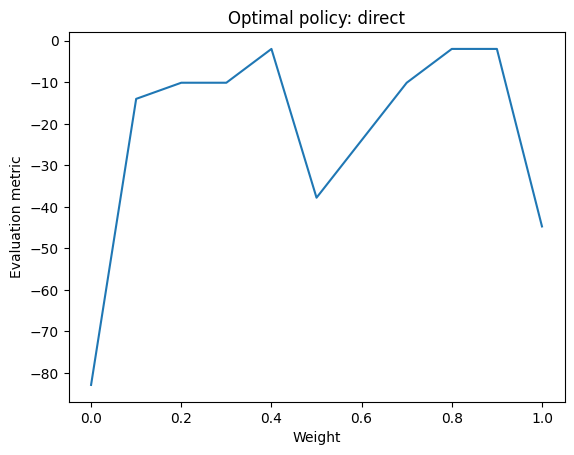

In [10]:
plot_2("direct")

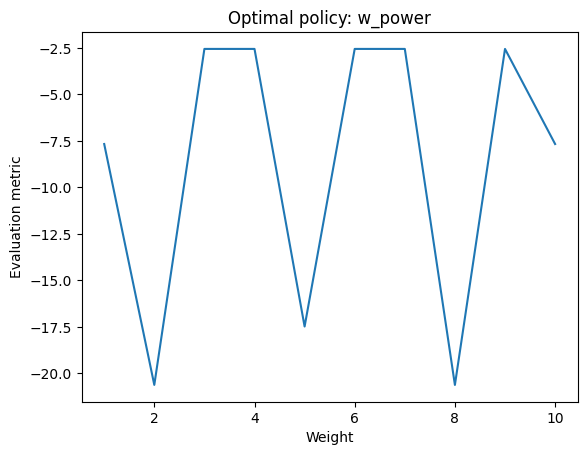

In [11]:
plot_2("w_power")

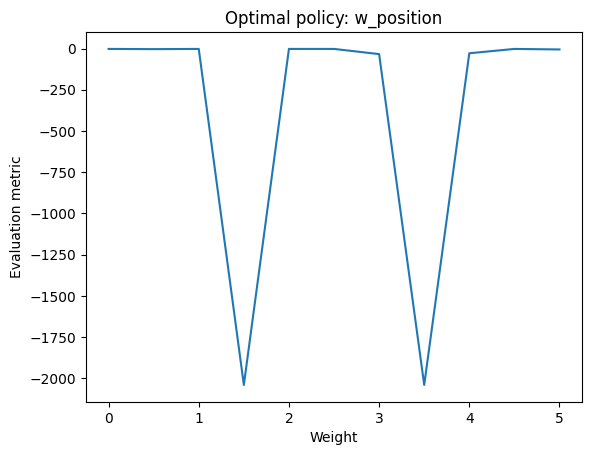

In [12]:
plot_2("w_position")

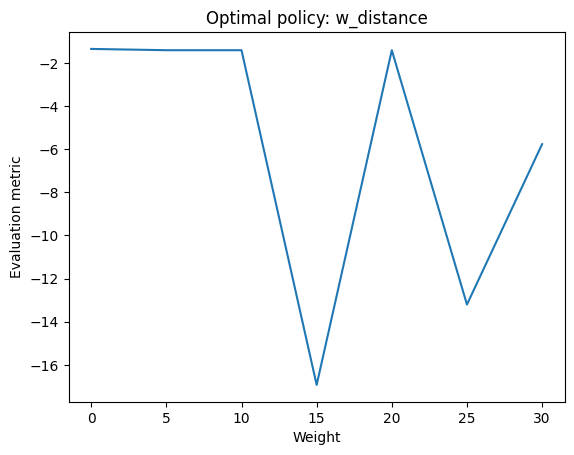

In [13]:
plot_2("w_distance")

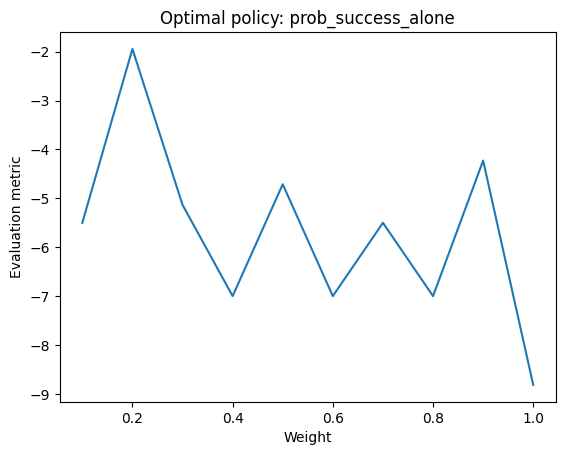

In [14]:
plot_2("prob_success_alone")